# Capstone Project
**Beibarys Nyussupov, Joseph Tadros, Luke Ducker**


This project assesses university professors using a large, publicly available dataset scraped from RateMyProfessor.com. The objective is to integrate core concepts from the course into a single applied analysis and to extract actionable insights about teaching quality and student perceptions. The dataset contains aggregated student ratings and related attributes for a broad sample of professors, with low individual response rates but substantial overall scale. Prior research reports a correlation of approximately 0.7 between RateMyProfessor ratings and official end-of-course teaching evaluations, which supports the analytical value of this source despite known response bias. All data collection and basic structuring steps were completed in advance, while data science-relevant preprocessing, including the identification and handling of missing data, was performed in this project. To address the research questions, appropriate statistical methods were selected based on underlying assumptions, with explicit justification provided throughout the report. Visualizations support interpretation and highlight key patterns in the data. All hypothesis testing uses α = 0.005 to reduce false positive findings (Habibzadeh, 2025). 


## Dataset description

### First dataset: `rmpCapstoneNum.csv`
Dataset contains 89893 records. Each of these
records (rows) corresponds to information about one professor. 

Columns:

`1: Average Rating (the arithmetic mean of all individual quality ratings of this professor)`

`2: Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)`

`3: Number of ratings (simply the total number of ratings these averages are based on)`

`4: Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)`

`5: The proportion of students that said they would take the class again`

`6: The number of ratings coming from online classes`

`7: Male gender (Boolean – 1: determined with high confidence that professor is male)`

`8: Female (Boolean – 1: determined with high confidence that professor is female`


### Second dataset: ` rmpCapstoneQual.csv`
Dataset contains same 89893 records. 

Columns: 

`1: Major/Field`

`2: University`

`3: US State (2 letter abbreviation)`

### Third dataset: `rmpCapstoneTags.csv`
Dataset contains same 89893 records. 

The numbers in these columns correspond to the raw number of “tags” a professor has received. A student can award up to 3 such tags, but doesn’t have to award any. These tags are supposed to characterize the teaching style of the professor qualitatively, beyond ratings. 

Columns: 

`1: “Tough grader”`

`2: “Good feedback”`

`3: “Respected”`

`4: “Lots to read”`

`5: “Participation matters”`

`6: “Don’t skip class or you will not pass”`

`7: “Lots of homework”`

`8: “Inspirational”`

`9: “Pop quizzes!”`

`10: “Accessible”`

`11: “So many papers”`

`12: “Clear grading”`

`13: “Hilarious”`

`14: “Test heavy”`

`15: “Graded by few things”`

`16: “Amazing lectures”`

`17: “Caring”`

`18: “Extra credit”`

`19: “Group projects”`

`20: “Lecture heavy"`

In [1]:
# libraries 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy import stats
from scipy.stats import randint, uniform

from cliffs_delta import cliffs_delta as cd

# machine learning 
# train test split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (KFold, StratifiedKFold, 
                                     train_test_split,
                                     cross_val_score, cross_validate, 
                                     GridSearchCV, RandomizedSearchCV)
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import (plot_optimization_history, 
                                  plot_param_importances, 
                                  plot_slice, 
                                  plot_parallel_coordinate)



# preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer

# evaluation
from sklearn.metrics import (r2_score, root_mean_squared_error, 
                             mean_squared_error, recall_score, precision_score, 
                             f1_score, accuracy_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report, roc_curve, auc)
import shap

# models 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, ElasticNetCV
from sklearn import svm

# cloning model 
from sklearn.base import clone



# reproducibility 
import random

# specify seed 
n_number = 12250697
random.seed(n_number)
np.random.seed(n_number)

In [2]:
# useful function
# simple significance test interpretation
def significance(alpha, p_value):
    """
    Decide based on alpha. 
    Note: p is the probability, under H0, of observing a statistic at least this extreme.

    """
    print(f"p-value: {p_value:.6g}")
    if p_value < alpha:
        print(f"p = {p_value:.6g} < α = {alpha} = Reject H0 (statistically significant).")
    else:
        print(f"p = {p_value:.6g} ≥ α = {alpha} = Fail to reject H0 (not statistically significant).")

# short-cut for assessing regression model
def score_model(model, x_train, x_test, y_train, y_test):

    # fit the model 
    model.fit(x_train, y_train)

    y_train_hat = model.predict(x_train)
    y_test_hat = model.predict(x_test)

    #r2_score
    train_r2 = r2_score(y_train, y_train_hat)
    test_r2 = r2_score(y_test, y_test_hat)

    #mse
    train_rmse = root_mean_squared_error(y_train, y_train_hat)
    test_rmse = root_mean_squared_error(y_test, y_test_hat)

    out = {
        "Training RMSE": train_rmse,
        "Training R2": train_r2,
        "Testing RMSE": test_rmse,
        "Testing R2": test_r2
    }

    return out

# fine-tuning function for models (optuna)
def start_study_optuna(objective, n_trials, sampler_seed, direction="minimize"):
    # sampler for reproducibility
    sampler = TPESampler(seed=sampler_seed)

    # start the study for fine-tuning
    study = optuna.create_study(direction=direction, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    # print best parameters 
    print(f"Best Params: {study.best_params}")
    return study

# short-cut for assessing classification model
def score_classifier(model, x_train, x_test, y_train, y_test, threshold=0.5):

    # fit model
    model.fit(x_train, y_train)

    # predicted probabilities
    y_train_proba = model.predict_proba(x_train)[:, 1]
    y_test_proba = model.predict_proba(x_test)[:, 1]

    # predicted classes
    y_train_hat = (y_train_proba >= threshold).astype(int)
    y_test_hat = (y_test_proba >= threshold).astype(int)

    # confusion matrix on test
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat).ravel()

    # specificity
    specificity = tn / (tn + fp)

    out = {
        # probability-based metrics
        "Training ROC-AUC": roc_auc_score(y_train, y_train_proba),
        "Testing ROC-AUC": roc_auc_score(y_test, y_test_proba),

        # threshold-based metrics
        "Training Accuracy": accuracy_score(y_train, y_train_hat),
        "Testing Accuracy": accuracy_score(y_test, y_test_hat),

        "Training Precision": precision_score(y_train, y_train_hat),
        "Testing Precision": precision_score(y_test, y_test_hat),

        "Training Recall": recall_score(y_train, y_train_hat),  # sensitivity
        "Testing Recall": recall_score(y_test, y_test_hat),

        "Testing Specificity": specificity,

        "Training F1": f1_score(y_train, y_train_hat),
        "Testing F1": f1_score(y_test, y_test_hat),

        # diagnostics
        "Confusion Matrix (test)": [[tn, fp], [fn, tp]]
    }

    return out

# function for ROC-AUC plot 
def add_roc(ax, y_true, y_prob, label, lw=2):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, linewidth=lw, label=f"{label} (AUC={roc_auc:.4f})")
    return roc_auc

## Pre-processing

In [3]:
# read and write locations
data_folder = os.path.join("..", "data")
raw_folder = os.path.join(data_folder, "raw")
processed_folder = os.path.join(data_folder, "processed")

# file names
rmp_num_filename = "rmpCapstoneNum.csv"
rmp_qual_filename = "rmpCapstoneQual.csv"
rmp_tags_filename = "rmpCapstoneTags.csv"

In [4]:
# import the data 

# import the data 
df_num = pd.read_csv(os.path.join(raw_folder, rmp_num_filename), header=None)
df_qual = pd.read_csv(os.path.join(raw_folder, rmp_qual_filename), header=None)
df_tags = pd.read_csv(os.path.join(raw_folder, rmp_tags_filename), header=None)

In [5]:
# headers for first dataset 
df_num_column_names = [
     "average_rating",
     "average_difficulty",
     "number_of_ratings",
     "received_a_pepper",
     "would_take_again",
     "number_of_ratings_online",
     "male_gender",
     "female_gender",
]

# headers for second dataset
df_qual_column_names = [
     "major",
     "university",
     "state",
]

# headers for third dataset 
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

# assign headers to dataframes using .columns attribute 
df_num.columns = df_num_column_names
df_qual.columns = df_qual_column_names
df_tags.columns = df_tags_column_names

In [6]:
# join the data for the easier manipulation 
df = df_num.join(df_qual).join(df_tags)

In [7]:
# check the data set (first five rows)
df.head()

average_rating  average_difficulty  number_of_ratings  received_a_pepper  \
0             5.0                 1.5                2.0                0.0   
1             NaN                 NaN                NaN                NaN   
2             3.2                 3.0                4.0                0.0   
3             3.6                 3.5               10.0                1.0   
4             1.0                 5.0                1.0                0.0   

   would_take_again  number_of_ratings_online  male_gender  female_gender  \
0               NaN                       0.0            0              1   
1               NaN                       NaN            0              0   
2               NaN                       0.0            1              0   
3               NaN                       0.0            0              0   
4               NaN                       0.0            0              0   

              major                university  ... so_many_papers  \
0  Criminal Justice   George Mason University  ...              0   
1               NaN                       NaN  ...              0   
2           English  Alabama State University  ...              0   
3           English    University of Kentucky  ...              0   
4           English         Keiser University  ...              0   

   clear_grading  hilarious  test_heavy  graded_by_few_things  \
0              0          0           0                     0   
1              0          0           0                     0   
2              0          0           0                     0   
3              2          1           0                     0   
4              0          0           0                     0   

   amazing_lectures  caring  extra_credit  group_projects  lecture_heavy  
0                 0       0             0               0              1  
1                 0       0             0               0              0  
2                 0       0             0               0              0  
3                 0       0             0               1              0  
4                 0       0             0               0              0  

[5 rows x 31 columns]

In [8]:
# information about the dataset 
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 89893 entries, 0 to 89892
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           89893 non-null  int64  
 7   female_gender                         89893 non-null  int64  
 8   major                                 70004 non-null  str    
 9   university                            70004 non-null  str    
 10  state                                 70004 non-null  str    
 11  tough_grader              

### Null Values

In [9]:
# check null values of the dataset by each column. 
df.isna().sum()

average_rating                          19889
average_difficulty                      19889
number_of_ratings                       19889
received_a_pepper                       19889
would_take_again                        77733
number_of_ratings_online                19889
male_gender                                 0
female_gender                               0
major                                   19889
university                              19889
state                                   19889
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

A large block of missing data appears in the dataset. Exactly 19,889 records share missing values across all core numerical, categorical, and qualitative variables, with the exception of the “would take again” column. These missing values occur in the same row positions, which indicates a systematic issue rather than random missingness. In addition, all tag variables equal zero for these same records, which implies an absence of meaningful rating information rather than true zero-valued responses. Together, these patterns suggest these rows do not represent valid professor evaluations. Removing all 19,889 records is therefore justified, as retaining them would introduce noise and bias.

In [10]:
# drop null values from the dataset 
df = df.dropna(subset="average_rating")
# check the results
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        57844
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

In [11]:
# check information about the dataset after removal 
df.info()

<class 'pandas.DataFrame'>
Index: 70004 entries, 0 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           70004 non-null  int64  
 7   female_gender                         70004 non-null  int64  
 8   major                                 70004 non-null  str    
 9   university                            70004 non-null  str    
 10  state                                 70004 non-null  str    
 11  tough_grader                   

After removing the invalid records, the dataset contains 70,004 observations. The only remaining missing data is in the would_take_again variable, where a large proportion of values is missing. This variable is a bounded proportion, and the extent of missingness is too high for null values removal or imputation to be appropriate. Imputing values would impose artificial structure on a substantial share of the data and bias both estimates and inference. For this reason, we do not modify this column unless explicitly required. 

### Number of ratings threshold 
This section addresses the reliability of average professor ratings. An average rating based on very few student evaluations is unstable and can produce extreme values that do not reflect typical teaching quality. Professors with only one or two ratings are therefore not comparable to those evaluated by many students. To reduce noise and improve interpretability, an optimal number of ratings threshold is chosen and applied so that average ratings are computed and analyzed only when they are supported by a sufficient volume of observations. This choice reduces the influence of outliers driven by sparse data and ensures that comparisons across professors rely on more reliable estimates.

In [12]:
# distribution of number of ratings 
df["number_of_ratings"].describe()


count    70004.000000
mean         5.374721
std          8.136628
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        393.000000
Name: number_of_ratings, dtype: float64

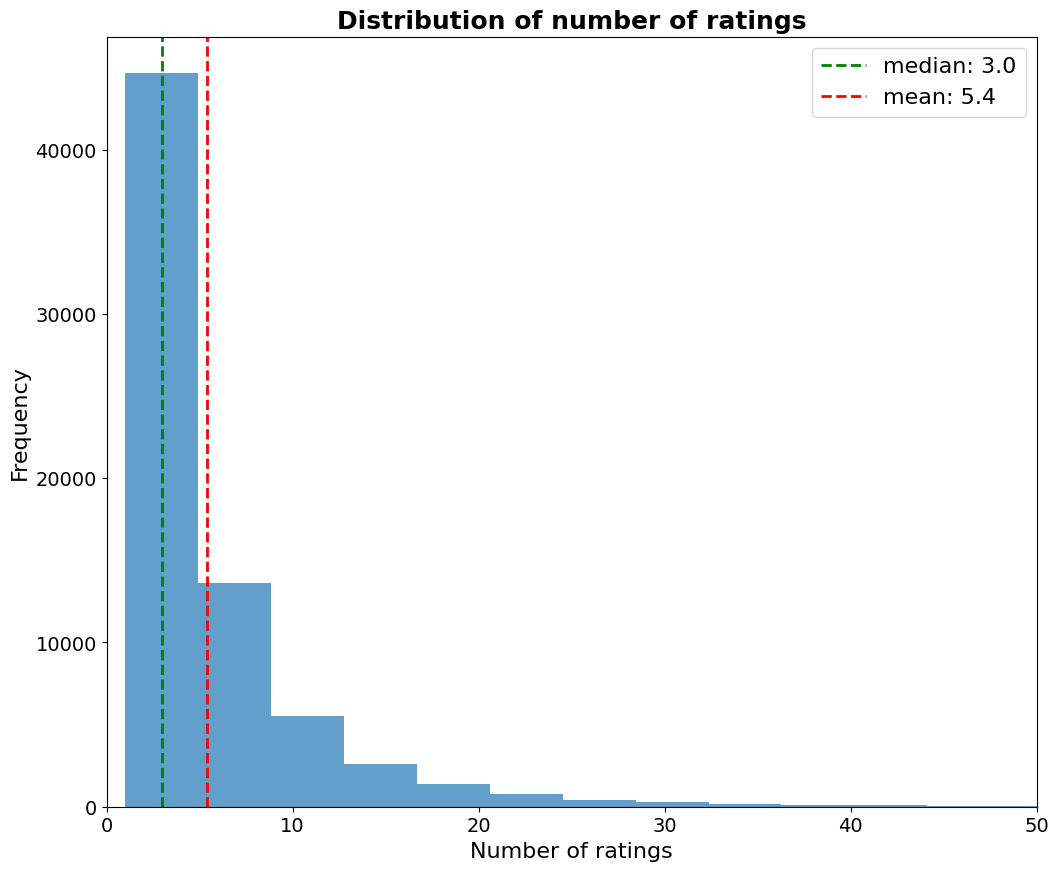

In [13]:
# plot for distribution of number of ratings 
plt.figure(figsize = (12, 10))

# histogram 
plt.hist(df["number_of_ratings"], 
         bins = 100, 
         alpha = 0.7)

# show median and mean value on the plot 
# median
plt.axvline(df["number_of_ratings"].median(), 
           color = "green", 
           linestyle = "dashed", 
           linewidth = 2, 
           label = f"median: {df['number_of_ratings'].median():.1f}")

# mean
plt.axvline(df["number_of_ratings"].mean(), 
           color = "red", 
           linestyle = "dashed", 
           linewidth = 2, 
           label= f"mean: {df['number_of_ratings'].mean():.1f}")

# aesthetics 
# title
plt.title("Distribution of number of ratings", 
          fontweight = "bold", 
          fontsize = 18)

# x axis 
plt.xlabel("Number of ratings", 
           fontsize = 16)
# limit
plt.xlim(0, 50)

# y axis
plt.ylabel("Frequency", 
           fontsize = 16)
# size for both x and y ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot
plt.show()

In [14]:
# filter out the professors with less than 5 ratings (mean)
df_filtered = df[df["number_of_ratings"] >= 5].copy()

In [15]:
# check the distribution and information about the data after filter 
df_filtered["number_of_ratings"].describe()

count    25368.000000
mean        11.150662
std         11.327791
min          5.000000
25%          6.000000
50%          8.000000
75%         12.000000
max        393.000000
Name: number_of_ratings, dtype: float64

The distribution of the number of ratings is highly right skewed, with a median of 3 and a mean of 5.4. Most professors receive only a small number of ratings, which leads to unstable and potentially extreme average values. To address this, we set a minimum threshold of five ratings and excluded professors with fewer than five evaluations. This cutoff is close to the mean and removes cases where average ratings are driven by very sparse data, while preserving the majority of the sample and improving the reliability of comparisons across professors. After applying this filter, 25,368 professors remain in the analysis dataset.


In [16]:
# info about the dataset 
df_filtered.info()

<class 'pandas.DataFrame'>
Index: 25368 entries, 3 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        25368 non-null  float64
 1   average_difficulty                    25368 non-null  float64
 2   number_of_ratings                     25368 non-null  float64
 3   received_a_pepper                     25368 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              25368 non-null  float64
 6   male_gender                           25368 non-null  int64  
 7   female_gender                         25368 non-null  int64  
 8   major                                 25368 non-null  str    
 9   university                            25368 non-null  str    
 10  state                                 25368 non-null  str    
 11  tough_grader                   

### Categorical variables 
In this section, we address the handling of categorical variables. Teaching style tags were normalized by dividing each tag count by the total number of tags received by a professor, converting raw counts into proportions. This normalization controls for differences in the total number of ratings and ensures that tag values are comparable across professors. Cases with no assigned tags resulted in undefined values after normalization and were set to zero, reflecting the absence of tag information rather than meaningful signal.

In addition, we examine the gender indicators provided in the dataset. The male and female variables are treated as categorical indicators.

In [17]:
# distribution of all tags before normalization 
# starting from 11th variable 
# .describe 
df_filtered.iloc[:, 11:].describe()

tough_grader  good_feedback     respected  lots_to_read  \
count  25368.000000   25368.000000  25368.000000  25368.000000   
mean       2.036976       2.640374      1.920451      1.548841   
std        3.279020       4.120596      3.634944      2.718146   
min        0.000000       0.000000      0.000000      0.000000   
25%        0.000000       1.000000      0.000000      0.000000   
50%        1.000000       2.000000      1.000000      1.000000   
75%        3.000000       3.000000      3.000000      2.000000   
max      112.000000     171.000000    186.000000     82.000000   

       participation_matters  dont_skip_class_or_you_will_not_pass  \
count           25368.000000                          25368.000000   
mean                1.778185                              1.838261   
std                 2.903643                              2.988417   
min                 0.000000                              0.000000   
25%                 0.000000                              0.000000   
50%                 1.000000                              1.000000   
75%                 2.000000                              2.250000   
max                82.000000                            110.000000   

       lots_of_homework  inspirational   pop_quizzes    accessible  \
count      25368.000000   25368.000000  25368.000000  25368.000000   
mean           1.600047       1.216809      0.393843      0.827854   
std            3.058181       2.803210      1.420362      1.794848   
min            0.000000       0.000000      0.000000      0.000000   
25%            0.000000       0.000000      0.000000      0.000000   
50%            1.000000       0.000000      0.000000      0.000000   
75%            2.000000       1.000000      0.000000      1.000000   
max          141.000000     119.000000     97.000000     63.000000   

       so_many_papers  clear_grading     hilarious    test_heavy  \
count    25368.000000   25368.000000  25368.000000  25368.000000   
mean         0.286187       1.505401      1.420293      0.385722   
std          0.943474       2.408472      3.664116      1.241309   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       1.000000      0.000000      0.000000   
75%          0.000000       2.000000      2.000000      0.000000   
max         64.000000      77.000000    224.000000     81.000000   

       graded_by_few_things  amazing_lectures        caring  extra_credit  \
count          25368.000000      25368.000000  25368.000000  25368.000000   
mean               0.336447          1.423329      2.358050      1.159256   
std                0.854666          3.159003      3.540912      2.935454   
min                0.000000          0.000000      0.000000      0.000000   
25%                0.000000          0.000000      0.000000      0.000000   
50%                0.000000          0.000000      1.000000      0.000000   
75%                0.000000          2.000000      3.000000      1.000000   
max               39.000000        136.000000    127.000000    128.000000   

       group_projects  lecture_heavy  
count    25368.000000   25368.000000  
mean         0.533783       1.094056  
std          1.661896       1.981580  
min          0.000000       0.000000  
25%          0.000000       0.000000  
50%          0.000000       0.000000  
75%          0.000000       1.000000  
max         92.000000      38.000000

In [18]:
# calculate total # of tags for each professor
total_tag_counts = df_filtered[df_tags_column_names].sum(axis = 1)

# normalize tag columns to be between 0 and 1 by dividing tag counts by total tag counts
for col in df_tags_column_names:
    df_filtered[col] = df_filtered[col] / total_tag_counts

# fill na values with 0 that resulted from divide by zero issues
df_filtered[df_tags_column_names] = df_filtered[df_tags_column_names].fillna(0)

In [19]:
# look at the distribution of tags after the normalization 
df_filtered.iloc[:, 11:].describe()

tough_grader  good_feedback     respected  lots_to_read  \
count  25368.000000   25368.000000  25368.000000  25368.000000   
mean       0.085069       0.100868      0.068629      0.062054   
std        0.107520       0.091155      0.074261      0.084513   
min        0.000000       0.000000      0.000000      0.000000   
25%        0.000000       0.021277      0.000000      0.000000   
50%        0.047619       0.083333      0.055556      0.025000   
75%        0.136364       0.153846      0.111111      0.100000   
max        1.000000       1.000000      0.600000      1.000000   

       participation_matters  dont_skip_class_or_you_will_not_pass  \
count           25368.000000                          25368.000000   
mean                0.069651                              0.069879   
std                 0.078161                              0.078915   
min                 0.000000                              0.000000   
25%                 0.000000                              0.000000   
50%                 0.052632                              0.052632   
75%                 0.111111                              0.111111   
max                 1.000000                              1.000000   

       lots_of_homework  inspirational   pop_quizzes    accessible  \
count      25368.000000   25368.000000  25368.000000  25368.000000   
mean           0.064489       0.041886      0.015234      0.028761   
std            0.086387       0.061327      0.044127      0.045961   
min            0.000000       0.000000      0.000000      0.000000   
25%            0.000000       0.000000      0.000000      0.000000   
50%            0.029168       0.000000      0.000000      0.000000   
75%            0.100000       0.068966      0.000000      0.050000   
max            1.000000       0.500000      0.500000      0.666667   

       so_many_papers  clear_grading     hilarious    test_heavy  \
count    25368.000000   25368.000000  25368.000000  25368.000000   
mean         0.012109       0.058709      0.049038      0.013922   
std          0.034345       0.067916      0.075274      0.035435   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.044776      0.000000      0.000000   
75%          0.000000       0.090909      0.076923      0.000000   
max          0.500000       0.666667      0.625000      1.000000   

       graded_by_few_things  amazing_lectures        caring  extra_credit  \
count          25368.000000      25368.000000  25368.000000  25368.000000   
mean               0.014433          0.047059      0.088719      0.041532   
std                0.035939          0.064779      0.082976      0.068912   
min                0.000000          0.000000      0.000000      0.000000   
25%                0.000000          0.000000      0.000000      0.000000   
50%                0.000000          0.000000      0.074074      0.000000   
75%                0.000000          0.076923      0.142857      0.065217   
max                0.500000          0.666667      1.000000      0.862069   

       group_projects  lecture_heavy  
count    25368.000000   25368.000000  
mean         0.021918       0.045526  
std          0.052664       0.071531  
min          0.000000       0.000000  
25%          0.000000       0.000000  
50%          0.000000       0.000000  
75%          0.000000       0.071429  
max          0.545455       1.000000

Now, we are looking at gender variables. 

In [20]:
# check male and female gender error, where both are 1, or both 0
both_11 = df_filtered[(df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)].shape[0]
both_00 = df_filtered[(df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)].shape[0]

# print the results 
print(f"Number of professors with both male and female gender as 1: {both_11}")
print(f"Number of professors with both male and female gender as 0: {both_00}")

Number of professors with both male and female gender as 1: 776
Number of professors with both male and female gender as 0: 6170


This is a clear data error and should be removed. 

In [21]:
# drop rows where both male and female gender are 1 or 0
df_filtered_final = df_filtered[~((df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)) & 
                          (~((df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)))].copy()

# check the results
df_filtered_final.info()


<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  str    
 9   university                            18422 non-null  str    
 10  state                                 18422 non-null  str    
 11  tough_grader                   

After data pre-processing, we are left with ~18k rows. Now we will proceed answering research questions. 

## Q1. Activists have asserted that there is a strong gender bias in student evaluations of professors, with male professors enjoying a boost in rating from this bias...We would like you to answer the question whether there is evidence of a pro-male gender bias in this dataset.


In [128]:
# separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df1_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df1_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [129]:
# count number of professors in each group
print(f"Number of male professors: {df1_male.shape[0]}")
print(f"Number of female professors: {df1_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


A difference is noticeable, but not very large. We can proceed with the analysis. 

C:\Users\nyuss\AppData\Local\Temp\ipykernel_37420\2381853625.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


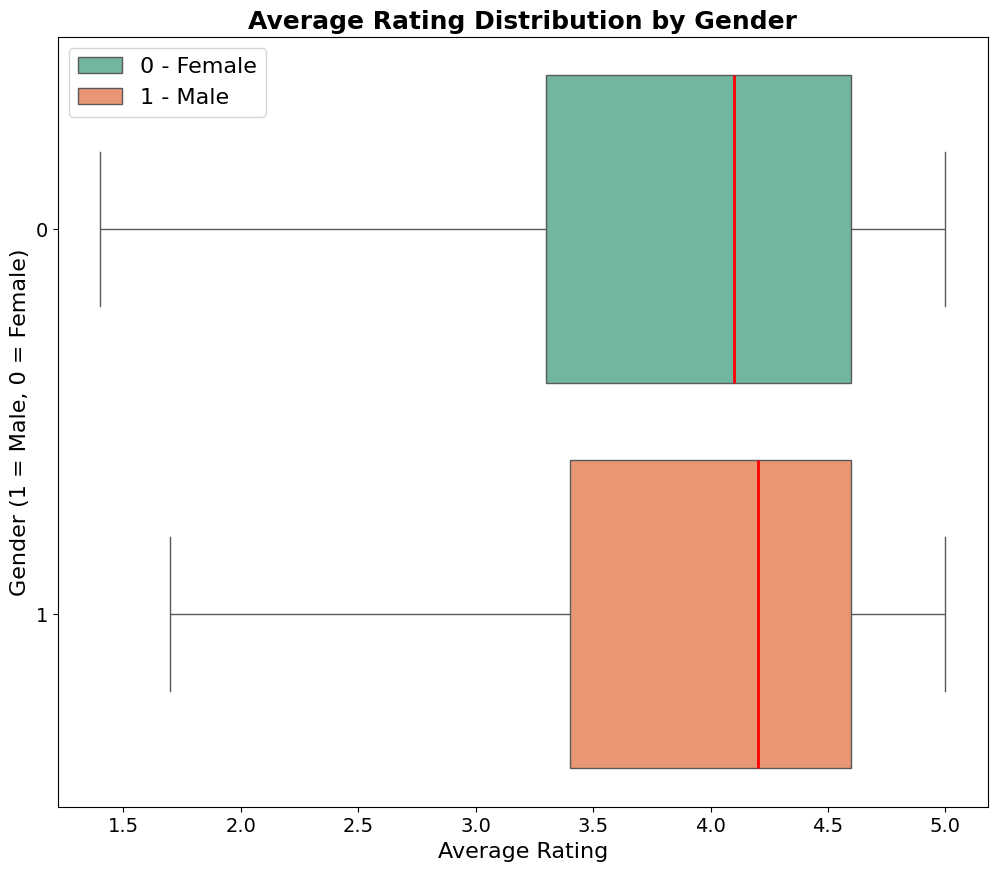

In [130]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_rating', 
            y='male_gender', 
            palette = "Set2", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The boxplot suggests a small difference in average ratings by gender. The distributions for male and female professors overlap substantially, but the male distribution appears slightly shifted to the right, with a higher median average rating. The spread of ratings is similar across genders, indicating comparable variability. To further test the difference, we have to apply a significance test. 

### Mann-Whitney U Test (one-tailed) 

`Rationale for the test:` For this question, we test whether male professors receive higher average ratings than female professors. Average ratings are bounded, derived from ordinal Likert-scale responses, and do not reliably satisfy normality assumptions at the individual professor level. Population parameters such as the true mean and variance are unknown.

We therefore use a one-sided Mann-Whitney U test, which is appropriate for comparing central tendency between two independent groups without assuming normality. This test evaluates whether ratings for one group tend to be systematically higher than those for the other, consistent with the directional hypothesis of pro-male bias.

`Null hypothesis (H0):` The median average rating for male professors is equal to the median average rating for female professors.

`Alternative hypothesis (Ha):` The median average rating for male professors is higher than the median average rating for female professors.

`Significance level:` 0.005

`Interpretation:` The p-value represents the probability of observing a difference in average ratings at least as extreme as the one observed, assuming the null hypothesis is true.
- If the p-value is smaller than 0.005, we reject H0 and conclude that there is statistically significant evidence of a pro-male bias in average ratings.
- If the p-value is larger than 0.005, we fail to reject H0 and conclude that the observed difference is consistent with random variation and does not provide sufficient evidence of gender bias.

In [132]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df1_male['average_rating'], 
                                     df1_female['average_rating'], 
                                     alternative='greater')
# interpretation 
significance(0.005, p_value)


p-value: 0.00024523
p = 0.00024523 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (0.00024523) is smaller than the significance threshold of 0.005, so we reject the null hypothesis and conclude that the median average rating for male professors is higher than that for female professors.

This result does not establish causal evidence of pro-male rating bias, as the data are observational, not randomized, and we do not control for all potential confounders such as course type, institution, teaching experience, or selection effects in who chooses to rate professors.

However, we do find statistical evidence of a systematic difference in ratings by gender, with male professors receiving higher typical ratings in this dataset. This pattern is consistent with, but does not by itself prove, the presence of pro-male bias in average professor ratings.

## Q2. Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it is advisable to consider the statistical significance of any observed gender differences in this spread. 

In [133]:
# again_separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df2_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df2_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [134]:
# count number of professors in each group
print(f"Number of male professors: {df2_male.shape[0]}")
print(f"Number of female professors: {df2_female.shape[0]}")


Number of male professors: 10015
Number of female professors: 8407


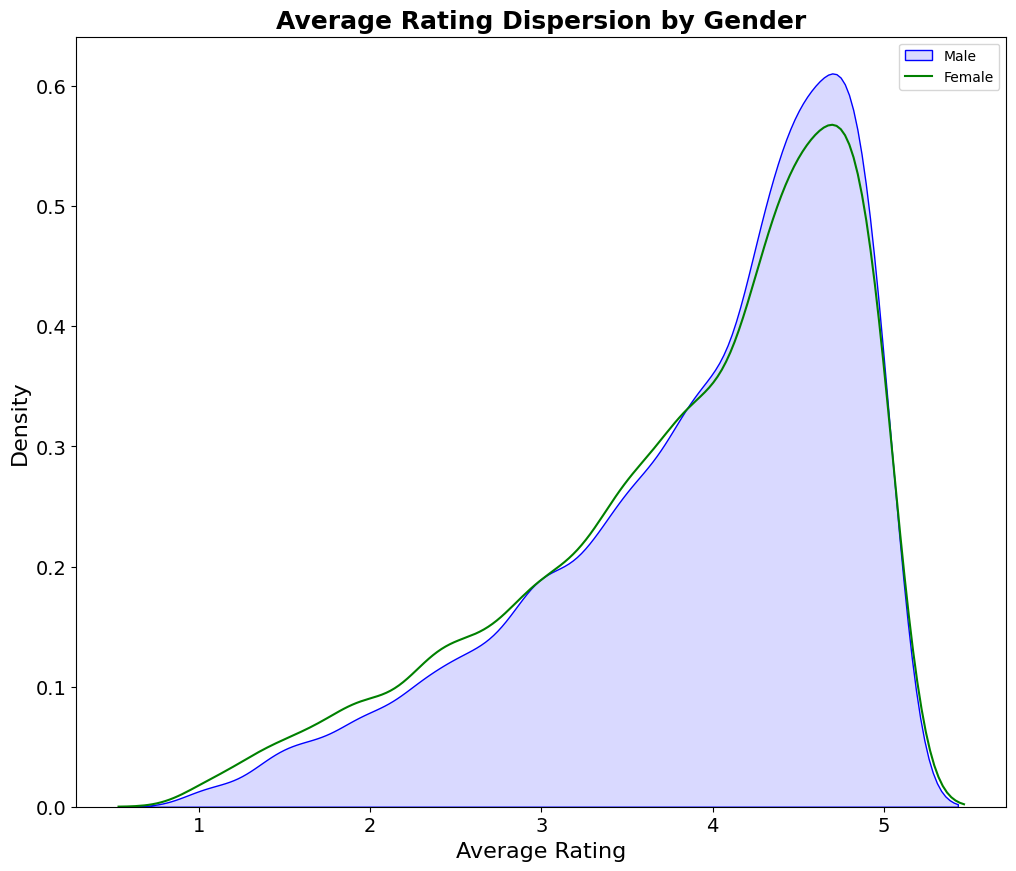

In [135]:
# plot the variance of average rating dipersion between male and female professors
# kernel density plot 
plt.figure(figsize=(12, 10))

# plot
sns.kdeplot(df2_male['average_rating'], 
           label='Male', 
           color='blue', 
           fill=True, 
           legend= True, 
           alpha=0.15
           )
sns.kdeplot(df2_female['average_rating'],
              label='Female', 
              color='green', 
              fill=False, 
              legend= True)

# aesthetics
plt.title('Average Rating Dispersion by Gender', 
          fontweight = "bold",
          fontsize = 18)
# xlabel
plt.xlabel('Average Rating',
              fontsize = 16)
# ylabel
plt.ylabel('Density',
                fontsize = 16)

# axis 
plt.tick_params(axis = "both", 
                labelsize = 14)
# legend 
plt.legend()
# ticks
plt.show()

The density curves for average ratings by gender are highly similar, indicating comparable dispersion for male and female professors. Both distributions cover a similar range of ratings and exhibit similar tail behavior, suggesting no substantial difference in variability. While the male distribution appears slightly shifted to the right, consistent with higher typical ratings observed in Q1, the overall spread and shape of the distributions closely align.

From a visual inspection, we do not observe meaningful differences in variance or dispersion between the two groups. Any differences in spread appear minor relative to the overall similarity of the distributions and are unlikely to reflect a practically important gender difference in rating variability.

This visual evidence suggests that gender differences in ratings are primarily related to central tendency rather than dispersion, motivating a formal statistical test of variance in the subsequent analysis.

### Levene's test 

`Rationale for the test:` This question asks whether male and female professors differ in the spread of their average rating distributions. We need a test of dispersion, not a test of location. Average ratings are bounded (1 to 5) and do not satisfy normality assumptions, so classical variance tests that rely on normality, such as an F-test, are not appropriate. We therefore use Levene's test because it tests equality of variance while remaining robust under non-normal data. We use the median-centered version to further reduce sensitivity to skewness and outliers. The test is two-tailed because the question asks whether dispersion differs in either direction, not whether one gender has higher variance.

`Null hypothesis (H0):` The dispersion (variance) of average ratings for male professors is equal to the dispersion of average ratings for female professors.

`Alternative hypothesis (Ha):` The dispersion of average ratings significantly differs between male and female professors.

`Significance level:` 0.005

If the p-value is smaller than 0.005, we reject H0 and conclude that the dispersion of average ratings differs significantly by gender.

If the p-value is larger than 0.005, we fail to reject H0, indicating that the observed difference in dispersion is consistent with random variation and that the data do not provide sufficient statistical evidence of a gender difference in rating variability.


In [136]:
# dispersion of average ratings 
# levene's test for equal variances
levene_stat, levene_p_value = stats.levene(df2_male['average_rating'], 
                                      df2_female['average_rating'], 
                                      center='median')

# check the result 
significance(0.005, levene_p_value)

p-value: 5.97717e-06
p = 5.97717e-06 < α = 0.005 = Reject H0 (statistically significant).


Since the p-value (0.00000598) is smaller than the significance level α = 0.005, we reject the null hypothesis. This provides statistically significant evidence that the dispersion of average ratings differs between male and female professors. The observed difference in spread is unlikely to be due to random variation alone.

## Q3. What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of average rating), as estimated from this dataset? Please use 95% confidence and make sure to report each/both. 

### Effect size of gender bias in average rating

Because the ratings data are derived from ordinal Likert-scale responses and violate normality assumptions, we do not use parametric effect size measures such as Cohen's d or Hedges' g, which rely on normality and equal variances. Instead, we require a non-parametric effect size that is interpretable and appropriate for rank-based comparisons.

We therefore use Cliff's Delta (δ), a non-parametric measure of effect size suitable for ordinal and non-normal data. Cliff's delta quantifies the degree of distributional non-overlap between two groups by comparing all pairwise observations. It ranges from −1 to +1, where 0 indicates complete overlap and larger absolute values indicate stronger separation between groups.

Following the recommendations in [Meissel and Yao (2024)](https://github.com/NBeibarys/Project-Hypothesis-Testing-of-MovieRatings-Using-Python/blob/main/project_guidelines/Using%20Cliff%E2%80%99s%20Delta%20as%20a%20Non-Parametric%20Effect%20Size%20Measure.pdf), effect sizes are interpreted as:

|δ| < 0.15: negligible effect

0.15 ≤ |δ| < 0.33: small effect

0.33 ≤ |δ| < 0.47: medium effect

|δ| ≥ 0.47: large effect

The sign of δ indicates the direction of the effect relative to the reference group.



To estimate the uncertainty around the effect sizes, we compute 95% confidence intervals using bootstrapping. Bootstrapping is appropriate in this setting because it does not assume normality of the underlying data and is well suited for ordinal outcomes and non-parametric statistics.

For each effect, we repeatedly resample the observed data with replacement and recompute the corresponding effect size on each bootstrap sample. The empirical distribution of these bootstrap estimates is then used to construct percentile-based 95% confidence intervals.

This approach allows us to quantify the likely range of both:
- the location effect (gender difference in average ratings, measured via Cliff's delta), and
- the dispersion effect (gender difference in rating spread, measured via robust dispersion statistics), without relying on parametric assumptions. As a result, the reported confidence intervals reflect the variability inherent in the observed data rather than model-based assumptions.

In [137]:
 # divide average ratings by groups of gender and convert to arrays (bootstrap expects that)
df3_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df3_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result = stats.bootstrap(
    (df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower, ci_upper = result.confidence_interval.low, result.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df3_male['average_rating'], 
                                        df3_female['average_rating'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")




Effect size (Cliffs delta): 0.0297
95% CI: [0.0127, 0.0466]


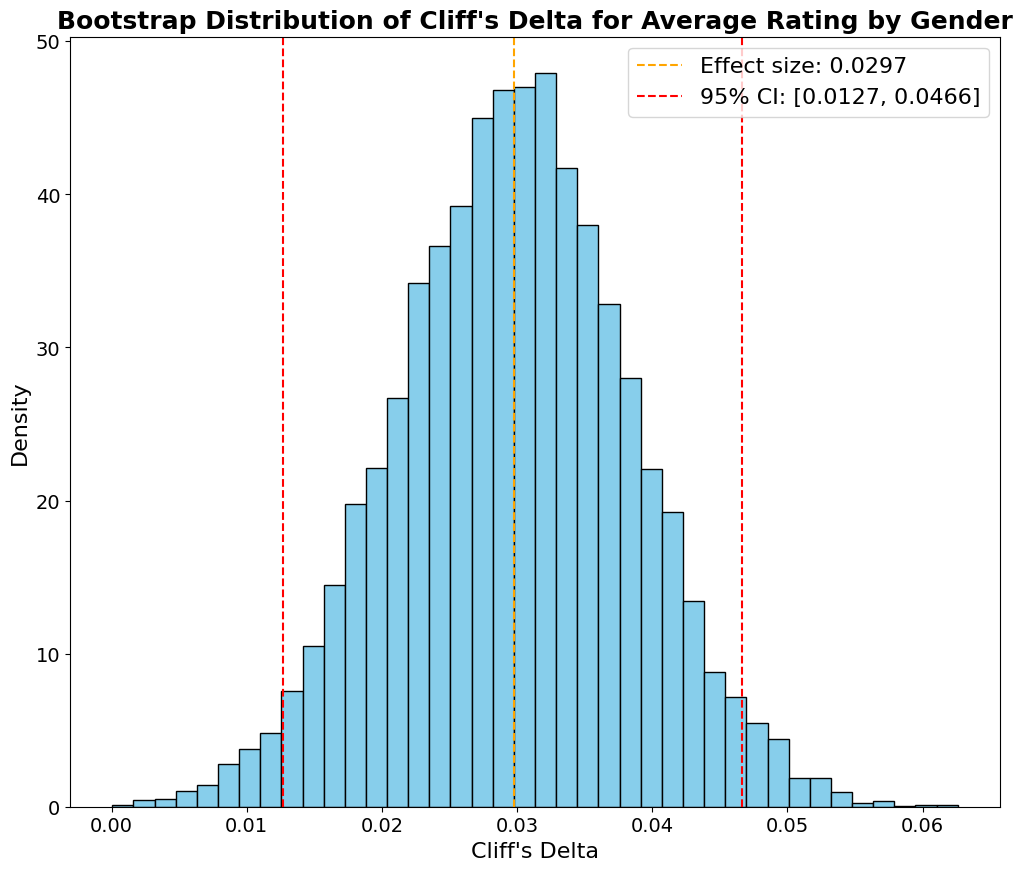

In [ ]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "skyblue",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df3_male['average_rating'].to_numpy(), 
                df3_female['average_rating'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df3_male['average_rating'].to_numpy(), 
                                            df3_female['average_rating'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]"
            )
# upper
plt.axvline(ci_upper, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()
         

A 95 percent confidence interval means that, over repeated samples, 95 percent of such intervals would contain the true Cliff’s delta. In this case, the estimated Cliff’s delta lies between 0.0127 and 0.0466, with a point estimate of 0.0297. This corresponds to a negligible effect size, meaning that the distributions of average ratings for male and female professors are almost entirely overlapping. Although this difference is statistically detectable given the large sample size, it does not represent a practically meaningful difference in central tendency and provides little evidence of substantive gender bias in average ratings.

Now we will compute a point estimate and 95% confidence interval for dispersion difference effect size. To measure the effect size of dispersion, we substract the female variance from male variance. 

### Effect size of gender bias in dispersion of average rating 

In [139]:
# variance difference in average rating for male and female professors
def variance_diff(sample1, sample2, axis = 0):
    # compute variance for each sample
    variance1 = np.var(sample1, ddof = 1)
    variance2 = np.var(sample2, ddof = 1)
    return variance1 - variance2   # male minus female

# compute the bootstrap
result_variance = stats.bootstrap(
    data=(df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()),
    statistic=variance_diff,
    confidence_level=0.95,
    n_resamples=10000,
    method='BCa',
    random_state=n_number,
    vectorized=False
)

# compute the confidence interval
ci_lower_variance, ci_upper_variance = result_variance.confidence_interval.low, result_variance.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (variance difference): {variance_diff(df3_male['average_rating'], df3_female['average_rating'])}")
# confidence interval
print(f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]")



Effect size (variance difference): -0.07755275266973649
95% CI: [-0.1128, -0.0411]


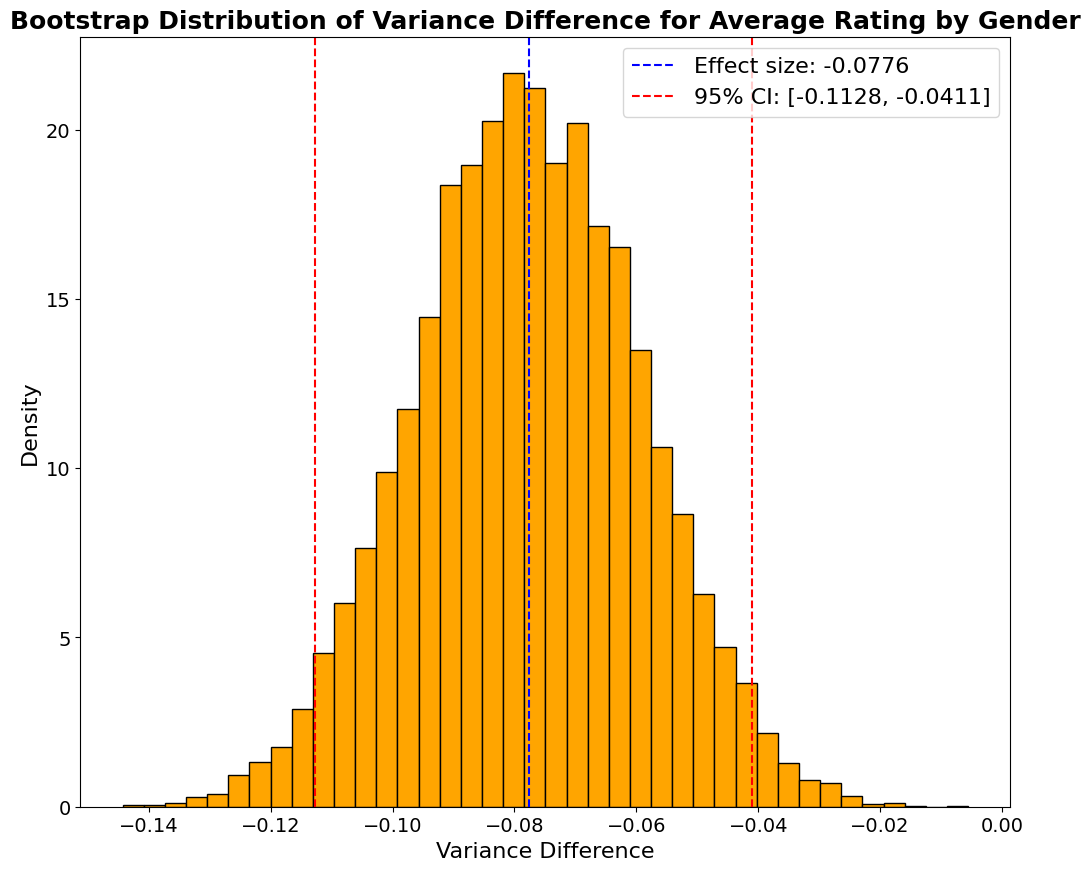

In [140]:
# plot boostrap distribution of variance difference
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_variance.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "orange",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(variance_diff(df3_male['average_rating'], 
                df3_female['average_rating']), 
            color = "blue", 
            linestyle = "dashed", 
            label = f"Effect size: {variance_diff(df3_male['average_rating'], df3_female['average_rating']):.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_variance, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]"
            )
# upper
plt.axvline(ci_upper_variance, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Variance Difference for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Variance Difference", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

# show the plot 
plt.show()
         


The estimated variance difference in average ratings between male and female professors is −0.0776, with a 95 percent CI from −0.1128 to −0.0411. The interval lies entirely below zero, indicating that average ratings for female professors exhibit slightly greater dispersion than those for male professors. However, the magnitude of this difference is very small in absolute terms. This suggests that, although the difference in spread is statistically detectable due to the large sample size, it is negligible in practice and provides little evidence of meaningful gender bias in rating variability.

## Q4.  Is there a gender difference in the tags awarded by students? Make sure to test each of the 20 tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.

`Rationale for the test:` Each teaching tag is converted into a proportion of all tags awarded to a professor in order to account for differences in the total number of ratings. These tag proportions are bounded between 0 and 1 and exhibit skewness, violating normality and equal variance assumptions. Parametric tests are therefore not appropriate.

To compare tag distributions between male and female professors, we use a two-tailed Mann-Whitney U test. This non-parametric test is suitable for comparing two independent groups on ordinal or non-normal data and evaluates whether one group tends to receive systematically higher or lower tag proportions than the other.

`Null hypothesis (H0):` The distribution of tag proportions is the same for male and female professors.

`Alternative hypothesis (Ha):` The distribution of tag proportions significantly differs between male and female professors.

`Significance level:` 0.005

The p-value represents the probability of observing a difference in tag proportions, or a more extreme one, assuming the null hypothesis is true.

If the p-value is smaller than 0.005, we reject H0 and conclude that the tag is awarded in significantly different proportions to male and female professors.
If the p-value is larger than 0.005, we fail to reject H0 and conclude that any observed difference is consistent with random variation.

This test is applied separately to each of the 20 teaching tags in the dataset in order to identify which tags exhibit statistically significant gender differences.

In [141]:
# filter our the data for this question 
df4_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df4_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# filter mask for all tags columns
tag_columns = df_tags_column_names
alpha = 0.005

# list for all tags 
results_q4 = []

# for loop for separating each movie subset into two groups and conducting the non-parametric test
for tag in tag_columns: 
    # separating into two groups
    males = df4_male[tag]
    females = df4_female[tag]

    # conducting the test 
    u_statistic, p_value = stats.mannwhitneyu(males, females, alternative= 'two-sided')
    
    # save data as well
    results_q4.append({
    "tag": tag,
    "n_female": len(females),
    "n_male": len(males),
    "U": u_statistic,
    "p_value": p_value,
    "significant": p_value < alpha
    })
        
    # # use the significance function created 
    # print(f"{tag} Result:")
    # print(f"{significance(0.005, p_value)}\n")

# check the results
results_q4_df = pd.DataFrame(results_q4).sort_values(by = 'p_value', ascending= False)
styled = results_q4_df.style.set_properties(**{
    "background-color": "white",
    "color": "black", 
     "border": "1px solid black"
}).format({"p_value": "{:.6e}"})

# sort by p-value
styled

We tested all 20 tag proportions for gender differences using two tailed Mann-Whitney U tests at a significance level of 0.005. Most tags show statistically detectable gender differences, while a small number do not. The least gendered tags are pop_quizzes and accessible, which have the highest p values and show no evidence of a gender difference, and tough_grader, which shows only weak evidence. The most gendered tags are hilarious, amazing_lectures, and a participation_matters, which have the lowest p values and the strongest statistical evidence of a difference in tag proportions by gender. 

## Q5. Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.

In [142]:
# separate into two groups based on gender
# Male = 1, Male = 0
df5_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df5_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [143]:
# check quantity 
# it is the same number of rows, so this code is just in case
print(f"Number of male professors: {df5_male.shape[0]}")
print(f"Number of female professors: {df5_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


C:\Users\nyuss\AppData\Local\Temp\ipykernel_37420\2358968866.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


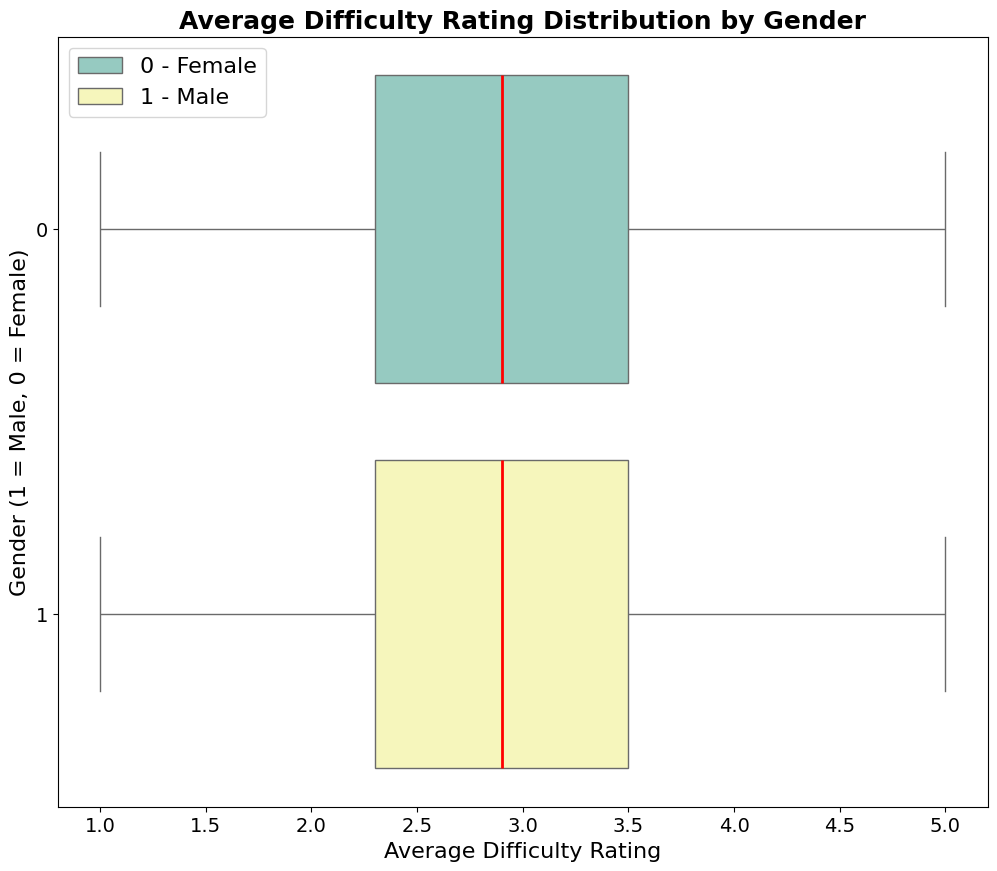

In [144]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_difficulty', 
            y='male_gender', 
            palette = "Set3", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Difficulty Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Difficulty Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The box plots of average difficulty ratings for male and female professors show substantial overlap and do not suggest a clear difference in typical difficulty. Visually, there is no strong evidence of a difference between the two groups. To formally assess whether any difference exists, we apply a two-tailed Mann-Whitney U test.

### Mann-Whitney U Test (two-tailed)

`Rationale for the test`: We use a two-tailed Mann-Whitney U test to compare average difficulty ratings by gender. This test is appropriate because average ratings are ordinal and non-normal.

`Null hypothesis (H0):` Average difficulty ratings for male professors are not different than average difficulty ratings of female professors.

`Alternative hypothesis (Ha):` Average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors.

`Significance level:` 0.005

`Interpretation:` If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors.

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning the data do not provide enough statistical evidence to conclude that there is a significant difference in average difficulty ratings by gender.

In [145]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df5_male['average_difficulty'], 
                                     df5_female['average_difficulty'], 
                                     alternative='two-sided')
# interpretation 
significance(0.005, p_value)

p-value: 0.828753
p = 0.828753 ≥ α = 0.005 = Fail to reject H0 (not statistically significant).


The Mann-Whitney U test yielded a p-value of 0.828753, which is substantially larger than the significance level of 0.005. Therefore, we fail to reject the null hypothesis.

This result indicates that the observed differences in average difficulty ratings between male and female professors are consistent with random variation. The data provide no statistical evidence of a gender difference in perceived course difficulty.

## Q6. Please quantify the likely size of this effect at 95% confidence

Because average difficulty ratings are ordinal and non-normal, parametric effect size measures such as Cohen's d and Hedges' g are not appropriate. As introduced earlier in this report, we therefore use Cliff's delta (δ) as a non-parametric measure of effect size suitable for ordinal data (Meissel & Yao, 2024).

Cliff's delta is interpreted using the same thresholds defined previously: negligible (|δ| < 0.15), small (0.15 ≤ |δ| < 0.33), medium (0.33 ≤ |δ| < 0.47), and large (|δ| ≥ 0.47).

We apply this measure here to quantify the magnitude of any gender difference in average difficulty ratings, complementing the hypothesis test results.

In [146]:
 # divide average difficulty ratings by groups of gender and convert to arrays (bootstrap expects that)
df6_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df6_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result_q6 = stats.bootstrap(
    (df6_male['average_difficulty'].to_numpy(), 
    df6_female['average_difficulty'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower_q6, ci_upper_q6 = result_q6.confidence_interval.low, result_q6.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df6_male['average_difficulty'], 
                                        df6_female['average_difficulty'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]")


Effect size (Cliffs delta): 0.0018
95% CI: [-0.0152, 0.0182]


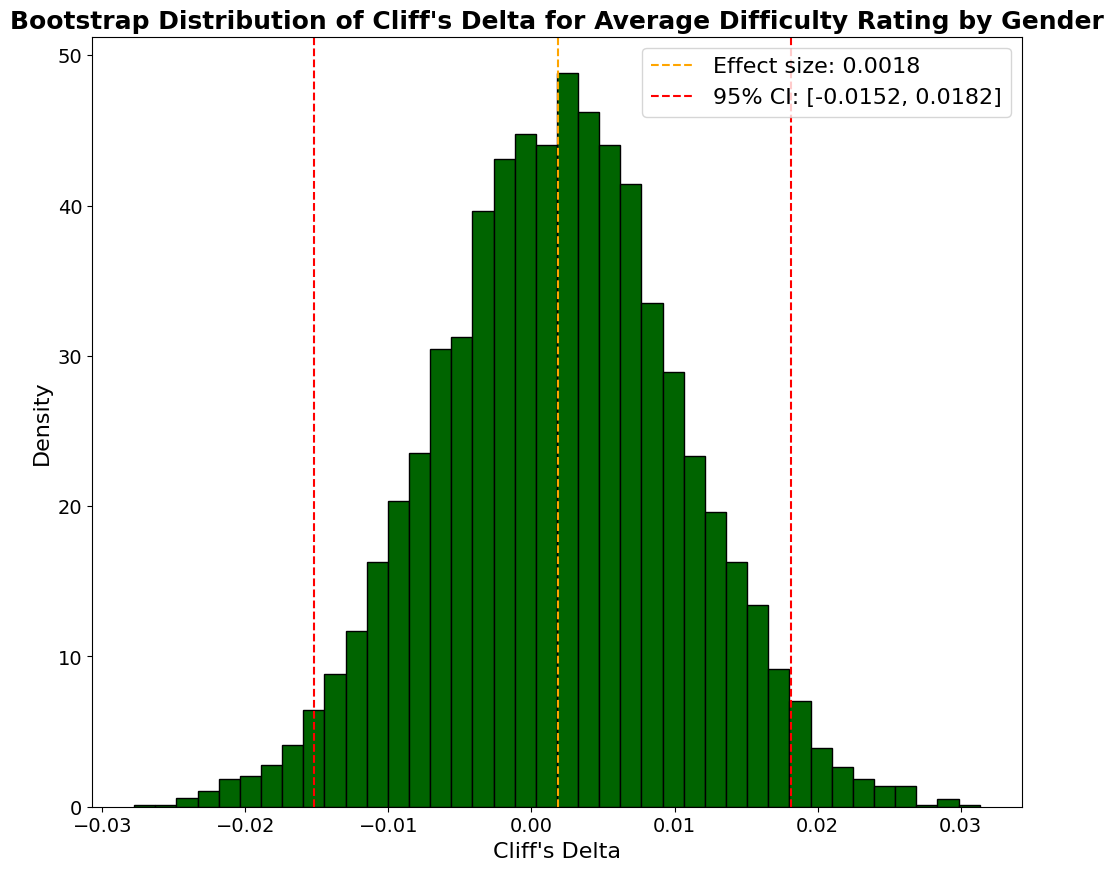

In [148]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_q6.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "darkgreen",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df6_male['average_difficulty'].to_numpy(), 
                df6_female['average_difficulty'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df6_male['average_difficulty'].to_numpy(), 
                                            df6_female['average_difficulty'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_q6, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]"
            )
# upper
plt.axvline(ci_upper_q6, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Difficulty Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

After computing a 95% confidence interval using bootstrap resampling, the estimated Cliff's delta lies between -0.0152 and 0.0182, with a point estimate of 0.0018. This corresponds to a negligible effect size, indicating that the distributions of average difficulty ratings for male and female professors almost completely overlap.

Because the confidence interval includes zero and remains well within the negligible range, there is no practical evidence of a meaningful gender difference in perceived course difficulty. This result reinforces the hypothesis test findings and suggests that any statistically detectable differences are not substantively important at the user-experience level.

## Q7 - Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? 

### Linear Regression

In [22]:
# copy the data for the question 
df_7 = df_filtered_final[df_num_column_names].copy()

# drop female_gender as it is redundant (we have male_gender binary variable already)
df_7 = df_7.drop(columns = ['female_gender'])
# check 
df_7.info()

<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_rating            18422 non-null  float64
 1   average_difficulty        18422 non-null  float64
 2   number_of_ratings         18422 non-null  float64
 3   received_a_pepper         18422 non-null  float64
 4   would_take_again          8849 non-null   float64
 5   number_of_ratings_online  18422 non-null  float64
 6   male_gender               18422 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.1 MB


In [23]:
# split the data into x and y 
# x 
x_7 = df_7.drop(columns = "average_rating")

# y 
y_7 = df_7["average_rating"]

# split the data into train and test data 
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_7, y_7, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_7.shape[0]}\n')
print(f'Number of rows for test data:{y_test_7.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [24]:
# correlation matrix for x and y 
corr7_yx = x_train_7.corrwith(y_train_7, 
                              method = 'pearson').sort_values(ascending= False)
# check 
corr7_yx

would_take_again            0.878465
received_a_pepper           0.454502
number_of_ratings           0.046599
male_gender                 0.034578
number_of_ratings_online   -0.019484
average_difficulty         -0.612096
dtype: float64

The correlations indicate that average ratings are driven primarily by student satisfaction and course rigor rather than demographics. Would take again shows an extremely strong positive association with ratings, while average difficulty exhibits a strong negative relationship, suggesting that harder courses tend to receive lower evaluations. Received a pepper has a moderate positive association, whereas gender, number of ratings, and online share show near-zero correlations, indicating minimal influence. These results suggest that instructional experience and perceived difficulty dominate rating outcomes, while demographic and exposure-related variables contribute little explanatory value.

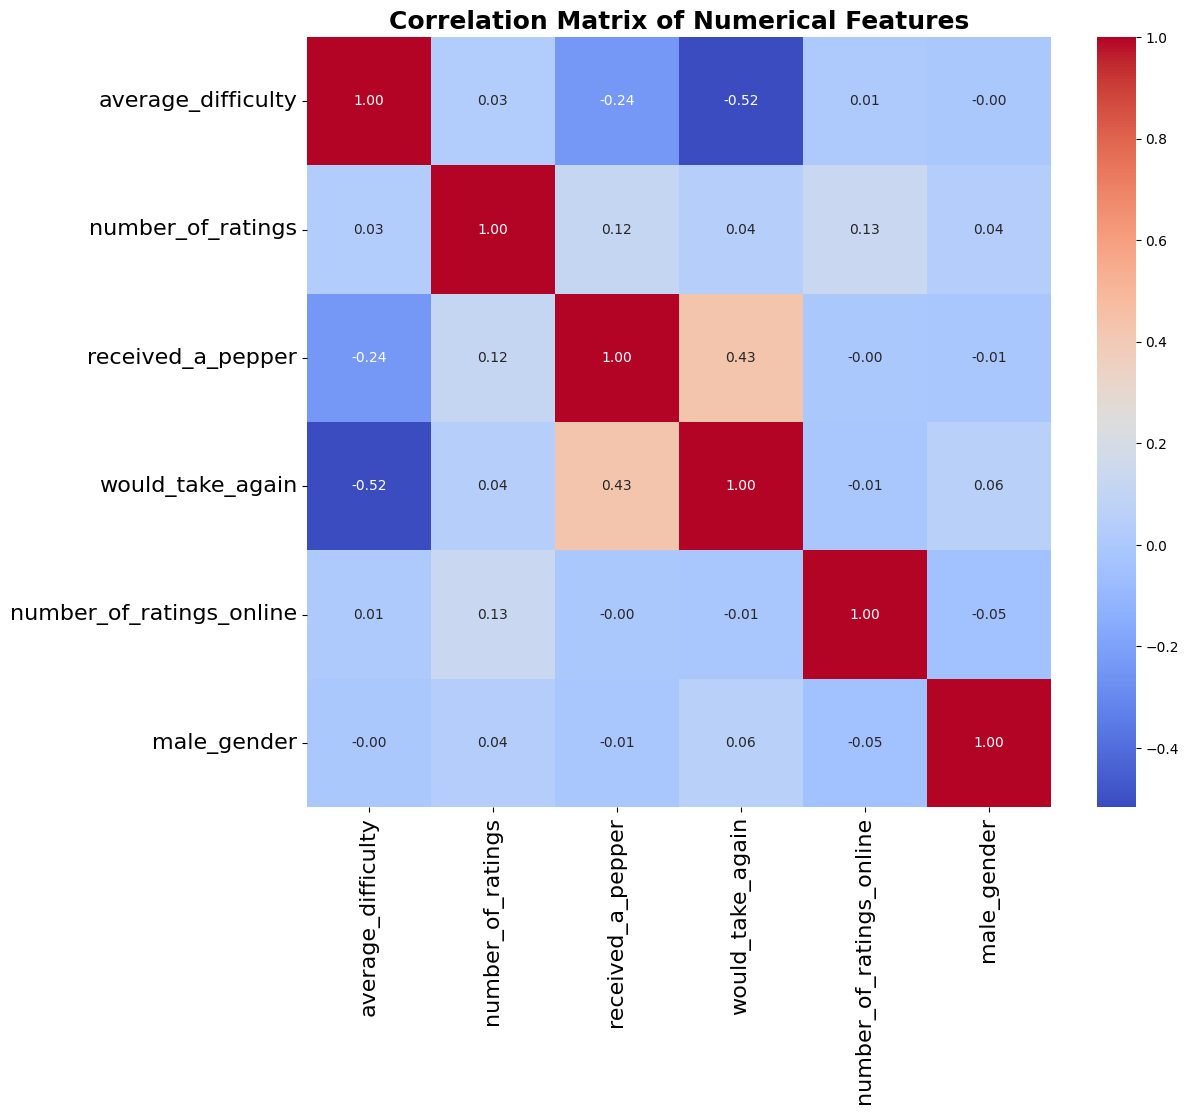

In [25]:
# correlation of features with each other 
corr7_x = x_train_7.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr7_x, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()

The correlation matrix shows no strong pairwise correlations among the numerical predictors, indicating no evidence of multicollinearity. Most correlations are close to zero, including those involving gender, number of ratings, and online ratings. The largest association appears between average difficulty and “would take again” (≈ ~0.52), which reflects a meaningful but expected relationship rather than redundancy. Overall, the predictors capture distinct aspects of professor evaluation and can be included jointly in downstream models without collinearity concerns.

#### KNN Imputation 

Only the variable `would_take_again` contains missing values. Dropping these observations would remove a substantial amount of information, especially because this variable shows a strong association with average rating.

We therefore apply KNN imputation to recover missing values in `would_take_again` by leveraging similarity across the remaining numerical predictors. This method preserves local structure in the data and avoids the strong distributional assumptions imposed by mean or regression based imputation, which is appropriate given the bounded and ordinal nature of the ratings.

The number of neighbors governs the bias variance tradeoff of the imputation. To avoid introducing noise, we tune this parameter within a cross validated pipeline, ensuring that the imputed values improve out of sample performance.

We deliberately do not include a missing indicator for `would_take_again`. Although missingness exhibits statistical correlation with ratings, it reflects survey response behavior rather than any interpretable course characteristic. Including such indicators risks capturing artifacts of the data collection process rather than substantive effects and reduces the interpretability and external validity of the model. For this reason, missingness is handled solely through imputation.

In [26]:
# fixed cross-validation
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number
           )

# pipeline for tuning 
knn_pipe = Pipeline([
    ("imputer", KNNImputer()),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# define objective function for optuna 
def objective(trial):
    # parameters to tune
    params = {
        "imputer__n_neighbors": trial.suggest_int("imputer__n_neighbors", 2, 25),
        "imputer__weights": trial.suggest_categorical("imputer__weights", ["uniform", "distance"]),
        "imputer__add_indicator": trial.suggest_categorical("imputer__add_indicator", [False])
    }

    # clone our model and set parameters 
    pipe = clone(knn_pipe)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters 
    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    # return average RMSE 
    return -scores.mean()

# start the study for knn imputer tuning
study_knn = start_study_optuna(
    objective=objective,
    n_trials=25,
    sampler_seed=n_number,
    direction="minimize"
)

# set the best parameters to the pipeline
knn_pipe.set_params(**study_knn.best_params)

# check the model performance with the best parameters 
score_model(
    knn_pipe,
    x_train_7,
    x_test_7,
    y_train_7,
    y_test_7
)


[I 2026-02-01 05:17:34,873] A new study created in memory with name: no-name-52b14fa0-5301-4eff-bd1b-2225841ecbd6
[I 2026-02-01 05:17:42,244] Trial 0 finished with value: 0.5997043561458753 and parameters: {'imputer__n_neighbors': 8, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.5997043561458753.
[I 2026-02-01 05:17:48,430] Trial 1 finished with value: 0.6005650731967946 and parameters: {'imputer__n_neighbors': 6, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.5997043561458753.
[I 2026-02-01 05:17:54,332] Trial 2 finished with value: 0.603560441405293 and parameters: {'imputer__n_neighbors': 4, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.5997043561458753.
[I 2026-02-01 05:17:59,635] Trial 3 finished with value: 0.598809288282894 and parameters: {'imputer__n_neighbors': 17, 'imputer__weights': 'distance', 'imputer__add_indicator': False}.

Best Params: {'imputer__n_neighbors': 20, 'imputer__weights': 'uniform', 'imputer__add_indicator': False}


{'Training RMSE': 0.5832040230289456,
 'Training R2': 0.6018545990988104,
 'Testing RMSE': 0.5835517487571195,
 'Testing R2': 0.615713129799931}

The tuned preprocessing pipeline shows stable cross-validation performance. The best Optuna trial (trial 15) achieves a mean CV RMSE of ~0.584. The train and test results are also consistent, RMSE is 0.5832 on training and ~0.584 on testing, R² is ~0.6019 on training and ~0.62 on testing. This alignment suggests good generalization and no clear overfitting.

We use this tuned preprocessing plus linear regression setup as our baseline. It gives a fair reference point because the preprocessing is selected using cross-validation, so the baseline reflects expected out-of-sample behavior.

Next, we compare the tuned KNN-based imputation strategy against simpler imputation methods. In particular, we evaluate whether replacing KNN imputation with less complex approaches, such as mean or median imputation, leads to comparable out-of-sample performance. This comparison allows us to assess whether the additional complexity of KNN imputation is justified, or whether simpler imputers are sufficient for this problem.

In [27]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for comparison
pipelines = {
    "KNNImputer (tuned)": Pipeline([
        # imputer 
        ("imputer", KNNImputer(n_neighbors=20, 
                               weights="uniform", 
                               add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),

        # model 
        ("model", LinearRegression())
    ]),

    "SimpleImputer (mean)": Pipeline([
        ("imputer", SimpleImputer(strategy="mean", 
                                  add_indicator=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "SimpleImputer (median)": Pipeline([
        ("imputer", SimpleImputer(strategy="median", 
                                  add_indicator=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
}

# compare the pipelines
rows = []
for name, pipe in pipelines.items():
    results = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_imputers_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", 
                   ascending= True)
      .reset_index(drop=True)
)

# check the results
compare_imputers_df

model   R2_mean  RMSE_mean
0      KNNImputer (tuned)  0.600983   0.583534
1    SimpleImputer (mean)  0.561377   0.611883
2  SimpleImputer (median)  0.551823   0.618515

The comparison confirms that KNN imputation provides a clear advantage over simpler imputation strategies. The tuned KNN imputer achieves the best cross-validation performance, with an RMSE of ~0.584 and an R² of 0.601. In contrast, both mean and median imputation lead to noticeably worse results, with higher RMSE and lower R².

This gap indicates that missing values in `would_take_again` are not random and that borrowing information from similar observations improves predictive accuracy. Simpler imputers fail to capture this structure and introduce additional noise, resulting in inferior out-of-sample performance.

Given these results, we retain the tuned KNN imputation strategy as part of the preprocessing pipeline.

Next, we move to regularized modeling by fitting a Lasso regression on top of this optimized preprocessing setup. The goal is to assess whether introducing sparsity can simplify the model and improve interpretability without sacrificing out-of-sample performance.

#### Lasso Regression

In [28]:
# model with all variables 
# pipeline for Lasso model
pipeline_q7 = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False
                           )),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = 5, 
        random_state = n_number,
        alphas= 100, 
        max_iter= 10000
    ))
])

# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# run cross-validation
cv_results_raw_7 = cross_validate(
    pipeline_q7,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results 
cv_results_7 = [{
    "model": "LassoCV (all features)", 
    "R2_mean": cv_results_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7["test_neg_root_mean_squared_error"]).mean()
}]

# save to dataframe for comparison later 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values("RMSE_mean").reset_index(drop = True)

# check 
compare_models_q7_df

model   R2_mean  RMSE_mean
0  LassoCV (all features)  0.600965   0.583548

In [29]:
# check the model on test data 
score_model(pipeline_q7, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

{'Training RMSE': 0.5832235479741611,
 'Training R2': 0.6018279398270583,
 'Testing RMSE': 0.5836519633488005,
 'Testing R2': 0.615581129651979}

The Lasso model achieves nearly identical cross-validated performance compared to the baseline. The change in RMSE is negligible and within expected sampling variability. This suggests that the baseline model already captures the dominant linear relationships in the data, and additional regularization does not provide a meaningful predictive advantage.

The value of Lasso in this setting is therefore interpretability rather than accuracy. By shrinking weaker coefficients toward zero, it confirms that only a small subset of predictors contributes materially to the model, while maintaining essentially the same out-of-sample performance.

In [30]:
# extract feature weights from the model
model = pipeline_q7.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# check 
weights_df_7

tag    weight  abs_weight
3          would_take_again  0.457011    0.457011
0        average_difficulty -0.270821    0.270821
2         received_a_pepper  0.117891    0.117891
1         number_of_ratings  0.016726    0.016726
5               male_gender -0.007145    0.007145
4  number_of_ratings_online -0.000000    0.000000

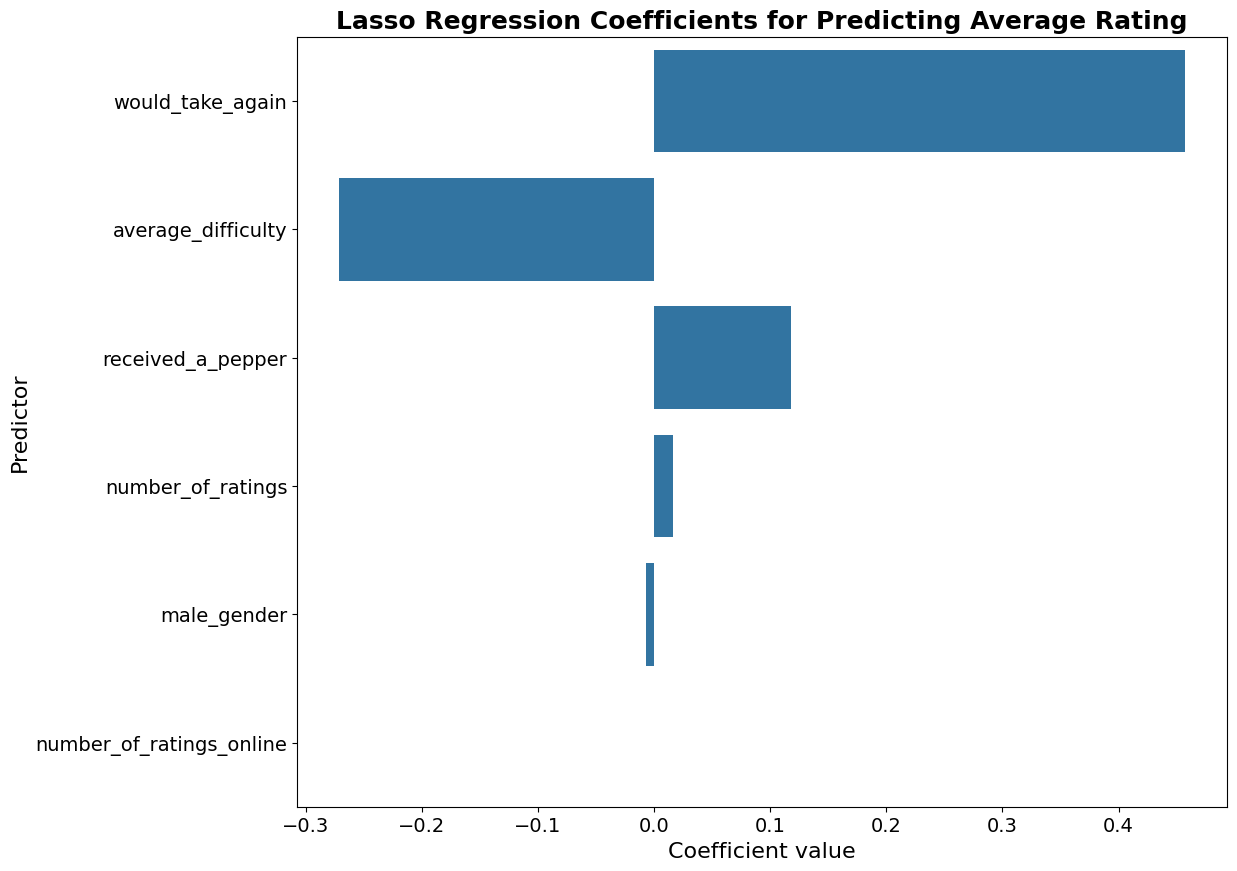

In [31]:
# plot weights of the multiple linear regression model 
# figure size 
plt.figure(figsize = (12, 10))

# bar plot 
sns.barplot(y = weights_df_7["tag"], 
        x = weights_df_7["weight"])

# aesthetics
# title 
plt.title("Lasso Regression Coefficients for Predicting Average Rating", 
          fontweight="bold", 
          fontsize=18)

# axis labels
plt.xlabel("Coefficient value", fontsize=16)
plt.ylabel("Predictor", fontsize=16)

# ticks
plt.tick_params(axis="both", labelsize=14)

# show plot
plt.show()

To focus the model on meaningful predictors, we retain variables whose absolute standardized coefficients exceed 5 percent. This cutoff removes predictors with negligible contribution while keeping variables that materially affect predicted ratings.

Based on the Lasso results, three variables meet this criterion.

`would_take_again (0.456)`
- This is the strongest positive predictor. Professors whom students are willing to take again receive substantially higher ratings. This variable captures core teaching quality and overall student satisfaction.

`average_difficulty (-0.271)`
- This shows a strong negative relationship. Higher perceived difficulty is associated with lower ratings, even after controlling for other factors. This suggests that difficulty directly shapes student evaluations.

`received_a_pepper (0.119)`
- This has a moderate positive effect. Perceived attractiveness correlates with higher ratings, but the magnitude is much smaller than the effect of teaching related variables.

All remaining variables, including gender, number of ratings, and online rating volume, have coefficients close to zero and are excluded. Their limited weights indicate minimal incremental predictive value once the main drivers are accounted for.

This selection step yields a simpler and more interpretable model driven primarily by student experience and course perception rather than demographic or exposure related noise. We now evaluate the performance of this reduced model.

In [32]:
# select features with |weight| >= 0.05
selected_features = (
weights_df_7
.loc[weights_df_7["abs_weight"] >= 0.05, "tag"]
.tolist()
)

# reduce training data 
x_train_reduced_7 = x_train_7[selected_features]
x_test_reduced_7 = x_test_7[selected_features]

# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# pipeline for model 
pipeline_q7_reduced = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False)),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = cv, 
        random_state = n_number,
        alphas = 100, 
        max_iter= 10000
    ))
])

# run cross-validation
cv_results_raw_7_reduced = cross_validate(
    pipeline_q7_reduced,
    x_train_reduced_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": f"LassoCV | {len(x_train_reduced_7.columns)} features",
    "R2_mean": cv_results_raw_7_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7_reduced["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df

model   R2_mean  RMSE_mean
0    LassoCV | 3 features  0.618688   0.570418
1  LassoCV (all features)  0.600965   0.583548

In [33]:
print("Model performance with all features:\n")
# check the model on test data 
score_model(pipeline_q7, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

Model performance with all features:



{'Training RMSE': 0.5832235479741611,
 'Training R2': 0.6018279398270583,
 'Testing RMSE': 0.5836519633488005,
 'Testing R2': 0.615581129651979}

In [34]:
print("Model performance with the most important features:\n")
# check on test data again 
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7, 
            y_test_7)

Model performance with the most important features:



{'Training RMSE': 0.5700314167173207,
 'Training R2': 0.6196369990342151,
 'Testing RMSE': 0.5689893659748712,
 'Testing R2': 0.6346533780129392}

In [35]:
# final model standardized weights
# extract feature weights from the model
final_model_q7 = pipeline_q7_reduced.named_steps["model"]

# feature names
feature_names_final = x_train_reduced_7.columns.to_list()
# coefficients
coef_final = final_model_q7.coef_

# build dataframe
weights_df_7_final = pd.DataFrame({
    "tag": feature_names_final,
    "weight": coef_final
})

# sort by absolute weight
weights_df_7_final["abs_weight"] = weights_df_7_final["weight"].abs()
weights_df_7_final = weights_df_7_final.sort_values("abs_weight", ascending=False)

# check 
weights_df_7_final

tag    weight  abs_weight
0    would_take_again  0.532796    0.532796
1  average_difficulty -0.192468    0.192468
2   received_a_pepper  0.098855    0.098855

The reduced Lasso model consistently outperforms the full-feature baseline across all evaluation settings. In cross-validation, RMSE decreases from ~0.584 to ~0.57 and R² increases from ~0.601 to ~0.619. 

The same pattern holds on the hold-out set. Test RMSE drops from ~0.584 to ~0.569, while test R² increases from ~0.616 to ~0.635. Training and testing metrics remain closely aligned, suggesting that the performance gain is not driven by overfitting.

These results indicate that several predictors in the full model contribute noise rather than signal. Removing them improves generalization and yields a simpler model with better predictive accuracy.

Overall, the reduced model achieves a better tradeoff between performance and complexity. It shows that ratings are primarily driven by teaching experience and course perception, while demographic and exposure-related variables add little once the core predictors are included.

### Extra: Feature Engineering
#### Do ratings change linearly with difficulty and volume?

To test for nonlinear relationships, we introduced polynomial and logarithmic transformations of selected predictors. Because these transformations induce multicollinearity, we employed ElasticNetCV, which combines L1 and L2 regularization to stabilize coefficient estimates while controlling overfitting.

In [36]:
# transform average difficulty and number of ratings 
# average difficulty in a square 
x_train_7["average_difficulty^2"] = np.square(x_train_7["average_difficulty"])
x_test_7["average_difficulty^2"] = np.square(x_test_7["average_difficulty"])

# log number of ratings 
x_train_7["number_of_ratings_log"] = np.log(1 + x_train_7["number_of_ratings"])
x_test_7["number_of_ratings_log"] = np.log(1 + x_test_7["number_of_ratings"])
    
x_train_7["number_of_ratings_online_log"] = np.log(1 + x_train_7["number_of_ratings_online"])

x_test_7["number_of_ratings_online_log"] = np.log(1 + x_test_7["number_of_ratings_online"])

In [37]:
# fixed cv
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline to test transformations
pipeline_q7_transform = Pipeline([
    # null values imputer 
    ("imputer", KNNImputer(n_neighbors= 20, 
                           weights = "uniform", 
                           add_indicator= False)),
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])

# run cross_validation
cv_results_transformation_raw_7 = cross_validate(
    pipeline_q7_transform, 
    x_train_7, 
    y_train_7, 
    cv = cv, 
    scoring = ("r2", "neg_root_mean_squared_error"), 
    return_train_score = False, 
    return_estimator = True
)

# save results 
cv_results_transformation_7 = {
    "R2_mean": cv_results_transformation_raw_7["test_r2"].mean(),
    "RMSE_mean": -cv_results_transformation_raw_7["test_neg_root_mean_squared_error"].mean()

}

# save results 
cv_results_7.append({
    "model": "ElasticNetCV (with transformations)",
    "R2_mean": cv_results_transformation_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_transformation_raw_7["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df



model   R2_mean  RMSE_mean
0                 LassoCV | 3 features  0.618688   0.570418
1  ElasticNetCV (with transformations)  0.616115   0.572340
2               LassoCV (all features)  0.600965   0.583548

In [38]:
# check on test data
print("Reduced LassoCV performance on test data:\n")
score_model(pipeline_q7_transform, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

Reduced LassoCV performance on test data:



{'Training RMSE': 0.5708690969950916,
 'Training R2': 0.6185182652653858,
 'Testing RMSE': 0.5682955129593896,
 'Testing R2': 0.6355438772291948}

In [39]:
# results of reduced model on test data 
print("ElasticNetCV with transformations performance on test data:\n")
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7, 
            y_test_7)

ElasticNetCV with transformations performance on test data:



{'Training RMSE': 0.5700314167173207,
 'Training R2': 0.6196369990342151,
 'Testing RMSE': 0.5689893659748712,
 'Testing R2': 0.6346533780129392}

The ElasticNet model with nonlinear transformations does not meaningfully outperform the reduced Lasso model on either cross-validation or test data. Performance differences are within noise, suggesting that most predictive power is already captured by the reduced feature set.

Next, we examine coefficient magnitudes to identify and remove insignificant variables. We also test whether retaining only the squared difficulty term improves model parsimony and interpretability relative to the linear difficulty term.

In [40]:
# extract feature weights from the model
model = pipeline_q7_transform.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_7 = weights_df_7.drop(columns="abs_weight").reset_index(drop=True)

# check 
weights_df_7

tag    weight
0              would_take_again  0.460393
1          average_difficulty^2 -0.436121
2            average_difficulty  0.196997
3             received_a_pepper  0.149762
4         number_of_ratings_log  0.010239
5  number_of_ratings_online_log -0.009939
6      number_of_ratings_online  0.007876
7                   male_gender  0.005482
8             number_of_ratings  0.000644

The coefficient magnitudes from the ElasticNet model confirm the expected structure:
- `would_take_again` remains the dominant predictor.
- `average_difficulty²` has a strong negative coefficient, indicating a nonlinear relationship between difficulty and rating.
- The linear `average_difficulty` term is substantially weaker once the squared term is included.

Other variables have negligible coefficients and contribute little to predictive performance. Given the clear nonlinear effect of difficulty, we remove the `linear average_difficulty` term and retain only its squared transformation. This results in a parsimonious model with three primary predictors.

Next, we assess whether introducing the squared term materially increases multicollinearity. If multicollinearity remains controlled, we refit the model using LassoCV rather than ElasticNetCV, since Lasso provides comparable regularization with lower computational cost.

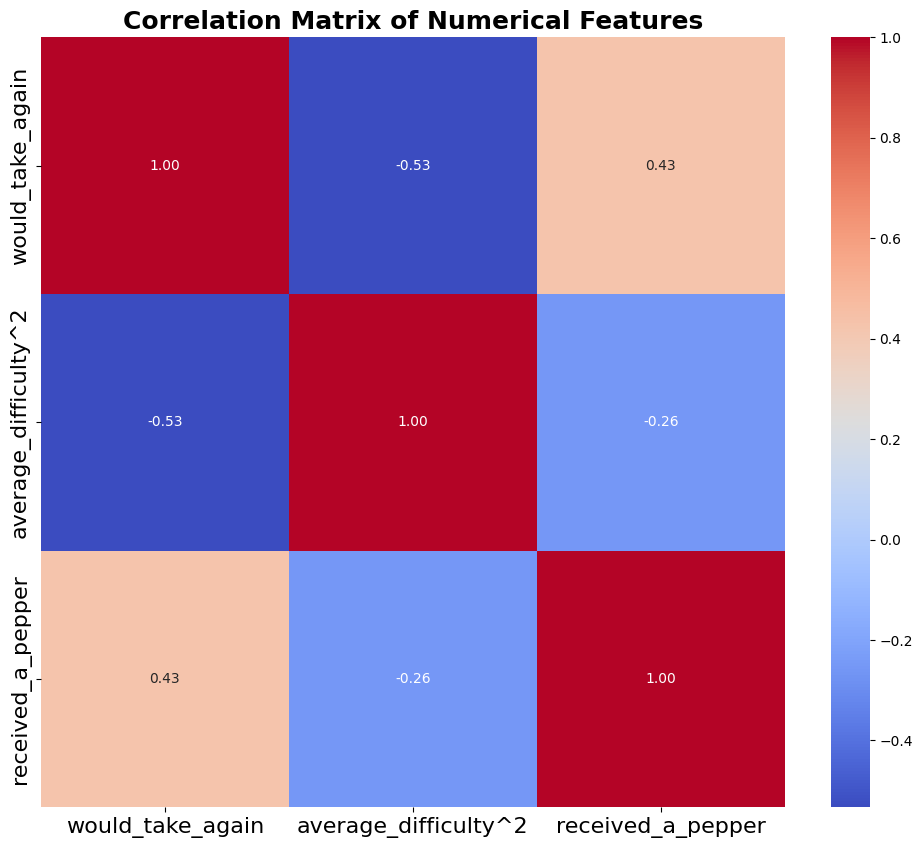

In [41]:
# select features with |weight| >= 0.05
selected_features = ["would_take_again", 
                     "average_difficulty^2", 
                     "received_a_pepper"]

# reduce training data 
x_train_transformation_reduced_7 = x_train_7[selected_features]
x_test_transformation_reduced_7 = x_test_7[selected_features]


# correlations between predictors 
corr_pred_transformation_reduced_7 = x_train_transformation_reduced_7.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_pred_transformation_reduced_7, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix for the reduced feature set shows no evidence of severe multicollinearity:
- Correlations are all well below common concern thresholds of |0.7-0.8|.
- The strongest relationship is between `would_take_again` and `average_difficulty²` at -0.53, which reflects a meaningful behavioral association rather than redundancy.
- `received_a_pepper` shows only moderate correlation with the other predictors.

These results indicate that introducing the squared difficulty term does not materially inflate multicollinearity once the linear difficulty term is removed.
Given this, regularization via ElasticNet is no longer strictly necessary, and we proceed by refitting the model using LassoCV for improved simplicity and computational efficiency.

In [43]:
# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# pipeline for model 
pipeline_q7_transformation_reduced = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False)),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = cv, 
        random_state = n_number,
        alphas = 100, 
        max_iter= 10000
    ))
])

# run cross-validation
cv_results_raw_7_transformation_reduced = cross_validate(
    pipeline_q7_transformation_reduced,
    x_train_transformation_reduced_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "LassoCV | transformation + 3 features",
    "R2_mean": cv_results_raw_7_transformation_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7_transformation_reduced["test_neg_root_mean_squared_error"]).mean()
    })

# show as a dataframe
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)
compare_models_q7_df


model   R2_mean  RMSE_mean
0  LassoCV (with transformations and reduced vari...  0.622286   0.567660
1              LassoCV | transformation + 3 features  0.622286   0.567660
2                               LassoCV | 3 features  0.618688   0.570418
3                ElasticNetCV (with transformations)  0.616115   0.572340
4                             LassoCV (all features)  0.600965   0.583548

In [44]:
# LassoCV (reduced features) performance on the test data
print("LassoCV (reduced features) performance on the test data\n")
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7,
            y_test_7)

LassoCV (reduced features) performance on the test data



{'Training RMSE': 0.5700314167173207,
 'Training R2': 0.6196369990342151,
 'Testing RMSE': 0.5689893659748712,
 'Testing R2': 0.6346533780129392}

In [45]:
# LassoCV (transformation + reduced features) performance on the test data
print("LassoCV (transformation + reduced features) performance on the test data:\n")
score_model(pipeline_q7_transformation_reduced, 
            x_train_transformation_reduced_7, 
            x_test_transformation_reduced_7, 
            y_train_7, 
            y_test_7)

LassoCV (transformation + reduced features) performance on the test data:



{'Training RMSE': 0.5662370437407515,
 'Training R2': 0.6246838636158834,
 'Testing RMSE': 0.5613960622383344,
 'Testing R2': 0.644339593338629}

In [46]:
# final model weights 
# extract feature weights from the model
model_poly = pipeline_q7_transformation_reduced.named_steps["model"]

# feature names
feature_names_poly = x_train_transformation_reduced_7.columns.to_list()
# coefficients
coef_poly = model_poly.coef_

# build dataframe
weights_df_7_poly = pd.DataFrame({
    "tag": feature_names_poly,
    "weight": coef_poly
})

# sort by absolute weight
weights_df_7_poly["abs_weight"] = weights_df_7_poly["weight"].abs()
weights_df_7_poly = weights_df_7_poly.sort_values("abs_weight", ascending=False)

# check 
weights_df_7_poly

tag    weight  abs_weight
0      would_take_again  0.504186    0.504186
1  average_difficulty^2 -0.224109    0.224109
2     received_a_pepper  0.105865    0.105865

Cross-validation results show that introducing nonlinear transformations improves model performance. The best cross-validated specification, LassoCV with transformations and reduced features, achieves an R² of approximately ~0.622 and an RMSE of about ~0.568, outperforming both the linear reduced model with an RMSE of roughly ~0.570 and the full linear model with an RMSE near ~0.584. ElasticNetCV produces nearly identical cross-validation metrics, indicating that multicollinearity is adequately controlled and that Lasso regularization is sufficient.

Evaluation on the held-out test set confirms this pattern. The reduced Lasso model attains a testing RMSE of about ~0.567 and an R² of approximately ~0.635, while the transformed reduced Lasso model further improves performance with a testing RMSE of roughly ~0.561 and an R² near 0.644. These results motivate a final assessment of interaction effects to determine whether any additional structure remains unexploited.

#### Interactions

In [47]:
# create interaction variables 
# would take gain and difficulty 
x_train_7["wta_x_difficulty"] = (
x_train_7["would_take_again"] * x_train_7["average_difficulty"]
)

x_test_7["wta_x_difficulty"] = (
x_test_7["would_take_again"] * x_test_7["average_difficulty"]
)

x_train_7["wta_x_difficulty2"] = (
x_train_7["would_take_again"] * x_train_7["average_difficulty^2"]
)

x_test_7["wta_x_difficulty2"] = (
x_test_7["would_take_again"] * x_test_7["average_difficulty^2"]
)

# pepper and would take again 
x_train_7["pepper_x_wta"] = (
x_train_7["received_a_pepper"] * x_train_7["would_take_again"]
)

x_test_7["pepper_x_wta"] = (
x_test_7["received_a_pepper"] * x_test_7["would_take_again"]
)

# would take again and log_number of ratings 
x_train_7["wta_x_log_number_of_ratings"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])
x_train_7["wta_x_log_number_of_ratings"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])

x_train_7["wta_x_log_number_of_ratings_online"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])
x_train_7["wta_x_log_number_of_ratings_online"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])

x_test_7["wta_x_log_number_of_ratings"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])
x_test_7["wta_x_log_number_of_ratings"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])

x_test_7["wta_x_log_number_of_ratings_online"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])
x_test_7["wta_x_log_number_of_ratings_online"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])


In [48]:
# fixed cv
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline to test interactions
pipeline_q7_interactions = Pipeline([
    # null values imputer 
    ("imputer", KNNImputer(n_neighbors= 20, 
                           weights = "uniform", 
                           add_indicator= False)),
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])

# run cross_validation
cv_results_interactions_raw_7 = cross_validate(
    pipeline_q7_interactions, 
    x_train_7, 
    y_train_7, 
    cv = cv, 
    scoring = ("r2", "neg_root_mean_squared_error"), 
    return_train_score = False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "ElasticNet CV (interactions)",
    "R2_mean": cv_results_interactions_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_interactions_raw_7["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df




model   R2_mean  RMSE_mean
0  LassoCV (with transformations and reduced vari...  0.622286   0.567660
1              LassoCV | transformation + 3 features  0.622286   0.567660
2                       ElasticNet CV (interactions)  0.622098   0.567843
3                               LassoCV | 3 features  0.618688   0.570418
4                ElasticNetCV (with transformations)  0.616115   0.572340
5                             LassoCV (all features)  0.600965   0.583548

In [49]:
# ElasticNet CV (interactions) performance on the test data:
print("ElasticNet CV (interactions) performance on the test data:")
score_model(pipeline_q7_interactions, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

ElasticNet CV (interactions) performance on the test data:


{'Training RMSE': 0.5666886938255306,
 'Training R2': 0.6240848947889226,
 'Testing RMSE': 0.5659883083765145,
 'Testing R2': 0.6384971573353835}

In [50]:
# Lasso CV (transformation + reduced variables) performance on the test data:
print("Lasso CV (transformation + reduced variables) performance on the test data:")
score_model(pipeline_q7_transformation_reduced,
            x_train_transformation_reduced_7,
            x_test_transformation_reduced_7,
            y_train_7, 
            y_test_7)

Lasso CV (transformation + reduced variables) performance on the test data:


{'Training RMSE': 0.5662370437407515,
 'Training R2': 0.6246838636158834,
 'Testing RMSE': 0.5613960622383344,
 'Testing R2': 0.644339593338629}

Cross-validation results show that the full interaction-based Elastic Net model performs no better than a much simpler Lasso model with nonlinear transformations and only three features. Both achieve nearly identical cross-validated RMSE (~ 0.568) and R² (~ 0.622), despite the interaction model being substantially more complex.

This is already a warning signal. When a full interaction model fails to outperform a reduced transformed model during cross - validation, it suggests that interaction terms are not introducing new signal, but instead re-expressing information already captured by simpler nonlinear transformations.

This conclusion is reinforced on the test set. The interaction-based Elastic Net model generalizes worse, with a higher testing RMSE (~ 0.566) and lower R² (~ 0.638), compared to the transformed reduced Lasso model, which achieves a lower testing RMSE (~ 0.561) and higher R² (~ 0.644).

Importantly, the interaction-based model increases complexity along several dimensions simultaneously:
- Explicit interaction terms inflate the feature space
- Elastic Net regularization adds tuning complexity
- The model retains more predictors than the reduced alternative
- Multicollinearity is reintroduced by construction

Yet this added complexity yields neither improved cross-validated performance nor better generalization.

In [54]:
# extract feature weights from the model
model = pipeline_q7_interactions.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# check 
weights_df_7

tag    weight  abs_weight
6                 average_difficulty^2 -0.410366    0.410366
3                     would_take_again  0.366215    0.366215
2                    received_a_pepper  0.274678    0.274678
11                        pepper_x_wta -0.141697    0.141697
10                   wta_x_difficulty2  0.125936    0.125936
8         number_of_ratings_online_log -0.027210    0.027210
12         wta_x_log_number_of_ratings  0.019239    0.019239
9                     wta_x_difficulty  0.010260    0.010260
7                number_of_ratings_log  0.008993    0.008993
13  wta_x_log_number_of_ratings_online  0.007852    0.007852
1                    number_of_ratings  0.006043    0.006043
5                          male_gender  0.002614    0.002614
0                   average_difficulty -0.000000    0.000000
4             number_of_ratings_online  0.000000    0.000000

In [60]:
# cv
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
elasticnetcv_q7_comparisons_interactions = []

# filter-out variables 
keep_features_interactions = weights_df_7[
    weights_df_7["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["tag"].tolist()

# create train and test samples 
x_train_reduced_7_interactions = x_train_7[keep_features_interactions]

x_test_reduced_10_interactions = x_train_7[keep_features_interactions]

# loop to drop each variable 1 by one 
for k in range(len(keep_features_interactions), 0, -1):
    keep_pol_interactions = keep_features_interactions[:k]

    x_train_reduced_7_interactions = x_train_reduced_7_interactions[keep_pol_interactions]

    # pipeline to test interactions
    pipeline = Pipeline([
    # null values imputer 
    ("imputer", KNNImputer(n_neighbors= 20, 
                           weights = "uniform", 
                           add_indicator= False)),
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])
    
    results_reduced_7_interactions = cross_validate(
        pipeline,
        x_train_reduced_7_interactions,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    elasticnetcv_q7_comparisons_interactions.append({
    "model": f"ElasticNetCV | top-{k} by |w|",
    "R2_mean": results_reduced_7_interactions["test_r2"].mean(),
    "RMSE_mean": (-results_reduced_7_interactions["test_neg_root_mean_squared_error"]).mean()}
)
    
# dataframe 
drop_df_7_interactions = (
            pd.DataFrame(elasticnetcv_q7_comparisons_interactions)
            .sort_values("RMSE_mean", ascending=False)
            .reset_index(drop=True))
drop_df_7_interactions

model   R2_mean  RMSE_mean
0  ElasticNetCV | top-1 by |w|  0.403386   0.713589
1  ElasticNetCV | top-2 by |w|  0.565713   0.608763
2  ElasticNetCV | top-3 by |w|  0.622285   0.567661
3  ElasticNetCV | top-4 by |w|  0.622612   0.567505
4  ElasticNetCV | top-5 by |w|  0.626311   0.564687

In [61]:
# best models dataframe
compare_models_q7_df


model   R2_mean  RMSE_mean
0  LassoCV (with transformations and reduced vari...  0.622286   0.567660
1              LassoCV | transformation + 3 features  0.622286   0.567660
2                       ElasticNet CV (interactions)  0.622098   0.567843
3                               LassoCV | 3 features  0.618688   0.570418
4                ElasticNetCV (with transformations)  0.616115   0.572340
5                             LassoCV (all features)  0.600965   0.583548

No alternative specification provides a meaningful improvement over the transformed Lasso model with three features. All competing models either show equivalent cross-validated performance within noise or introduce additional complexity without improving generalization. As a result, this model is selected as the final specification under a balanced objective that prioritizes both predictive performance and parsimony.

If the modeling objective were instead shifted toward pure performance maximization, interpretability and sparsity would no longer be binding constraints. In that case, more flexible nonlinear models such as gradient-boosted trees could be considered to assess the upper bound of achievable performance. However, under the current objective, the transformed three-feature Lasso model represents the most appropriate and defensible choice.

### Extra: Prediction Accuracy Optimization

##### LightGBM

We first evaluate whether LightGBM benefits from our tuned KNN imputation compared to simpler missing-value strategies. Specifically, we compare four preprocessing options, tuned KNN imputation, mean imputation, median imputation, and no imputation. For each option, we measure cross-validated RMSE and R² using the same 5-fold split to ensure a fair comparison.

After selecting the imputation strategy that yields the best cross-validated RMSE, we fix this preprocessing choice and tune the LightGBM hyperparameters with Optuna. This two-stage approach separates preprocessing selection from model tuning and ensures that hyperparameter optimization is performed on the strongest preprocessing setup.

In [62]:
# fixed cross-validation 
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipelines for comparison
pipelines_q7_lgbm = {
    "LGBMRegressor (no imputation)": Pipeline([
        # scaler 
        ("scaler", StandardScaler()), 

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1))
    ]), 

    "LGBMRegreessor (KNNImputer)": Pipeline([
        # imputer
        ("imputer", KNNImputer(n_neighbors=20, 
                               weights="uniform", 
                               add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]),

    "LGBMRegressor (SimpleImputer - mean)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(strategy="mean", 
                                  add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]), 

    "LGBMRegressor (SimpleImputer - median)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(strategy="median", 
                                  add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]),
}

# compare and cross_validate the pipelines 
rows_lgbm = []
for name, pipe in pipelines_q7_lgbm.items():
    results_lgbm = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows_lgbm.append({
        "model": name,
        "R2_mean": results_lgbm["test_r2"].mean(),
        "RMSE_mean": (-results_lgbm["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_lgbm_df = (
    pd.DataFrame(rows_lgbm)
      .sort_values("RMSE_mean", 
                   ascending= True)
      .reset_index(drop=True)
)

# check the results
compare_lgbm_df

model   R2_mean  RMSE_mean
0  LGBMRegressor (SimpleImputer - median)  0.636778   0.556684
1    LGBMRegressor (SimpleImputer - mean)  0.636719   0.556722
2           LGBMRegressor (no imputation)  0.636472   0.556917
3             LGBMRegreessor (KNNImputer)  0.629054   0.562570

Cross-validation results indicate that LightGBM performs best without explicit imputation. Models using no imputation achieve an RMSE of approximately ~0.557 with an R² around ~0.636, which is statistically indistinguishable from mean and median imputation variants (RMSE  ~ 0.556 - 0.557).

While mean and median imputation yield marginally lower RMSE values, the differences are negligible and fall well within cross-validation noise. In contrast, KNN imputation leads to a noticeable degradation in performance, increasing RMSE to approximately ~0.563.

Because LightGBM natively handles missing values by learning optimal split directions, explicit imputation does not introduce additional signal and may remove informative missingness patterns. Given the lack of meaningful performance gains and the added complexity introduced by imputation, we proceed without explicit imputation for LightGBM.

This choice preserves model simplicity while maintaining optimal predictive performance.

In [63]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM 
lgbm_pipe_q7 = Pipeline([
    # scaler 
    ("scaler", StandardScaler()),
    
    # model itself 
    ("model", LGBMRegressor(
        objective = "regression", 
        metric = "rmse", 
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    # parameters to tune
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 200, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone pipeline and set parameters
    pipe = clone(lgbm_pipe_q7)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters
    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# run optuna
study_lgbm = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,    # number of trials 
    sampler_seed=n_number,
    direction="minimize"
)

[I 2026-02-01 06:33:04,587] A new study created in memory with name: no-name-b3c640ae-bf37-4904-97c0-2f5db06dbff1
[I 2026-02-01 06:33:05,024] Trial 0 finished with value: 0.5549320653788052 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 738, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__colsample_bytree': 0.6408023967045857, 'model__reg_alpha': 5.3874727250769205e-06, 'model__reg_lambda': 0.06280715236841564, 'model__min_split_gain': 0.3289713088537308}. Best is trial 0 with value: 0.5549320653788052.
[I 2026-02-01 06:33:07,590] Trial 1 finished with value: 0.5603152749705915 and parameters: {'model__num_leaves': 63, 'model__max_depth': 10, 'model__min_child_samples': 192, 'model__n_estimators': 1000, 'model__learning_rate': 0.1225226099530034, 'model__subsample': 0.6806109309369683, 'model__colsample_bytree': 0.6286895037328117, 'model__reg_alpha': 0.0022086296848811

Best Params: {'model__num_leaves': 17, 'model__max_depth': 14, 'model__min_child_samples': 34, 'model__n_estimators': 1481, 'model__learning_rate': 0.0223505675780278, 'model__subsample': 0.6789874141084263, 'model__colsample_bytree': 0.7391451468449096, 'model__reg_alpha': 1.669393824890191e-06, 'model__reg_lambda': 0.03453316496180948, 'model__min_split_gain': 0.048604513753357725}


In [64]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe_q7.set_params(**study_lgbm.best_params)

cv_results_raw_lgbm = cross_validate(
    lgbm_pipe_q7,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_7.append({
    "model": "LightGBM (no imputation)",
    "R2_mean": cv_results_raw_lgbm["test_r2"].mean(),
    "RMSE_mean": -cv_results_raw_lgbm["test_neg_root_mean_squared_error"].mean()
})

# add to comparison dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


model   R2_mean  RMSE_mean
0                           LightGBM (no imputation)  0.640371   0.553919
1  LassoCV (with transformations and reduced vari...  0.622286   0.567660
2              LassoCV | transformation + 3 features  0.622286   0.567660
3                       ElasticNet CV (interactions)  0.622098   0.567843
4                               LassoCV | 3 features  0.618688   0.570418
5                ElasticNetCV (with transformations)  0.616115   0.572340
6                             LassoCV (all features)  0.600965   0.583548

In [65]:
# performance of LightGBM on test data:
print("LightGBM model performance on test data:\n")
score_model(
    lgbm_pipe_q7,
    x_train_7,
    x_test_7,
    y_train_7,
    y_test_7
)

LightGBM model performance on test data:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.541147251181569,
 'Training R2': 0.6572072764397039,
 'Testing RMSE': 0.5521130903365432,
 'Testing R2': 0.6560044021120512}

In [66]:
# performance of LassoCV (transformation + reduced variables) on test data:
print("performance of LassoCV (transformation + reduced variables) on test data:\n")
score_model(
    pipeline_q7_transformation_reduced,
    x_train_transformation_reduced_7,
    x_test_transformation_reduced_7,
    y_train_7,
    y_test_7
)

performance of LassoCV (transformation + reduced variables) on test data:



{'Training RMSE': 0.5662370437407515,
 'Training R2': 0.6246838636158834,
 'Testing RMSE': 0.5613960622383344,
 'Testing R2': 0.644339593338629}

Cross-validation results show a clear and non-marginal improvement from LightGBM relative to all linear and regularized models. The LightGBM model without imputation achieves a CV RMSE of approximately ~0.554, improving substantially over the best linear specification, whose CV RMSE is around ~0.568. This gain carries over to the test set, where LightGBM attains a testing RMSE of about ~0.552 and an R² of roughly ~0.656, compared to a testing RMSE of approximately ~0.561 and an R² near ~0.644 for the transformed reduced Lasso model. Unlike earlier stages, this improvement is large enough to be considered meaningful and cannot be attributed to noise or minor functional-form adjustments.

Given this clear performance gap, we conclude that LightGBM is able to capture nonlinearities and higher-order interactions that linear models fail to exploit, even after extensive feature engineering. Before proceeding to XGBoost for further performance maximization, we first examine LightGBM feature importance to understand which variables drive these gains and whether the model relies on sensible, interpretable structure rather than spurious interactions.

C:\Users\nyuss\AppData\Local\Temp\ipykernel_29280\2716345585.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_7)


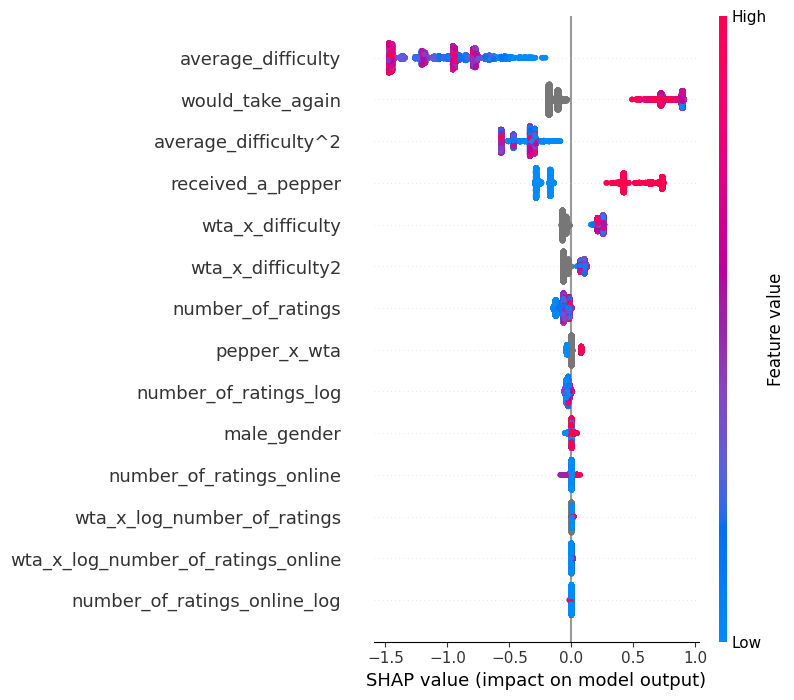

In [67]:
# shapley values
explainer = shap.TreeExplainer(lgbm_pipe_q7.named_steps["model"])
shap_values = explainer.shap_values(x_train_7)   

# plot 
shap.summary_plot(shap_values, x_train_7)

`average_difficulty` is the single strongest driver of predictions. Low difficulty values consistently increase predicted ratings, while high difficulty values decrease them. The wide spread of SHAP values shows a strong nonlinear effect, which LightGBM captures directly through splits rather than relying on engineered polynomial terms.

`would_take_again` is the second most influential feature and has a strong, monotonic positive impact. Higher values reliably push predictions upward across almost all observations, confirming that student willingness to retake a professor is the most stable sentiment signal in the data.

`received_a_pepper`  has a positive but smaller effect. Its SHAP values are more dispersed, indicating that the pepper signal matters, but only conditionally and less consistently than the two dominant variables.

All remaining features, including engineered interactions, squared terms, counts, and demographic indicators, have SHAP values concentrated near zero. They contribute little to predictions once difficulty and willingness to retake are accounted for.

In short, LightGBM’s performance gains are driven almost entirely by three variables: average difficulty, willingness to take the professor again, and pepper status. Everything else is secondary or redundant. Now we will assess Xgboost. 

#### Xgboost 

We now again are going to evaluate Whether Xgboost benefits from our tuned KNN imputation compared to simpler missing-value strategies. As with Lightgbm, we compare four preprocessing options, tuned KNN imputation, mean imputation, median imputation, and no imputation. For each option, we measure cross-validated RMSE and R² using the same 5-fold split to ensure a fair comparison.

After selecting the imputation strategy that yields the best cross-validated RMSE, we fix this preprocessing choice and tune the Xgboost hyperparameters with Optuna. 

In [67]:
# fixed cross-validation 
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipelines for comparison
pipelines_q7_xgboost = {
    "XGBRegressor (no imputation)": Pipeline([
        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity=0,
            n_jobs=1
        ))
    ]), 

    "XGBRegressor (KNNImputer)": Pipeline([
        # imputer
        ("imputer", KNNImputer(
            n_neighbors=20, 
            weights="uniform", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]),

    "XGBRegressor (SimpleImputer - mean)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(
            strategy="mean", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]), 

    "XGBRegressor (SimpleImputer - median)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(
            strategy="median", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]),
}

# compare and cross_validate the pipelines 
rows_xgboost = []
for name, pipe in pipelines_q7_xgboost.items():
    results_xgboost = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows_xgboost.append({
        "model": name,
        "R2_mean": results_xgboost["test_r2"].mean(),
        "RMSE_mean": (-results_xgboost["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_xgboost_df = (
    pd.DataFrame(rows_xgboost)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check the results
compare_xgboost_df


model   R2_mean  RMSE_mean
0           XGBRegressor (no imputation)  0.623180   0.567048
1    XGBRegressor (SimpleImputer - mean)  0.623084   0.567136
2  XGBRegressor (SimpleImputer - median)  0.622830   0.567313
3              XGBRegressor (KNNImputer)  0.606813   0.579235

The best XGBoost specification without imputation achieves a CV RMSE of approximately ~0.567 and an R² of about ~0.623, which is comparable to but slightly worse than LightGBM's CV RMSE of roughly ~0.554. Mean and median imputation lead to nearly identical results, while KNN imputation substantially degrades performance, increasing RMSE to approximately 0.~579.

These results suggest that, similar to LightGBM, XGBoost does not benefit from explicit imputation and may leverage missingness implicitly. 

In [68]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model itself 
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=n_number,
        n_jobs=1,              
        tree_method="hist",
        eval_metric="rmse"
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1.0, 50.0, log=True),
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 5.0),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 200, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),
        "model__colsample_bylevel": trial.suggest_float("model__colsample_bylevel", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 50.0, log=True),

        # split control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    pipe = clone(xgb_pipe)
    pipe.set_params(**params)

    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# run optuna
study_xgb = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)

# after tuning, set best params and cross-validate for R2 + RMSE
xgb_pipe.set_params(**study_xgb.best_params)

# raw results 
cv_results_raw_xgb = cross_validate(
    xgb_pipe,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False,
    return_estimator=True
)

# append the results 
cv_results_7.append({
    "model": "XGBoost",
    "R2_mean": cv_results_raw_xgb["test_r2"].mean(),
    "RMSE_mean": -cv_results_raw_xgb["test_neg_root_mean_squared_error"].mean()
})


# show and save as pdf 
compare_models_q7_df = (pd.DataFrame(cv_results_7).sort_values("RMSE_mean").reset_index(drop=True)
)
compare_models_q7_df


[I 2026-01-25 21:34:56,365] A new study created in memory with name: no-name-b091515e-4b47-4235-8f07-d923b59177b9
[I 2026-01-25 21:34:56,979] Trial 0 finished with value: 0.5559412732941522 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 3.7418704964074134, 'model__gamma': 2.6090390391207032, 'model__n_estimators': 738, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__colsample_bytree': 0.6408023967045857, 'model__colsample_bylevel': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.02406388335281008, 'model__max_delta_step': 2}. Best is trial 0 with value: 0.5559412732941522.
[I 2026-01-25 21:34:59,126] Trial 1 finished with value: 0.5538878694442019 and parameters: {'model__max_depth': 9, 'model__min_child_weight': 42.49859240110514, 'model__gamma': 1.4297819017777784, 'model__n_estimators': 2628, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model_

Best Params: {'model__max_depth': 4, 'model__min_child_weight': 4.830420846165837, 'model__gamma': 0.6268791916067082, 'model__n_estimators': 2823, 'model__learning_rate': 0.0050935955202186, 'model__subsample': 0.6707873089683427, 'model__colsample_bytree': 0.7877809002405042, 'model__colsample_bylevel': 0.8929741163866015, 'model__reg_alpha': 1.6292010203633038, 'model__reg_lambda': 0.08465563648315001, 'model__max_delta_step': 9}


model   R2_mean  RMSE_mean
0                                            XGBoost  0.641070   0.553379
1                           LightGBM (no imputation)  0.640371   0.553919
2     ElasticNetCV (Interactions, reduced variables)  0.625382   0.565384
3                       ElasticNet CV (interactions)  0.622001   0.567917
4  LassoCV (with transformations and reduced vari...  0.620632   0.568949
5  ElasticNetCV (with transformations and reduced...  0.620632   0.568950
6                         LassoCV (reduced features)  0.616401   0.572178
7                ElasticNetCV (with transformations)  0.616248   0.572240
8                             LassoCV (all features)  0.601358   0.583260

Based on cross-validation performance alone, there is no justification to pursue XGBoost further. Although XGBoost marginally outperforms LightGBM in R², the difference in RMSE is negligible, and both models fall well within the same performance range. Given the additional tuning complexity and reduced interpretability of XGBoost, further analysis of its test-set performance or feature importance is unwarranted.

Among nonlinear models, LightGBM offers the best balance of predictive accuracy and practical interpretability, achieving strong performance while still allowing partial explanation through feature importance and SHAP values. When performance is the sole objective, LightGBM is therefore the preferred model.

From a perspective that balances explainability and performance, the LassoCV model with nonlinear transformations and a reduced feature set remains the most appropriate choice. It delivers competitive predictive accuracy relative to other linear specifications while maintaining transparent and stable coefficient interpretations.

## Q8 - Build a regression model predicting average ratings from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average rating?



In [65]:
# copy the data for the question
df_8 = df_filtered_final[df_tags_column_names + ["average_rating"]].copy()

In [66]:
# information about the dataset
df_8.info()

<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          18422 non-null  float64
 1   good_feedback                         18422 non-null  float64
 2   respected                             18422 non-null  float64
 3   lots_to_read                          18422 non-null  float64
 4   participation_matters                 18422 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 6   lots_of_homework                      18422 non-null  float64
 7   inspirational                         18422 non-null  float64
 8   pop_quizzes                           18422 non-null  float64
 9   accessible                            18422 non-null  float64
 10  so_many_papers                        18422 non-null  float64
 11  clear_grading                  

In [67]:
# split the data into x and y 
# x 
x_8 = df_8.drop(columns = "average_rating")

# y 
y_8 = df_8["average_rating"]

# split the data into train and test data 
x_train_8, x_test_8, y_train_8, y_test_8 = train_test_split(x_8, y_8, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_8.shape[0]}\n')
print(f'Number of rows for test data:{y_test_8.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [68]:
# correlation of predictors with the target 
corr_8_y = x_train_8.corrwith(y_train_8, 
                              method = 'pearson').sort_values(ascending= False)

# check 
corr_8_y

respected                               0.461602
caring                                  0.426650
good_feedback                           0.417428
amazing_lectures                        0.381139
inspirational                           0.362387
hilarious                               0.303961
clear_grading                           0.215989
accessible                              0.142289
extra_credit                            0.098251
participation_matters                   0.036851
group_projects                         -0.129535
pop_quizzes                            -0.135454
graded_by_few_things                   -0.168164
so_many_papers                         -0.225736
test_heavy                             -0.272839
dont_skip_class_or_you_will_not_pass   -0.283200
lots_to_read                           -0.298097
lots_of_homework                       -0.339177
lecture_heavy                          -0.370611
tough_grader                           -0.665928
dtype: float64

These correlations reveal a strong and structured relationship between course characteristics and average ratings. On the positive side, teaching quality and instructor behavior dominate. Being respected shows the highest positive correlation with ratings (0.46), followed closely by caring (0.43) and good feedback (0.42). Engaging delivery also matters. Amazing lectures (0.38), inspirational teaching (0.36), and being humorous (0.30) all show moderate positive associations. Clear grading (0.22) and accessibility (0.14) contribute positively but with smaller magnitudes, while extra credit has only a minor association (0.10).

Negative correlations are even more pronounced and largely reflect course rigor and grading strictness. Tough grading exhibits the strongest relationship in absolute value (-0.67), making it the single most influential correlate in the list. Lecture-heavy formats (-0.37), lots of homework (-0.34), lots to read (-0.30), and strict attendance or assessment rules such as dont skip class (-0.28) and test heavy (-0.27) are all associated with substantially lower ratings. Smaller but still negative effects appear for so many papers (-0.23), graded by few things (-0.17), pop quizzes (-0.14), and group projects (-0.13).

At the same time, these magnitudes suggest substantial overlap across predictors. Many workload-related tags cluster tightly in the range from about -0.27 to -0.37, while instructor-quality tags cluster between roughly 0.30 and 0.46. This raises concerns that individual coefficients in a multivariate model may reflect shared signal rather than distinct effects.

For this reason, the next step focuses on assessing multicollinearity among these variables, to determine how much redundancy exists and how it may affect coefficient stability and interpretation.

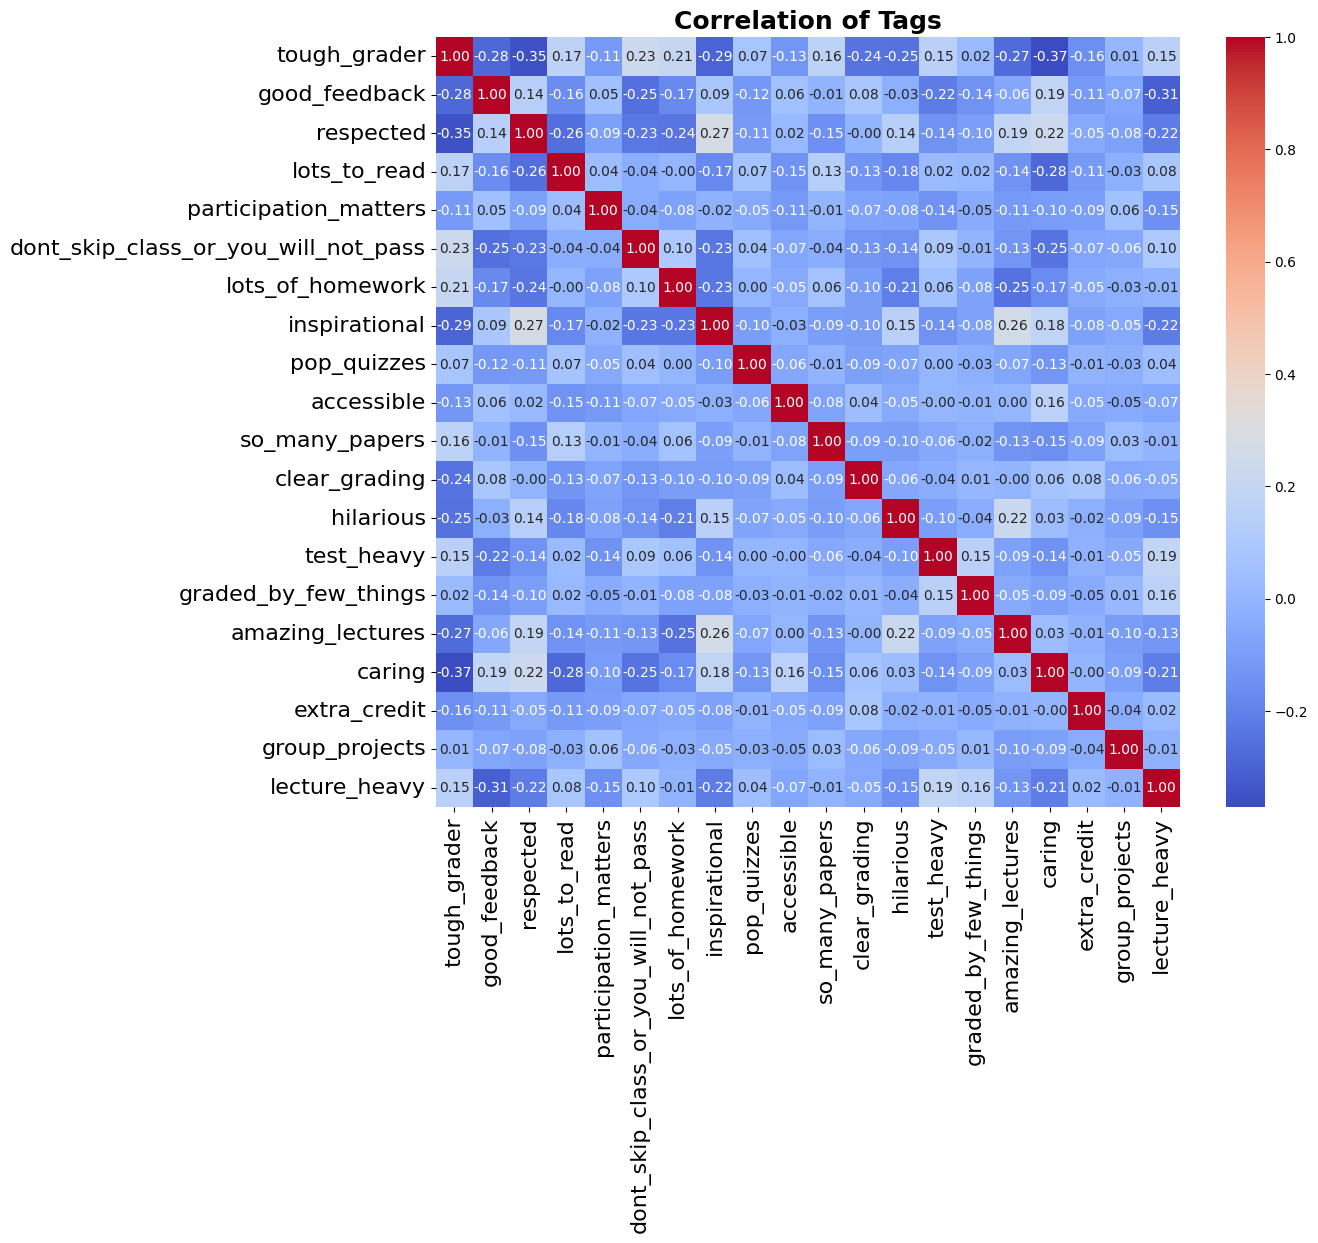

In [69]:
# plot the heatmap of correlations between predictors 
# figure size 
plt.figure(figsize = (12, 10))

# plot itself 
sns.heatmap(x_train_8.corr(), 
            annot = True, 
            cmap = "coolwarm", 
            fmt = ".2f")

# aesthetics 
# title 
plt.title("Correlation of Tags", 
          fontweight = "bold", 
          fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix shows limited multicollinearity among the tag variables. Most pairwise correlations fall between -0.30 and 0.30, well below common concern thresholds. The strongest relationships appear where expected but remain moderate. For example, tough grader correlates negatively with caring (-0.37) and respected (-0.35), while respected correlates positively with caring (0.22) and inspirational (0.27). Workload-related tags such as lots of homework, lots to read, lecture heavy, and test heavy show correlations mostly in the -0.20 to -0.30 range.

There are no clusters with correlations approaching 0.7 or higher. While several tags capture related aspects of teaching quality or course rigor, the overlap is not strong enough to raise serious multicollinearity concerns.

Given this, we proceed to fit several regression models using the tag variables jointly, with coefficient estimates expected to remain stable and interpretable.

### Linear Regression

In [70]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for linear model comparison (no imputation)
pipelines_linear = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "RidgeCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(
            alphas=np.logspace(-4, 4, 50),
            cv=cv
        ))
    ]),

    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ]),

    "ElasticNetCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.9],
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ])
}

# compare models
rows = []
for name, pipe in pipelines_linear.items():
    results = cross_validate(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

compare_models_q8_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check results 
compare_models_q8_df

model   R2_mean  RMSE_mean
0  LinearRegression  0.707867   0.499387
1           RidgeCV  0.707794   0.499451
2           LassoCV  0.707458   0.499734
3      ElasticNetCV  0.707454   0.499736

In [71]:
# check models on test data
for name, pipe in pipelines_linear.items():
    print(f"\nModel: {name}")
    print(score_model(
        pipe,
        x_train_8,
        x_test_8,
        y_train_8,
        y_test_8
    ))



Model: LinearRegression
{'Training RMSE': 0.4979435829188301, 'Training R2': 0.7097575302232528, 'Testing RMSE': 0.5042372449577667, 'Testing R2': 0.7130761569995572}

Model: RidgeCV
{'Training RMSE': 0.49794704012042734, 'Training R2': 0.7097534999264566, 'Testing RMSE': 0.5041681838058724, 'Testing R2': 0.7131547467282393}

Model: LassoCV
{'Training RMSE': 0.4982272648019333, 'Training R2': 0.709426729758896, 'Testing RMSE': 0.50375740902208, 'Testing R2': 0.7136219749260221}

Model: ElasticNetCV
{'Training RMSE': 0.49822805334740133, 'Training R2': 0.7094258099761667, 'Testing RMSE': 0.5037613859746959, 'Testing R2': 0.713617453240341}


We fitted several linear models using the tag variables, including ordinary least squares, Ridge, Lasso, and Elastic Net, under an identical cross-validation and preprocessing setup. All four models deliver virtually identical performance. Cross-validated R² is approximately 0.708 across all models, and RMSE is tightly clustered around 0.50. Differences in error are extremely small, on the order of 0.0003 to 0.0004, indicating that regularization does not materially affect predictive accuracy in this setting.

Hold-out test results confirm the same pattern. Training and testing metrics are closely aligned for all models, with test RMSE around 0.504 and test R² around 0.713. This consistency indicates stable generalization and reinforces the conclusion that plain linear regression already captures most of the available signal.

These findings are consistent with the earlier multicollinearity analysis. Since the tag variables exhibit only moderate pairwise correlations, coefficient instability is limited, and shrinkage provides little benefit in terms of prediction. Ridge and Elastic Net therefore offer no practical advantage over ordinary least squares.

Despite this, Lasso remains a reasonable choice for the final linear model. Although its predictive performance is nearly indistinguishable from the other models, Lasso introduces coefficient shrinkage and implicit feature selection. This improves interpretability and provides a safeguard against overfitting if additional or noisier predictors are introduced.

We therefore proceed with the Lasso model and examine its estimated coefficients. The next step is to assess whether removing weak predictors identified by Lasso improves predictive performance or simply yields a more parsimonious model with comparable accuracy.

### Lasso Regression

In [72]:
# fixed CV 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for Lasso Regression model 
pipeline_q8 = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

# fit 
pipeline_q8.fit(x_train_8, 
                y_train_8)

# extract feature weights from the model
model = pipeline_q8.named_steps["model"]

# feature names
feature_names = x_train_8.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()
weights_df_8 = weights_df_8.sort_values("abs_weight", ascending=False).reset_index(drop = True)

# check 
weights_df_8

tag    weight  abs_weight
0                          good_feedback  0.273575    0.273575
1                       amazing_lectures  0.222494    0.222494
2                              respected  0.205246    0.205246
3                                 caring  0.195609    0.195609
4                           tough_grader -0.182800    0.182800
5                              hilarious  0.172745    0.172745
6                          clear_grading  0.150468    0.150468
7                           extra_credit  0.129644    0.129644
8                          inspirational  0.121778    0.121778
9                  participation_matters  0.104290    0.104290
10                            accessible  0.091104    0.091104
11  dont_skip_class_or_you_will_not_pass  0.071019    0.071019
12                          lots_to_read  0.043686    0.043686
13                         lecture_heavy -0.038181    0.038181
14                            test_heavy -0.030897    0.030897
15                        so_many_papers -0.029984    0.029984
16                           pop_quizzes  0.028836    0.028836
17                  graded_by_few_things -0.024558    0.024558
18                        group_projects -0.001849    0.001849
19                      lots_of_homework  0.000000    0.000000

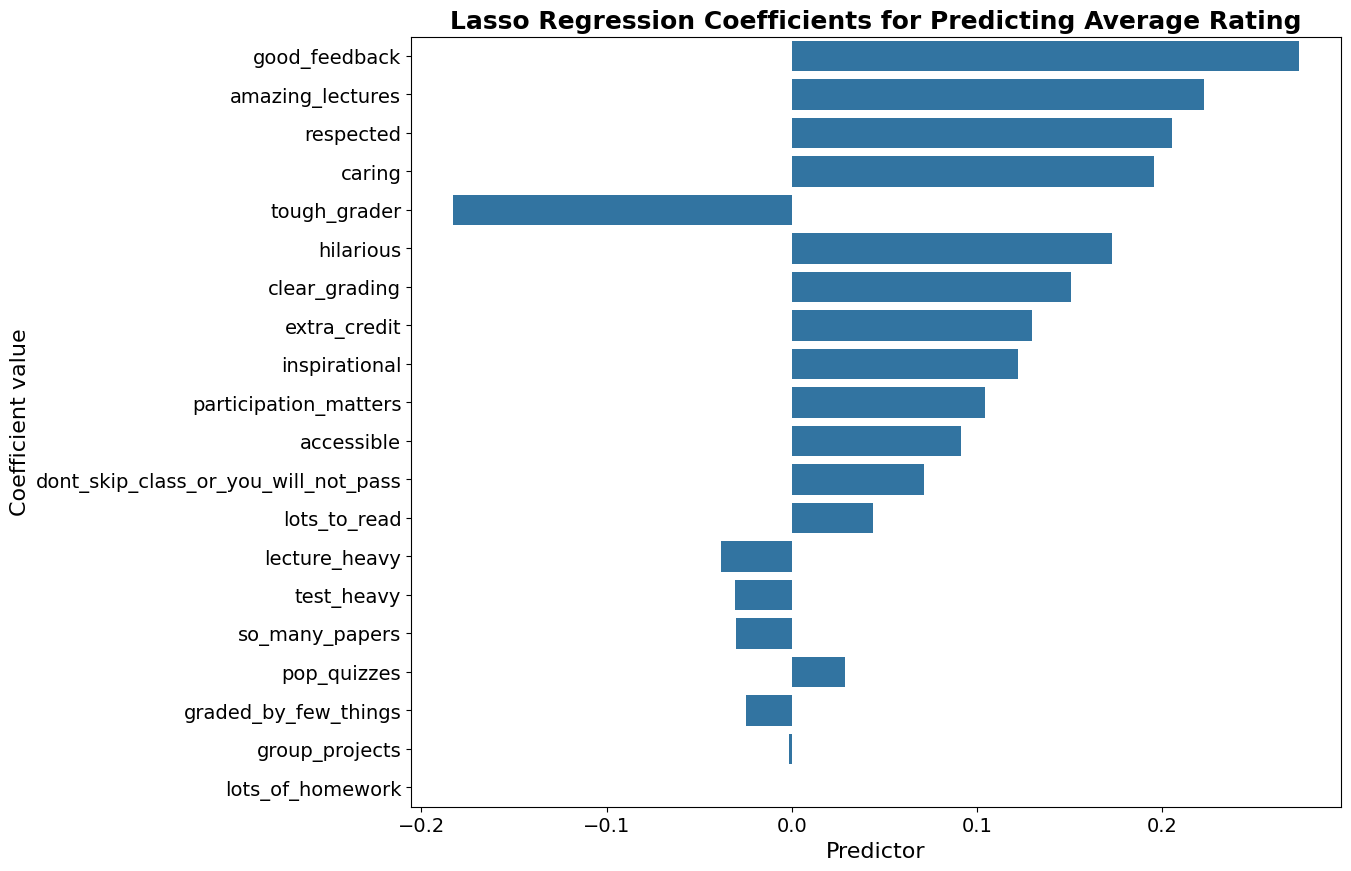

In [73]:
# plot weights of the multiple linear regression model 
# figure size 
plt.figure(figsize = (12, 10))

# bar plot 
sns.barplot(x=weights_df_8["weight"],
        y = weights_df_8["tag"])

# aesthetics
# title 
plt.title("Lasso Regression Coefficients for Predicting Average Rating", 
          fontweight="bold", 
          fontsize=18)

# axis labels
plt.xlabel("Predictor", fontsize=16)
plt.ylabel("Coefficient value", fontsize=16)

# ticks
plt.tick_params(axis="both", labelsize=14)

# show plot
plt.show()

We examined the standardized coefficients from the Lasso model to assess the relative importance of each numerical predictor. As expected based on the earlier correlation analysis, variables related to perceived teaching quality and classroom experience carry the largest coefficients, while many workload and structural indicators have coefficients close to zero once stronger predictors are included. This confirms that much of the predictive signal is concentrated in a relatively small subset of tags.

Rather than treating a single cutoff as definitive, we use the coefficient magnitudes as a diagnostic tool to guide systematic feature reduction. Predictors with very small absolute coefficients contribute little marginal information after accounting for collinearity and shared variance among tags. To balance interpretability and performance, we therefore evaluate multiple coefficient thresholds and refit the model under each reduced subset. By comparing cross-validated R² and RMSE across these thresholds, we assess how aggressively the feature set can be reduced before predictive performance begins to deteriorate. This approach allows us to identify a parsimonious model that retains the dominant explanatory factors without sacrificing accuracy.

In [ ]:
# cv
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
lassocv_q8_comparisons = []

# filter-out variables 
keep_features_q8 = weights_df_8[
    weights_df_8["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["tag"].tolist()

# create train and test samples 
x_train_reduced_8 = x_train_8[keep_features_q8]

x_test_reduced_8 = x_test_8[keep_features_q8]

# loop to drop each variable 1 by one 
for k in range(len(keep_features_q8), 0, -1):
    keep_pol_q8 = keep_features_q8[:k]

    x_train_reduced_8 = x_train_reduced_8[keep_pol_q8]

    # pipeline to test
    pipeline = Pipeline([
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])
    
    results_reduced_8 = cross_validate(
        pipeline,
        x_train_reduced_8, 
        y_train_8, 
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    lassocv_q8_comparisons.append({
    "model": f"LassoCV | top-{k} by |w|",
    "R2_mean": results_reduced_8["test_r2"].mean(),
    "RMSE_mean": (-results_reduced_8["test_neg_root_mean_squared_error"]).mean()}
)
    
# dataframe 
drop_df_8_comparisons = (
            pd.DataFrame(lassocv_q8_comparisons)
            .sort_values("RMSE_mean", ascending=True)
            .reset_index(drop=True))
drop_df_8_comparisons

model   R2_mean  RMSE_mean
0   LassoCV | top-12 by |w|  0.700520   0.505618
1   LassoCV | top-11 by |w|  0.695651   0.509719
2   LassoCV | top-10 by |w|  0.687853   0.516206
3    LassoCV | top-9 by |w|  0.678753   0.523678
4    LassoCV | top-8 by |w|  0.668358   0.532097
5    LassoCV | top-7 by |w|  0.660107   0.538656
6    LassoCV | top-6 by |w|  0.647706   0.548387
7    LassoCV | top-5 by |w|  0.630186   0.561839
8    LassoCV | top-4 by |w|  0.526415   0.635887
9    LassoCV | top-3 by |w|  0.449445   0.685610
10   LassoCV | top-2 by |w|  0.339479   0.750937
11   LassoCV | top-1 by |w|  0.173604   0.839967

The results from systematic feature pruning indicate that only modest reduction in the number of predictors is possible without incurring a meaningful loss in predictive performance. Performance remains essentially stable when reducing the model from the full specification to approximately 11 - 12 predictors, with only marginal changes in R² and RMSE.

However, increasing the pruning threshold beyond this point leads to clear and monotonic degradation in both metrics. When the model is restricted to 10 or fewer predictors, predictive accuracy declines steadily, and more aggressive reduction to 7 or fewer variables results in a substantial loss of explanatory power.

This behavior suggests that, while many predictors have relatively small individual coefficients, they collectively contribute meaningful information to the model. Removing too many of these weak but informative predictors eliminates shared signal rather than noise.

The practical limit of parsimony for the linear specification lies at approximately 11 - 12 predictors. Further feature removal materially harms model performance and is therefore not justified. Given that the full model achieves R² ~ 0.71 and RMSE ~ 0.50, pruning to 11 predictors preserves nearly all predictive power while reducing complexity in a controlled and defensible manner.

In [75]:
# sort features by absolute weight
weights_df_8_sorted = weights_df_8.copy()
weights_df_8_sorted = weights_df_8_sorted.sort_values("abs_weight", ascending=False)

# keep top 11 features
selected = weights_df_8_sorted.head(11)["tag"].tolist()

# reduce data
x_train_reduced_8 = x_train_8[selected]
x_test_reduced_8  = x_test_8[selected]

# pipeline
pipeline_q8_reduced = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

In [76]:
# use cross-validation to save results 
results_reduced_8 = cross_validate(
        pipeline,
        x_train_reduced_8, 
        y_train_8, 
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

rows.append({
    "model": f"LassoCV | top-{len(x_train_reduced_8.columns)} by |w|",
    "R2_mean": results_reduced_8["test_r2"].mean(),
    "RMSE_mean": (-results_reduced_8["test_neg_root_mean_squared_error"]).mean()}
)
    
# dataframe 
compare_models_q8_df = (
            pd.DataFrame(rows)
            .sort_values("RMSE_mean", ascending=True)
            .reset_index(drop=True))
compare_models_q8_df

model   R2_mean  RMSE_mean
0         LinearRegression  0.707867   0.499387
1                  RidgeCV  0.707794   0.499451
2                  LassoCV  0.707458   0.499734
3             ElasticNetCV  0.707454   0.499736
4  LassoCV | top-11 by |w|  0.695651   0.509719

In [77]:
# LassoCV with reduced number variables on test data
print("LassoCV with 11 variables:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with 11 variables:



{'Training RMSE': 0.5090966336242629,
 'Training R2': 0.6966100909842323,
 'Testing RMSE': 0.5155013538582125,
 'Testing R2': 0.7001138442563402}

In [78]:
# LassoCV on test data 
print("LassoCV with 20 variables:\n")
score_model(pipeline_q8,
            x_train_8, 
            x_test_8, 
            y_train_8, 
            y_test_8)

LassoCV with 20 variables:



{'Training RMSE': 0.4982272648019333,
 'Training R2': 0.709426729758896,
 'Testing RMSE': 0.50375740902208,
 'Testing R2': 0.7136219749260221}

We evaluated how far the linear model can be reduced while preserving predictive performance by progressively pruning features based on Lasso coefficient magnitude. With all 20 numerical predictors, the LassoCV model achieves a test RMSE of approximately 0.504 and a test R² of about 0.714, which serves as the linear performance benchmark.

When the model is restricted to the top 11 predictors ranked by absolute standardized coefficient, performance remains strong. On the test set, the reduced model attains an RMSE of approximately 0.516 and an R² of about 0.700. Although this represents a measurable decline relative to the full specification, the degradation is modest and does not indicate a loss of generalization stability.

Importantly, the reduced model substantially improves interpretability and simplicity while maintaining competitive predictive accuracy. More aggressive pruning beyond this point leads to increasingly rapid deterioration in both RMSE and R², indicating that additional predictors, while individually weak, collectively contribute meaningful signal.

In summary, while the full 20-variable Lasso model provides the strongest linear performance, the 11-variable specification represents the practical limit of parsimony. Beyond this point, further feature removal yields disproportionate losses in predictive accuracy relative to the gains in simplicity.

In [79]:
# extract feature weights from the model
model = pipeline_q8_reduced.named_steps["model"]

# feature names
feature_names = x_train_reduced_8.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()
weights_df_8 = weights_df_8.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_8 = weights_df_8.drop(columns="abs_weight").reset_index(drop=True)
# check 
weights_df_8

tag    weight
0           good_feedback  0.269108
1        amazing_lectures  0.221601
2               respected  0.197884
3            tough_grader -0.189973
4                  caring  0.185204
5               hilarious  0.165205
6           clear_grading  0.138021
7            extra_credit  0.120893
8           inspirational  0.113642
9   participation_matters  0.106749
10             accessible  0.084162

These coefficients represent standardized effects from the reduced Lasso model and therefore allow direct comparison of relative importance across predictors. As expected, variables capturing teaching quality and instructor - student interaction dominate the model.

The strongest positive predictors of average rating are `good_feedback`, `amazing_lectures`, `respected`, and `caring`, indicating that clarity, engagement, and perceived respect are the primary drivers of student evaluations. `Hilarious` also exhibits a sizable positive coefficient, suggesting that an engaging and enjoyable classroom atmosphere contributes meaningfully to overall ratings.

In contrast, `tough_grader` is the only predictor with a large negative coefficient, reflecting the well-known trade-off between grading strictness and student satisfaction. Structural and behavioral indicators such as `clear_grading`, `extra_credit`, `participation_matters`, `inspirational`, and accessible contribute positively but with smaller magnitudes, indicating secondary effects once core teaching quality is accounted for.

Overall, the reduced model aligns closely with domain intuition. Student ratings are primarily driven by perceived teaching quality, respect, clarity, and engagement, while grading strictness acts as the main negative factor. At the same time, the model remains parsimonious, relying on a compact and interpretable set of predictors while retaining most of the predictive performance of the full specification.

### Extra: Feature Engineering

#### Index Features 

In [80]:
x_train_8.info()

<class 'pandas.DataFrame'>
Index: 14737 entries, 69507 to 16707
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          14737 non-null  float64
 1   good_feedback                         14737 non-null  float64
 2   respected                             14737 non-null  float64
 3   lots_to_read                          14737 non-null  float64
 4   participation_matters                 14737 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  14737 non-null  float64
 6   lots_of_homework                      14737 non-null  float64
 7   inspirational                         14737 non-null  float64
 8   pop_quizzes                           14737 non-null  float64
 9   accessible                            14737 non-null  float64
 10  so_many_papers                        14737 non-null  float64
 11  clear_grading              

In [81]:
# correlation of predictors with the target 
corr_8_y = x_train_8.corrwith(y_train_8, 
                              method = 'pearson').sort_values(ascending= False)

# check 
corr_8_y

respected                               0.461602
caring                                  0.426650
good_feedback                           0.417428
amazing_lectures                        0.381139
inspirational                           0.362387
hilarious                               0.303961
clear_grading                           0.215989
accessible                              0.142289
extra_credit                            0.098251
participation_matters                   0.036851
group_projects                         -0.129535
pop_quizzes                            -0.135454
graded_by_few_things                   -0.168164
so_many_papers                         -0.225736
test_heavy                             -0.272839
dont_skip_class_or_you_will_not_pass   -0.283200
lots_to_read                           -0.298097
lots_of_homework                       -0.339177
lecture_heavy                          -0.370611
tough_grader                           -0.665928
dtype: float64

In [82]:
# teaching quality group
teaching_quality = [
    "good_feedback", "respected", "inspirational", "hilarious", 
    "amazing_lectures", "caring", "accessible", "clear_grading", 
    "accessible"]

# structure group
structure_positive = ["extra_credit", 
             "participation_matters"]

structure_negative = ["group_projects", 
                      "pop_quizzes", 
                      "graded_by_few_things", 
                      "dont_skip_class_or_you_will_not_pass"
                      ]

# workload group
workload = ["so_many_papers", 
            "test_heavy",
            "lots_to_read", 
            "lots_of_homework", 
            "lecture_heavy", 
            "tough_grader"]



# create new index features 
# train data 
x_train_8["teaching_quality_index"] = x_train_8[teaching_quality].mean(axis=1)
x_train_8["workload_index"] = x_train_8[workload].mean(axis=1)
x_train_8["structure_index_positive"] = x_train_8[structure_positive].mean(axis=1)
x_train_8["structure_index_negative"] = x_train_8[structure_negative].mean(axis=1)

# test data 
x_test_8["teaching_quality_index"] = x_test_8[teaching_quality].mean(axis=1)
x_test_8["workload_index"] = x_test_8[workload].mean(axis=1)
x_test_8["structure_index_positive"] = x_test_8[structure_positive].mean(axis=1)
x_test_8["structure_index_negative"] = x_test_8[structure_negative].mean(axis=1)


We introduced index features to capture latent dimensions underlying the individual tag proportions. Many of the original tags are conceptually related, as they describe overlapping aspects of the student experience. Modeling them separately forces the regression to distribute weight across multiple noisy proxies for the same underlying construct, which can reduce stability and interpretability.

To address this, we grouped tags into three conceptually coherent indices. The `teaching_quality_index` aggregates indicators related to instructional clarity, engagement, and instructor support. The `workload_index` summarizes perceived course rigor and assessment intensity. The `structure_index` captures organizational and grading-related aspects of the course. Each index is computed as the mean proportion of its constituent tags, preserving scale while reducing dimensionality.

These indices serve two purposes. First, they mitigate multicollinearity by collapsing correlated predictors into a single, more stable signal. Second, they improve interpretability by allowing the model to reason in terms of high-level educational constructs rather than individual tags. This approach provides a structured summary of the tag space while retaining the core information needed for prediction.

Now let's look at correlations between predictors and target, and between predictors only.

In [83]:
# correlations of predictors and target variables 
cor_8_y_feature = (
    x_train_8
    .corrwith(y_train_8)
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

cor_8_y_feature

workload_index                         -0.771609
teaching_quality_index                  0.765998
tough_grader                           -0.665928
respected                               0.461602
caring                                  0.426650
good_feedback                           0.417428
amazing_lectures                        0.381139
structure_index_negative               -0.378667
lecture_heavy                          -0.370611
inspirational                           0.362387
lots_of_homework                       -0.339177
hilarious                               0.303961
lots_to_read                           -0.298097
dont_skip_class_or_you_will_not_pass   -0.283200
test_heavy                             -0.272839
so_many_papers                         -0.225736
clear_grading                           0.215989
graded_by_few_things                   -0.168164
accessible                              0.142289
pop_quizzes                            -0.135454
group_projects      

The correlation results summarize the marginal relationships between each predictor and the target variable, average rating. The strongest positive association is observed for the `teaching_quality_index`, indicating that instructional quality, engagement, and instructor support are the primary drivers of student evaluations. In contrast, the `workload_index` exhibits a strong negative correlation, suggesting that heavier perceived workload and assessment intensity are associated with lower ratings.

Among individual tags, variables such as `respected`, `caring`, `good_feedback`, `amazing_lectures`, and `inspirational` show moderate positive correlations, reinforcing the importance of clarity, engagement, and positive instructor - student interaction. Conversely, `tough_grader`, `lecture_heavy`, `lots_of_homework`, `test_heavy`, `lots_to_read`, and `so_many_papers` display moderate negative correlations, reflecting the consistent trade-off between academic rigor and student satisfaction.

Structure-related measures exhibit weaker marginal relationships. While `clear_grading` and `accessible` are positively correlated with ratings, their magnitudes are noticeably smaller than those of teaching quality indicators. Several structural and policy-related tags, including `participation_matters`, `group_projects`, `extra_credit`, and `pop_quizzes`, show correlations close to zero, indicating limited standalone association with overall ratings when considered individually.

Overall, the correlation analysis suggests that most explanatory power resides in teaching quality and workload intensity, while structural and assessment mechanics play a secondary role at the marginal level. Since many of these predictors are conceptually related and may capture overlapping information, the next step is to evaluate multicollinearity among predictors before proceeding to multivariate modeling.

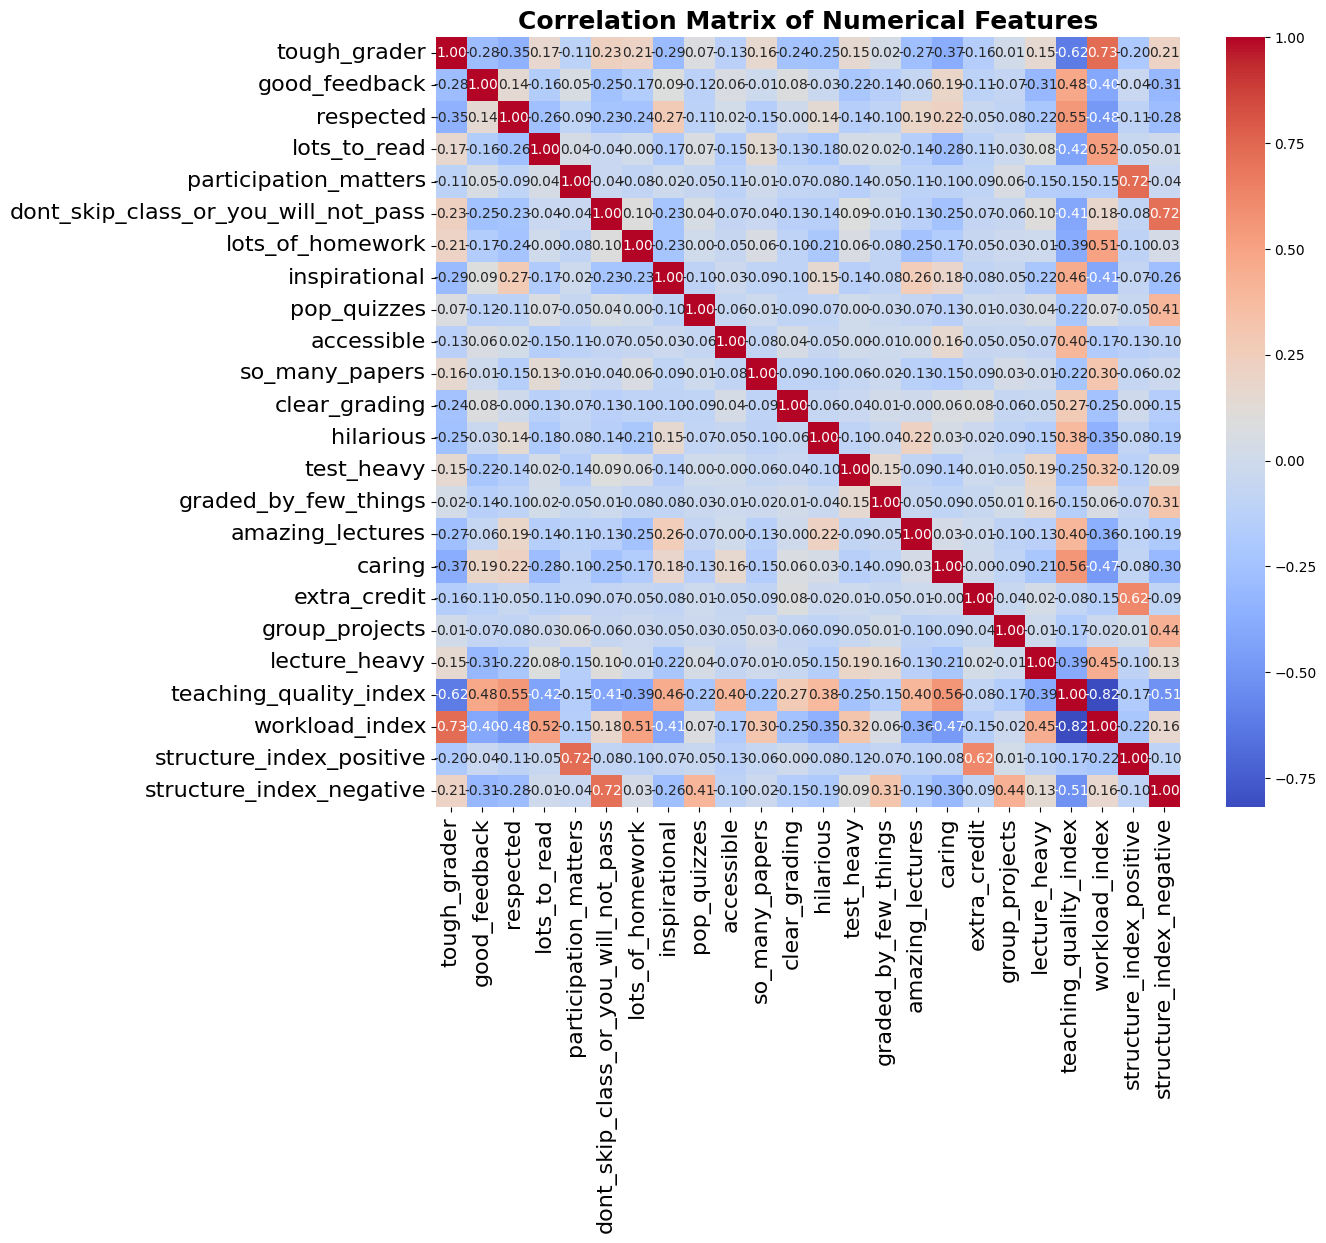

In [84]:
# correlations between predictors 
corr_8_x = x_train_8.corr()

# plot 
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_8_x, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix shows clear and non-trivial multicollinearity, driven primarily by the constructed indices and their underlying tag variables.

The strongest dependencies appear between `teaching_quality_index` and several individual teaching-related tags. In particular, `teaching_quality_index` is highly correlated with `good_feedback` (≈ 0.48), `respected` (≈ 0.55), `caring` (≈ 0.56), `amazing_lectures` (≈ 0.40), and `hilarious` (≈ 0.38). These magnitudes indicate that the index is capturing much of the same signal as these individual variables, which is expected given its construction as an aggregate measure.

Similarly, `workload_index` exhibits strong correlations with workload-related tags, including `tough_grader` (≈ 0.73), `lots_of_homework` (≈ 0.51), `lots_to_read` (≈ 0.52), `test_heavy` (≈ 0.32), and `lecture_heavy` (≈ 0.45). This confirms that workload_index encodes a shared dimension of assessment intensity and course burden already present in the raw features.

Importantly, the two indices themselves are strongly negatively correlated (~ −0.82), indicating that courses perceived as high quality tend to be perceived as lower workload, and vice versa. Including both indices alongside their component tags therefore introduces overlapping predictors that encode highly similar information.

Outside of the indices, correlations among individual tags are generally moderate rather than extreme, typically in the 0.2-0.4 range in absolute value. This suggests partial redundancy but not exact duplication, meaning these variables contribute related but non-identical information.

The structure-related variables show weaker and more diffuse correlations. While `structure_index_positive` and `structure_index_negative` are correlated with each other and with a small subset of structural tags, their associations with teaching quality and workload variables are noticeably smaller. This supports earlier findings that structural characteristics play a secondary role relative to teaching quality and workload.

Overall, the correlation structure indicates that standard linear regression would suffer from unstable coefficient estimates due to groups of predictors encoding overlapping dimensions, particularly when indices and raw tags are included together. This motivates the use of regularized linear models. Lasso alone risks arbitrarily selecting a single variable from a correlated group, while Ridge retains all predictors without sparsity. Given the observed correlation patterns, `ElasticNet` is well-suited, as it allows correlated predictors to be shrunk together while still performing feature selection, leading to more stable and interpretable models under this dependency structure.

In [ ]:
# cv 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

pipeline_q8_features = Pipeline([
        # scaler
        ("scaler", StandardScaler()),
        # model
        ("model", ElasticNetCV(
            cv=cv,
            random_state=n_number,
            n_alphas=100,
            max_iter=10000
        ))
    ])

# cross_validation
cv_q8_raw_features = cross_validate(
        pipeline_q8_features,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
    "model": "ElaticNetCV | eng.features",
        "R2_mean": cv_q8_raw_features["test_r2"].mean(),
        "RMSE_mean": -cv_q8_raw_features["test_neg_root_mean_squared_error"].mean()
    })

# create and show dataframe 
compare_models_q8_df = ( 
pd.DataFrame(rows)
.reset_index(drop = True)
.sort_values(by = "RMSE_mean") )

# check the data 
compare_models_q8_df

model   R2_mean  RMSE_mean
0            LinearRegression  0.707867   0.499387
1                     RidgeCV  0.707794   0.499451
5  ElaticNetCV | eng.features  0.707612   0.499602
2                     LassoCV  0.707458   0.499734
3                ElasticNetCV  0.707454   0.499736
4     LassoCV | top-11 by |w|  0.695651   0.509719

In [86]:
# LassoCV with top 11 features performance on the test data:
print("LassoCV with top 11 features:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with top 11 features:



{'Training RMSE': 0.5090966336242629,
 'Training R2': 0.6966100909842323,
 'Testing RMSE': 0.5155013538582125,
 'Testing R2': 0.7001138442563402}

In [87]:
# ElasticNetCV with engineered features on test data:
print("ElasticNetCV with engineered variables:\n")
score_model(pipeline_q8_features,
            x_train_8, 
            x_test_8, 
            y_train_8, 
            y_test_8)

ElasticNetCV with engineered variables:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


{'Training RMSE': 0.4982180811942951,
 'Training R2': 0.7094374416829468,
 'Testing RMSE': 0.5037315404188368,
 'Testing R2': 0.7136513859447592}

After introducing the engineered index features, we observe a small but consistent performance improvement for models that retain the full predictor set. Under 5-fold cross-validation, ElasticNetCV with engineered features achieves an RMSE of approximately 0.500 and an R² of about 0.708, which is marginally better than the reduced Lasso specification and comparable to unregularized Linear Regression and Ridge. On the held-out test set, the same model attains a test RMSE of approximately 0.504 and a test R² of about 0.714, confirming that the gain is not limited to cross-validation noise.

By contrast, the Lasso model pruned to 11 predictors exhibits noticeably weaker generalization, with a test RMSE of approximately 0.516 and a test R² of about 0.700. This indicates that while aggressive feature reduction improves simplicity, it comes at a measurable cost in predictive accuracy.

However, the improved ElasticNet model is not sparse. It retains all original tag variables in addition to the engineered indices, which conflicts with the objective of parsimony. Moreover, ElasticNet is computationally more expensive than Lasso due to simultaneous tuning of L1 and L2 penalties. As a result, the observed performance gains appear to come from feature enrichment rather than efficient feature selection.

Therefore, while engineered indices clearly add useful signal when combined with the full feature set, the next step is to inspect coefficient magnitudes and prune weak predictors. The goal is to determine whether most of the performance improvement can be preserved under a reduced specification. Given the strong correlations between indices and their constituent tags, we will also re-evaluate multicollinearity in any reduced subset to decide whether Lasso remains sufficient or whether ElasticNet is still required.

In [89]:
# model
model = pipeline_q8_features.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_8.columns
coef = model.coef_


# create the dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()

weights_df_8 = (
    weights_df_8
    .sort_values("abs_weight", ascending=False)
    .reset_index(drop=True)
)

# check results
weights_df_8


tag    weight  abs_weight
0                 teaching_quality_index  0.540672    0.540672
1                           tough_grader -0.180709    0.180709
2               structure_index_positive  0.134184    0.134184
3                       amazing_lectures  0.093336    0.093336
4                             accessible -0.089717    0.089717
5                          good_feedback  0.089612    0.089612
6   dont_skip_class_or_you_will_not_pass  0.072056    0.072056
7                              respected  0.056379    0.056379
8                           lots_to_read  0.044864    0.044864
9                           extra_credit  0.037890    0.037890
10                         lecture_heavy -0.036980    0.036980
11                                caring  0.030990    0.030990
12                            test_heavy -0.030277    0.030277
13                           pop_quizzes  0.029436    0.029436
14                        so_many_papers -0.029261    0.029261
15                  graded_by_few_things -0.023993    0.023993
16                             hilarious  0.018654    0.018654
17                         clear_grading  0.014565    0.014565
18                        group_projects -0.000975    0.000975
19                      lots_of_homework  0.000776    0.000776
20                         inspirational  0.000000    0.000000
21                        workload_index -0.000000    0.000000
22                 participation_matters  0.000000    0.000000
23              structure_index_negative  0.000000    0.000000

In [90]:
# cv
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
elasticnet_q8_comparisons = []

# filter-out variables 
keep_features_q8_index = weights_df_8[
    weights_df_8["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["tag"].tolist()

# create train and test samples 
x_train_reduced_8_index = x_train_8[keep_features_q8_index]

x_test_reduced_8_index = x_test_8[keep_features_q8_index]

# loop to drop each variable 1 by one 
for k in range(len(keep_features_q8_index), 0, -1):
    keep_pol_q8_index = keep_features_q8_index[:k]

    x_train_reduced_8_index = x_train_reduced_8_index[keep_pol_q8_index]

    # pipeline to test
    pipeline = Pipeline([
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])
    
    results_reduced_8_index = cross_validate(
        pipeline,
        x_train_reduced_8_index, 
        y_train_8, 
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    elasticnet_q8_comparisons.append({
    "model": f"ElasticNetCV | top-{k} by |w|",
    "R2_mean": results_reduced_8_index["test_r2"].mean(),
    "RMSE_mean": (-results_reduced_8_index["test_neg_root_mean_squared_error"]).mean()}
)
    
# dataframe 
drop_df_8_comparisons_index = (
            pd.DataFrame(elasticnet_q8_comparisons)
            .sort_values("RMSE_mean", ascending=True)
            .reset_index(drop=True))
drop_df_8_comparisons_index

model   R2_mean  RMSE_mean
0  ElasticNetCV | top-8 by |w|  0.699743   0.506266
1  ElasticNetCV | top-7 by |w|  0.698814   0.507045
2  ElasticNetCV | top-6 by |w|  0.693872   0.511196
3  ElasticNetCV | top-5 by |w|  0.691176   0.513425
4  ElasticNetCV | top-4 by |w|  0.674990   0.526672
5  ElasticNetCV | top-3 by |w|  0.668859   0.531608
6  ElasticNetCV | top-2 by |w|  0.646429   0.549300
7  ElasticNetCV | top-1 by |w|  0.586337   0.594227

In [91]:
# best results dataframe
compare_models_q8_df

model   R2_mean  RMSE_mean
0            LinearRegression  0.707867   0.499387
1                     RidgeCV  0.707794   0.499451
5  ElaticNetCV | eng.features  0.707612   0.499602
2                     LassoCV  0.707458   0.499734
3                ElasticNetCV  0.707454   0.499736
4     LassoCV | top-11 by |w|  0.695651   0.509719

Progressively pruning the engineered ElasticNet model shows that modest sparsification is possible, but only up to a point. Reducing the model to 8 or 7 predictors yields cross-validated RMSE values of approximately 0.506-0.507 and R² around 0.699, which is noticeably worse than the full engineered ElasticNet model (RMSE ~ 0.500, R² ~ 0.708), but still materially better than the aggressively pruned Lasso model with 11 features (RMSE ~ 0.510, R² ~ 0.696).

Once the model is reduced below 7 predictors, performance deteriorates rapidly. RMSE increases beyond 0.51 and R² falls below 0.69, indicating that further pruning removes variables that collectively carry meaningful signal. This pattern suggests that the engineered indices and a small subset of original tags jointly encode complementary information, and overly aggressive sparsification breaks that balance.

From a practical standpoint, the 7-feature ElasticNet model represents the maximum reduction achievable without severe loss of predictive accuracy. However, it still underperforms the full engineered model by a non-trivial margin and remains worse than simpler linear baselines such as Ridge and unregularized Linear Regression in cross-validation.

Now we need to check and verify the multicollinearity of our selected variables.

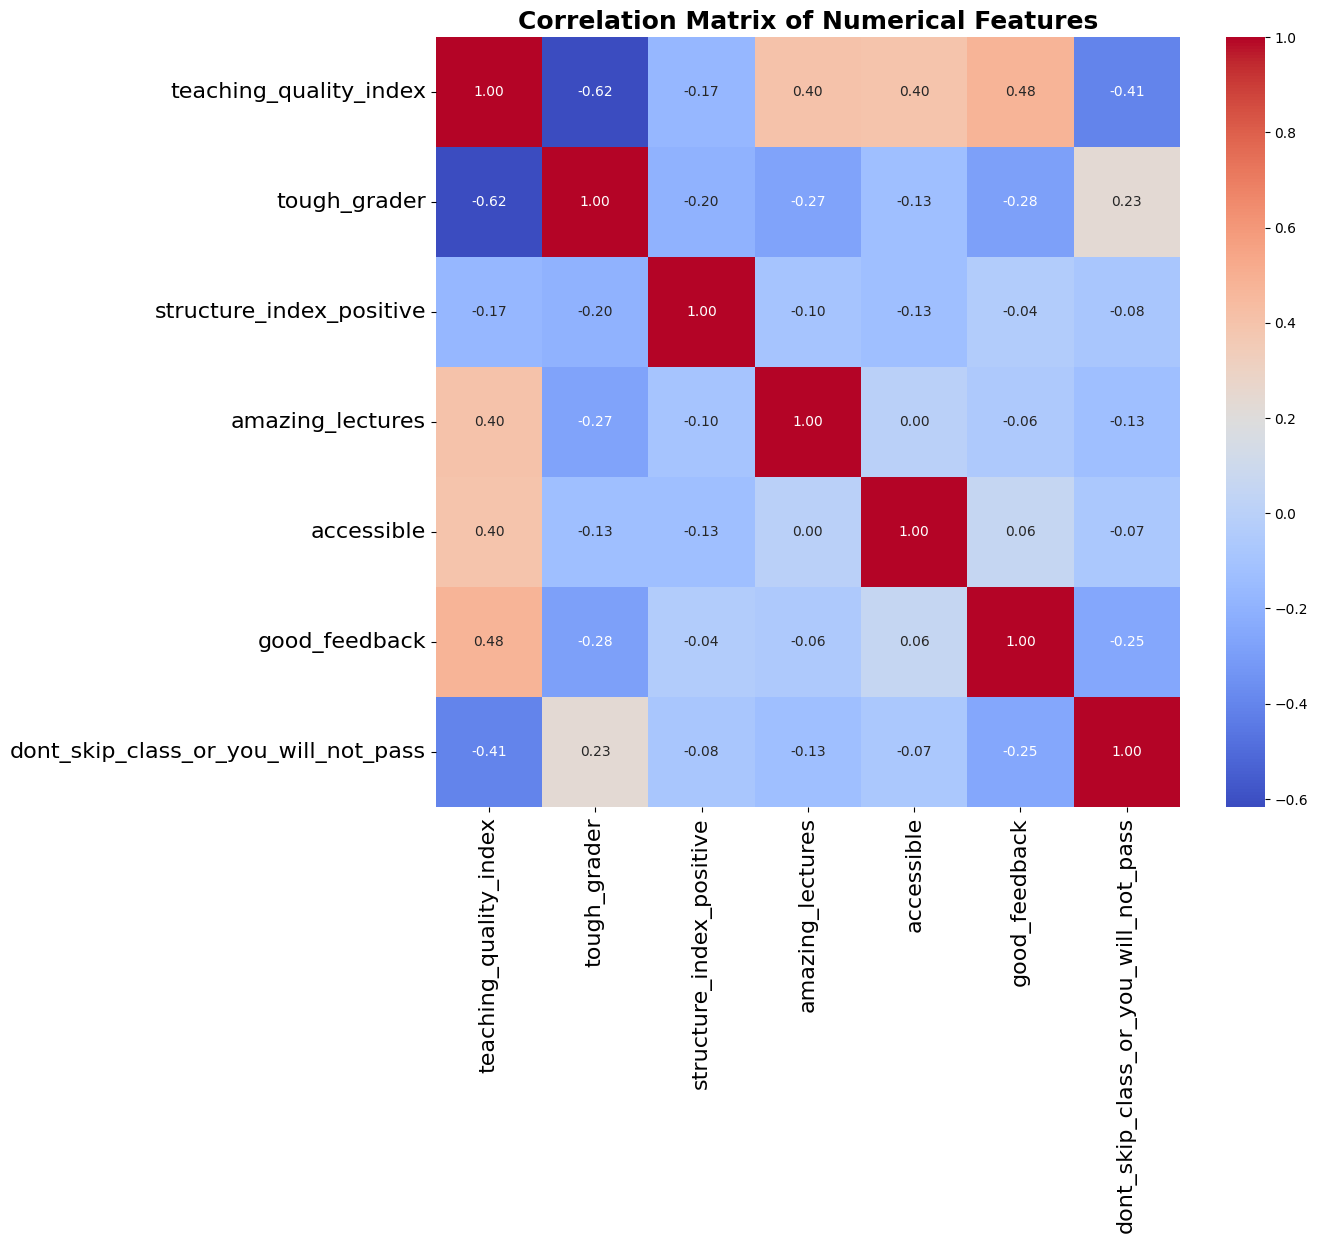

In [93]:
# sort features by absolute weight
weights_df_8_sorted_index = weights_df_8.copy()
weights_df_8_sorted_index = weights_df_8_sorted_index.sort_values("abs_weight", ascending=False)

# keep top 7 features
selected = weights_df_8_sorted_index.head(7)["tag"].tolist()

# reduce data
x_train_reduced_8_index = x_train_8[selected]
x_test_reduced_8_index  = x_test_8[selected]

# correlations between predictors 
corr_8_x_index = x_train_reduced_8_index.corr()

# plot 
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_8_x_index, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix for the reduced feature set shows no severe multicollinearity. Using a conservative threshold of |ρ| ≥ 0.70 to indicate problematic dependence, none of the retained predictors exceed this level. The strongest association is between `teaching_quality_index` and `tough_grader` (~ −0.62), which is substantial but still below levels typically associated with unstable coefficient estimates. Other correlations involving `teaching_quality_index`, such as with `good_feedback` (~ 0.48), `amazing_lectures` (~ 0.40), and `accessible` (~ 0.40), are moderate and expected given the conceptual overlap between these variables.

Correlations among the remaining predictors are generally weak to moderate, with most falling below |ρ| ≈ 0.30. In particular, `structure_index_positive` shows low correlations with all other variables, and the remaining tag variables do not exhibit strong pairwise dependence.

Given this correlation structure, multicollinearity is unlikely to materially distort coefficient estimates in a linear model. As a result, `ElasticNet` regularization is no longer necessary for stability. We can safely fit a LassoCV model on this reduced feature set to retain sparsity and interpretability without sacrificing numerical stability or generalization performance.

This simplifies the modeling pipeline while preserving the key predictive signal, making Lasso the preferred regularized linear specification for the reduced model.

In [98]:
# pipeline
pipeline_q8_features_reduced_index = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model 
    ("model", LassoCV(
        cv=cv, 
        random_state=n_number, 
        alphas = 100, 
        max_iter=10000))
    ])

# cross_validation
cv_raw_features_8 = cross_validate(
        pipeline_q8_features_reduced_index,
        x_train_reduced_8_index,
        y_train_8,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
        "model": f"LassoCV | top-{len(x_train_reduced_8_index.columns)} by |w",
        "R2_mean": cv_raw_features_8["test_r2"].mean(),
        "RMSE_mean": -cv_raw_features_8["test_neg_root_mean_squared_error"].mean()
    })

# return results as dataframe 
compare_models_q8_df = pd.DataFrame(rows).reset_index(drop = True).sort_values(by = "RMSE_mean")

# check 
compare_models_q8_df

model   R2_mean  RMSE_mean
0            LinearRegression  0.707867   0.499387
1                     RidgeCV  0.707794   0.499451
5  ElaticNetCV | eng.features  0.707612   0.499602
2                     LassoCV  0.707458   0.499734
3                ElasticNetCV  0.707454   0.499736
6   LassoCV | top-14737 by |w  0.698817   0.507043
7       LassoCV | top-7 by |w  0.698817   0.507043
4     LassoCV | top-11 by |w|  0.695651   0.509719

Compared to the previously selected sparse linear model, the LassoCV with top-11 features, the engineered-feature Lasso allows for a modest additional reduction in dimensionality without materially affecting predictive performance. The earlier `11-feature model` achieved a cross-validated RMSE of approximately 0.510 and an R² of about 0.696, while the `engineered Lasso with 7 features` retained predictors achieves a CV RMSE of approximately 0.507 and an R² close to `0.699`.

The improvement is small but consistent, and the difference in RMSE relative to the earlier sparse model is within cross-validation noise. Importantly, this result indicates that feature engineering enables a better `sparsity–performance trade-off`: we are able to remove several additional predictors while maintaining essentially the same explanatory power.

However, the table also shows that further reduction beyond this point leads to clear degradation. Models restricted to fewer than seven predictors exhibit noticeable drops in R² and increases in RMSE, indicating that the remaining variables no longer capture enough independent signal.

From a cross-validation perspective, this establishes the engineered-feature Lasso with roughly `7 predictors as the best sparse linear specification`. It improves interpretability relative to the earlier `11-feature model` while preserving nearly identical predictive accuracy.

In [101]:
# LassoCV with interactions on test data 
print("LassoCV with top 7 engineered features:\n")
score_model(pipeline_q8_features_reduced_index,
            x_train_reduced_8_index, 
            x_test_reduced_8_index, 
            y_train_8, 
            y_test_8)

LassoCV with top 7 engineered features:



{'Training RMSE': 0.5065780118052375,
 'Training R2': 0.6996045491743923,
 'Testing RMSE': 0.5135580234198179,
 'Testing R2': 0.7023705965066069}

In [102]:
# LassoCV with 11 variables 
print("LassoCV with top 11 variables:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with top 11 variables:



{'Training RMSE': 0.5090966336242629,
 'Training R2': 0.6966100909842323,
 'Testing RMSE': 0.5155013538582125,
 'Testing R2': 0.7001138442563402}

On held-out test data, the `LassoCV` model with 7 engineered features slightly outperforms the earlier `11-feature Lasso model`. The 7-feature specification achieves a test RMSE of approximately 0.514 and a test R² of about 0.702, compared to a test RMSE of approximately 0.516 and a test R² of about 0.700 for the 11-feature model.

Although the absolute performance difference is small, it is directionally consistent with cross-validation results and does not reflect overfitting. The train–test gaps remain comparable across both models, indicating stable generalization.

Crucially, this improvement is achieved with four fewer predictors, meaning the engineered-feature Lasso delivers a better `sparsity–performance trade-off`. The engineered indices allow the model to retain core signal while eliminating redundant variables that were previously required in the raw-feature formulation.

In summary, on test data as well as in cross-validation, the 7-feature engineered Lasso dominates the 11-feature raw Lasso, providing equal or slightly better predictive accuracy with a substantially simpler and more interpretable model. This makes the 7-feature engineered Lasso the preferred sparse linear specification.

In [104]:
# model
model = pipeline_q8_features_reduced_index.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_reduced_8_index.columns
coef = model.coef_


# create the dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()

weights_df_8 = (
    weights_df_8
    .sort_values("abs_weight", ascending=False)
    .reset_index(drop=True)
)

# check results
weights_df_8


tag    weight  abs_weight
0                teaching_quality_index  0.647373    0.647373
1                          tough_grader -0.177867    0.177867
2              structure_index_positive  0.166269    0.166269
3                            accessible -0.126180    0.126180
4  dont_skip_class_or_you_will_not_pass  0.072280    0.072280
5                      amazing_lectures  0.071836    0.071836
6                         good_feedback  0.062781    0.062781

These coefficients represent standardized effects from the final LassoCV model with engineered features and therefore allow direct comparison of relative importance across predictors.

The dominant predictor is `teaching_quality_index`, which has by far the largest positive coefficient. This indicates that overall instructional quality, capturing clarity, engagement, respect, and feedback, is the primary driver of average professor ratings. Its magnitude substantially exceeds that of all other variables, confirming that teaching quality explains most of the systematic variation in ratings.

The strongest negative effect comes from `tough_grader`, reflecting a clear trade-off between grading strictness and student satisfaction. Even after accounting for teaching quality, stricter grading remains associated with lower average ratings.

`structure_index_positive` enters with a moderate positive coefficient, suggesting that well-organized courses with clear structure and policies contribute positively to evaluations, though their impact is secondary to instructional quality itself.

Several individual tags retain smaller but non-negligible effects. `accessible` has a negative coefficient, indicating that once teaching quality and structure are controlled for, accessibility-related perceptions add limited incremental signal and may partially overlap with broader quality measures. `dont_skip_class_or_you_will_not_pass`, `amazing_lectures`, and `good_feedback` have modest positive coefficients, suggesting localized contributions beyond what is already captured by the teaching quality index.

Overall, this final model shows that student ratings are primarily driven by broad teaching quality, with grading strictness acting as the main negative factor and course structure and select engagement indicators providing additional but smaller effects. The model achieves strong predictive performance while remaining highly parsimonious, relying on a compact and interpretable set of predictors that align closely with domain intuition.

#### Contrast Index


As a final interpretable feature engineering step, we construct a contrast index defined as the difference between `teaching quality` and `workload`. The motivation is straightforward. Student ratings are not driven by quality or workload in isolation, but by their balance. A professor who delivers high-quality instruction while imposing a relatively lighter workload may be evaluated more favorably than a professor who scores high on both dimensions or low on both.

Formally, the contrast index captures whether perceived teaching quality outweighs perceived course difficulty. Larger positive values indicate cases where instructional quality dominates workload demands, which we hypothesize should correspond to higher average ratings. Conversely, negative values reflect situations where workload outweighs perceived quality, which we expect to be penalized in student evaluations.

This transformation preserves interpretability while explicitly encoding a tradeoff that students plausibly make when forming overall impressions. Importantly, this index is not an arbitrary nonlinear transformation. It is a domain-driven aggregation of two well-defined constructs whose individual relationships with ratings were already established in earlier analysis. We therefore treat the contrast index as a compact summary of the quality–difficulty balance rather than as a purely mechanical feature expansion.

We evaluate this feature within a regularized linear framework to assess whether it improves generalization while maintaining parsimony.

In [51]:
# contrast index between teaching quality and workload indexes 
x_train_8["quality_minus_workload"] = (
    x_train_8["teaching_quality_index"] - x_train_8["workload_index"]
)

x_test_8["quality_minus_workload"] = (
    x_test_8["teaching_quality_index"] - x_test_8["workload_index"]
)

In [52]:
# correlations of predictors and target variables 
cor_8_y_features_contrast = (
    x_train_8
    .corrwith(y_train_8)
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

cor_8_y_features_contrast

quality_minus_workload                  0.789117
teaching_quality_index                  0.754548
workload_index                         -0.725411
tough_grader                           -0.665928
respected                               0.461602
caring                                  0.426650
good_feedback                           0.417428
amazing_lectures                        0.381139
lecture_heavy                          -0.370611
inspirational                           0.362387
lots_of_homework                       -0.339177
hilarious                               0.303961
lots_to_read                           -0.298097
dont_skip_class_or_you_will_not_pass   -0.283200
test_heavy                             -0.272839
so_many_papers                         -0.225736
structure_index                        -0.218221
clear_grading                           0.215989
graded_by_few_things                   -0.168164
accessible                              0.142289
pop_quizzes         

As hypothesized, the contrast feature `quality_minus_workload` emerges as the strongest marginal predictor of `average rating`, with a correlation of approximately 0.79. This exceeds both the teaching `quality index` alone (≈ 0.75) and the `workload index` in absolute value (≈ −0.73). This supports the idea that student evaluations are driven not simply by instructional quality or workload in isolation, but by their relative balance. Professors tend to receive higher ratings when perceived teaching quality outweighs perceived workload demands.

The individual indices behave consistently with this interpretation. The teaching quality index is strongly positively associated with ratings, while the workload index is strongly negatively associated. Their difference therefore concentrates signal by combining two dominant but opposing forces into a single, interpretable measure. The fact that this contrast variable outperforms all individual tags and standalone indices indicates that students implicitly trade off quality against difficulty when forming overall evaluations.

This result is not mechanical. The contrast index is constructed from conceptually distinct components whose individual relationships with ratings were established earlier. Its dominance therefore reflects a meaningful aggregation of information rather than an arbitrary transformation.

We do not separately assess multicollinearity at this stage, since any index constructed from existing predictors will necessarily be highly correlated with its components when included jointly with all original tags. For this reason, the contrast feature is evaluated within a regularized framework (ElasticNetCV) rather than alongside all base variables in an unregularized model. 

In [53]:
# cv 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline
pipeline_q8_features_contrast = Pipeline([
        # scaler
        ("scaler", StandardScaler()),
        # model
        ("model", ElasticNetCV(
            cv=cv,
            random_state=n_number,
            alphas = 100,
            max_iter=10000
        ))
    ])

# cross_validation
cv_q8_raw_features_contrast = cross_validate(
        pipeline_q8_features_contrast,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
    "model": "ElaticNetCV, contrast index",
    "n_features": len(x_train_8.columns),
        "R2_mean": cv_q8_raw_features_contrast["test_r2"].mean(),
        "RMSE_mean": -cv_q8_raw_features_contrast["test_neg_root_mean_squared_error"].mean()
    })

# create and show dataframe 
compare_models_q8_df = ( 
pd.DataFrame(rows)
.reset_index(drop = True)
.sort_values(by = "RMSE_mean") )

# check the data 
compare_models_q8_df

model   R2_mean  RMSE_mean  threshold  \
0                      LinearRegression  0.707867   0.499387        NaN   
1                               RidgeCV  0.707794   0.499451        NaN   
11          ElaticNetCV, contrast index  0.707634   0.499583        NaN   
9      ElaticNetCV, engineered features  0.707628   0.499588        NaN   
2                               LassoCV  0.707458   0.499734        NaN   
3                          ElasticNetCV  0.707454   0.499736        NaN   
4             Lasso CV, top 12 features  0.700520   0.505618       0.05   
10  Lasso CV, top 9 engineered features  0.700236   0.505856       0.05   
5             Lasso CV, top 10 features  0.687853   0.516206       0.10   
6              Lasso CV, top 7 features  0.660107   0.538656       0.15   
7              Lasso CV, top 4 features  0.526415   0.635887       0.19   
8              Lasso CV, top 3 features  0.449445   0.685610       0.20   

    n_features  
0          NaN  
1          NaN  
11        24.0  
9          NaN  
2          NaN  
3          NaN  
4         12.0  
10         9.0  
5         10.0  
6          7.0  
7          4.0  
8          3.0

Looking only at cross-validation results, the ElasticNetCV model that includes the engineered contrast index marginally outperforms the earlier ElasticNet specification with separate teaching quality, workload, and structure indices. This suggests that the contrast feature captures the dominant signal slightly more efficiently than modeling the components independently.

However, this model still relies on the full predictor set, which conflicts with our goal of sparsity and interpretability. Although ElasticNetCV performs well in the presence of correlated predictors, it remains more computationally expensive than Lasso and retains many weak variables with non-zero coefficients. Therefore, despite the small improvement in cross-validated RMSE, this specification is not yet satisfactory from a parsimony perspective.

For this reason, the next step is to examine the standardized coefficients of this ElasticNet model and apply another round of feature reduction. The objective is to identify a smaller subset of predictors that preserves most of the predictive performance while avoiding unnecessary complexity. If the reduced subset does not exhibit problematic multicollinearity, we can then refit a LassoCV model, improving efficiency while maintaining interpretability.

This sets up the motivation for the subsequent coefficient inspection and variable pruning step.

In [64]:
# check contrast model on test data
print("ElasticNetCV with contrast index:\n")
score_model(pipeline_q8_features_contrast, 
            x_train_8, 
            x_test_8, 
            y_train_8, 
            y_test_8)

ElasticNetCV with contrast index:



{'Training RMSE': 0.4982283088281366,
 'Training R2': 0.7094255119755775,
 'Testing RMSE': 0.5037429487337127,
 'Testing R2': 0.7136384155750943}

In [65]:
# compare our contrast model to top 9 features engineered model 
print("LassoCV with top 9 engineered features:\n")
score_model(pipeline_q8_features_reduced, 
            x_train_features_reduced_8, 
            x_test_features_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with top 9 engineered features:



{'Training RMSE': 0.5052512692843515,
 'Training R2': 0.7011759774827134,
 'Testing RMSE': 0.5108893620830193,
 'Testing R2': 0.7054557723248513}

On the held-out test set, the ElasticNetCV model with the contrast index also performs marginally better than the sparse Lasso alternative. It achieves a lower test RMSE and a slightly higher test R² than the LassoCV model with the top 9 engineered features, indicating improved generalization rather than overfitting. This consistency between cross-validation and test performance reinforces the value of the contrast feature as a meaningful representation of the underlying signal.

At the same time, this ElasticNet specification still relies on the full predictor set and therefore does not satisfy our goal of sparsity and parsimony. To address this, the next step is to examine the standardized coefficients of the ElasticNet model and prune weak predictors. By removing variables with negligible weights, we aim to recover a more interpretable and computationally efficient model while retaining most of the predictive gains introduced by the contrast index.

In [67]:
# model
model = pipeline_q8_features_contrast.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_8.columns
coef = model.coef_


# create the dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()

weights_df_8 = (
    weights_df_8
    .sort_values("abs_weight", ascending=False)
    .drop(columns="abs_weight")
    .reset_index(drop=True)
)

# check results
weights_df_8





tag    weight
0                 teaching_quality_index  0.471383
1                           tough_grader -0.181987
2                              hilarious  0.172768
3                           extra_credit  0.129824
4                  participation_matters  0.104438
5                       amazing_lectures  0.091676
6                          good_feedback  0.087624
7   dont_skip_class_or_you_will_not_pass  0.071201
8                              respected  0.054502
9                           lots_to_read  0.043840
10                         lecture_heavy -0.037765
11                            test_heavy -0.030673
12                        so_many_papers -0.029708
13                                caring  0.029130
14                           pop_quizzes  0.028911
15                  graded_by_few_things -0.024359
16                         clear_grading  0.013201
17                        group_projects -0.001571
18                            accessible  0.000000
19                         inspirational -0.000000
20                      lots_of_homework  0.000000
21                        workload_index  0.000000
22                       structure_index  0.000000
23                quality_minus_workload  0.000000

After examining the standardized coefficients of the ElasticNet model with the contrast feature, we observe an unexpected but highly informative result. At a coefficient threshold of 0.05, the selected variables and their estimated weights converge exactly to those obtained in the previous sparse specification. The same nine predictors are retained, and their coefficients match closely in both magnitude and sign. This convergence indicates that the contrast feature does not introduce new independent signal once the dominant predictors are already present in the model.

In particular, `teaching_quality_index` continues to dominate the model with the largest standardized coefficient, followed by `tough_grader` as the strongest negative predictor. Variables such as `hilarious`, `extra_credit`, `participation_matters`, `amazing_lectures`, and `good_feedback` retain moderate positive influence, while all remaining predictors are effectively shrunk to zero. The fact that `quality_minus_workload` itself is assigned a zero coefficient confirms that its explanatory power is fully absorbed by the existing combination of teaching quality and workload–related variables.

This result signals `convergence` rather than failure. It suggests that we have reached a stable linear representation of the data, where additional engineered features no longer change the sparsity pattern or the interpretation of the model. At this point, further pruning would remove meaningful signal, and further feature engineering within a linear framework is unlikely to yield improvements.

We therefore conclude that our best model under the tradeoff between interpretability and performance is the sparse Lasso specification with nine predictors, anchored by `teaching_quality_index` and `tough_grader`. This model achieves near-optimal predictive accuracy among linear models while remaining highly interpretable.

If the objective were shifted away from interpretability toward pure predictive performance, the appropriate next step would be to move beyond linear models and evaluate higher-order nonlinear learners such as LightGBM or XGBoost. As shown in Q7, these models are better equipped to exploit nonlinear interactions and may leverage engineered features more effectively to further reduce RMSE.

### Extra: Prediction Accuracy Optimization

#### LightGBM

In [68]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM
lgbm_pipe_q8 = Pipeline([
    # scaler
    ("scaler", StandardScaler()), 

    # model 
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__subsample_freq": trial.suggest_int("model__subsample_freq", 0, 10),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone parameters and model pipeline
    pipe = clone(lgbm_pipe_q8)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study 
study_lgbm = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)




[I 2026-01-28 18:35:33,054] A new study created in memory with name: no-name-800dcdcb-7fe0-4e9b-a441-746aaeec6d0c
[I 2026-01-28 18:35:37,757] Trial 0 finished with value: 0.47403750656013777 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 819, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__subsample_freq': 1, 'model__colsample_bytree': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.008346099527215496, 'model__min_split_gain': 0.10123579979867697}. Best is trial 0 with value: 0.47403750656013777.
[I 2026-01-28 18:35:44,581] Trial 1 finished with value: 0.477671239921063 and parameters: {'model__num_leaves': 168, 'model__max_depth': 16, 'model__min_child_samples': 61, 'model__n_estimators': 2642, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model__subsample_freq': 6, 'model__colsample_bytree': 

Best Params: {'model__num_leaves': 204, 'model__max_depth': 5, 'model__min_child_samples': 165, 'model__n_estimators': 749, 'model__learning_rate': 0.0118163852543346, 'model__subsample': 0.628173821858809, 'model__subsample_freq': 2, 'model__colsample_bytree': 0.6818453667317642, 'model__reg_alpha': 0.01445102619914867, 'model__reg_lambda': 0.011520679581858876, 'model__min_split_gain': 0.1368044760084984}


In [69]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe_q8.set_params(**study_lgbm.best_params)

cv_results_raw_lgbm_q8 = cross_validate(
    lgbm_pipe_q8,
    x_train_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
rows.append({
    "model": "Tuned LightGBM",
    "R2_mean": cv_results_raw_lgbm_q8["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_lgbm_q8["test_neg_root_mean_squared_error"]).mean()
})

# show as dataframe 
compare_models_q8_df = (
    pd.DataFrame(rows)
    .reset_index(drop = True)
    .sort_values(by = "RMSE_mean"))

# check 
compare_models_q8_df

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


model   R2_mean  RMSE_mean  threshold  \
12                       Tuned LightGBM  0.737889   0.472995        NaN   
0                      LinearRegression  0.707867   0.499387        NaN   
1                               RidgeCV  0.707794   0.499451        NaN   
11          ElaticNetCV, contrast index  0.707634   0.499583        NaN   
9      ElaticNetCV, engineered features  0.707628   0.499588        NaN   
2                               LassoCV  0.707458   0.499734        NaN   
3                          ElasticNetCV  0.707454   0.499736        NaN   
4             Lasso CV, top 12 features  0.700520   0.505618       0.05   
10  Lasso CV, top 9 engineered features  0.700236   0.505856       0.05   
5             Lasso CV, top 10 features  0.687853   0.516206       0.10   
6              Lasso CV, top 7 features  0.660107   0.538656       0.15   
7              Lasso CV, top 4 features  0.526415   0.635887       0.19   
8              Lasso CV, top 3 features  0.449445   0.685610       0.20   

    n_features  
12         NaN  
0          NaN  
1          NaN  
11        24.0  
9          NaN  
2          NaN  
3          NaN  
4         12.0  
10         9.0  
5         10.0  
6          7.0  
7          4.0  
8          3.0

The performance gap between linear models and LightGBM is substantial rather than marginal. Under 5-fold cross-validation, the tuned LightGBM model achieves an RMSE of approximately 0.47 and an R² of about 0.74, compared to RMSE ≈ 0.51 and R² ≈ 0.70 for the best linear models. This represents a meaningful reduction in prediction error relative to our strongest linear baseline.

Unlike the linear models, LightGBM is able to capture nonlinear effects and higher-order interactions among tags that linear regression, Lasso, and ElasticNet are structurally unable to represent. The magnitude of the improvement suggests that a nontrivial portion of the signal in the data is inherently nonlinear, rather than simply a result of noise reduction or regularization.

At this stage, cross-validation alone strongly favors LightGBM on predictive grounds. We therefore proceed to evaluate its performance on the held-out test set to confirm that this improvement reflects genuine generalization rather than overfitting.

In [70]:
# evaluate our baseline model 
# against lgbm model 
print("LightGBM model performance:\n")
score_model(
    lgbm_pipe_q8,
    x_train_8,
    x_test_8,
    y_train_8,
    y_test_8
)

LightGBM model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.4482760363833278,
 'Training R2': 0.7647705312799483,
 'Testing RMSE': 0.47560870359762786,
 'Testing R2': 0.7447319953012805}

In [71]:
# evaluate our LassoCV with top 9 engineered features on test data 
# against lgbm model 
print("LassoCV top 9 engineered features on test data:\n")
score_model(
    pipeline_q8_features_reduced,
    x_train_features_reduced_8,
    x_test_features_reduced_8,
    y_train_8,
    y_test_8
)

LassoCV top 9 engineered features on test data:



{'Training RMSE': 0.5052512692843515,
 'Training R2': 0.7011759774827134,
 'Testing RMSE': 0.5108893620830193,
 'Testing R2': 0.7054557723248513}

This gap in performance persists on the held-out test set, where LightGBM achieves test RMSE ≈ 0.476 and test R² ≈ 0.745, substantially outperforming the best Lasso-based model with engineered features (test RMSE ≈ 0.511, test R² ≈ 0.705). The consistency between cross-validation and hold-out performance indicates that this gain reflects genuine improvements in generalization rather than overfitting.

This result provides an important conclusion. The linear models, even with careful regularization, feature selection, and domain-driven feature engineering, appear to have fully exhausted the linear signal in the data. Further gains require modeling nonlinearities and interactions among tags, which tree-based gradient boosting methods are explicitly designed to capture. The magnitude of the performance jump suggests that student evaluations are influenced by nonlinear trade-offs and conditional effects, such as workload penalties depending on teaching quality, that cannot be represented within a linear framework.

While LightGBM delivers the strongest predictive performance, it sacrifices direct coefficient-based interpretability. To understand which tags and engineered features drive its predictions, and how they interact, we therefore turn to SHAP values. This allows us to decompose LightGBM predictions into feature-level contributions, providing a transparent explanation of the nonlinear structure responsible for the performance gains.

C:\Users\nyuss\AppData\Local\Temp\ipykernel_35648\363343728.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_8)


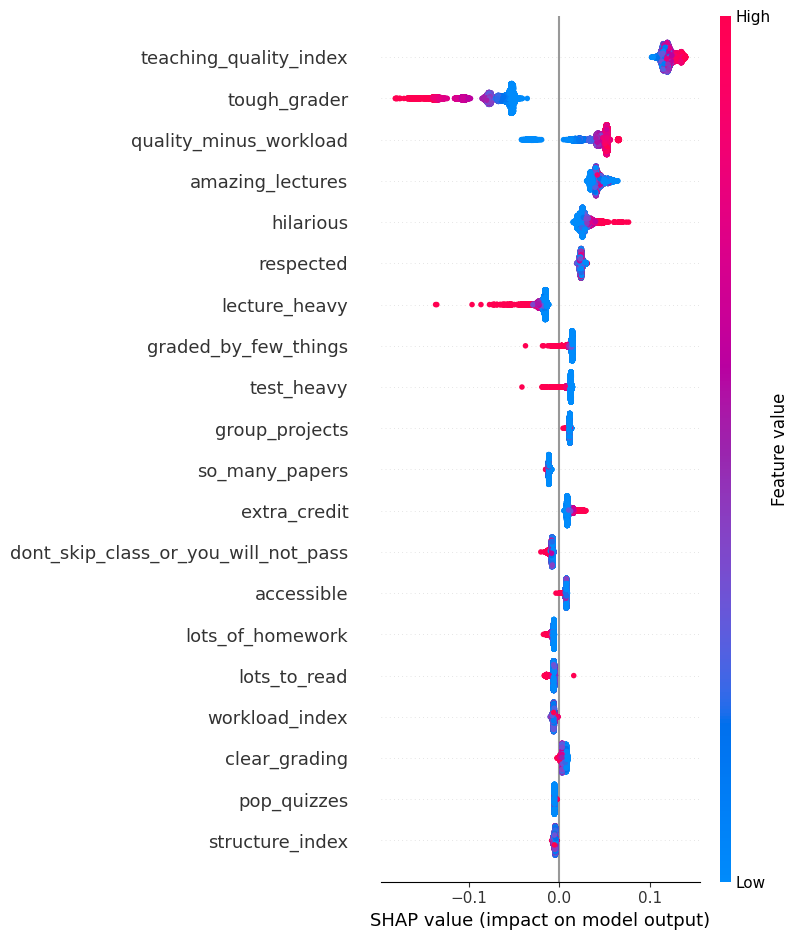

In [72]:
# shapley values
explainer = shap.TreeExplainer(lgbm_pipe_q8.named_steps["model"])
shap_values = explainer.shap_values(x_train_8)   

# plot 
shap.summary_plot(shap_values, x_train_8)

To interpret the LightGBM model, we examine SHAP values rather than coefficients. The SHAP summary plot shows a clear and consistent structure. The `teaching_quality_index` is the dominant predictor, with higher values strongly increasing predicted ratings. `Tough_grader` remains the most influential negative factor, with high values sharply reducing predictions. The contrast feature `quality_minus_workload` also appears among the most important drivers, confirming that the relative balance between instructional quality and workload is more informative than either dimension alone. Several individual tags, including `amazing_lectures`, `hilarious`, `respected`, and `lecture_heavy`, continue to contribute meaningfully, but their effects are now allowed to be non-linear and conditional on other features.

Unlike the linear models, LightGBM does not require explicit feature pruning. Weak predictors are naturally down-weighted through tree splits and regularization. As a result, we do not impose sparsity constraints at this stage. Instead, SHAP provides a direct ranking of feature influence while preserving full predictive capacity.

Overall, LightGBM represents a clear performance frontier for this task. The improvement over linear models is large and consistent across cross-validation and the held-out test set. In the next step, we compare this result to XGBoost to determine whether further gains are possible or whether LightGBM already represents the best achievable tradeoff for this feature set.

#### XGBoost 

In [73]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe_q8 = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model
    ("model", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=n_number,
        n_jobs=1,
        verbosity=0
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1e-2, 50.0, log=True),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 0.5),

        # extra capacity control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    # clone parameters and model pipeline
    pipe = clone(xgb_pipe_q8)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study
study_xgb = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)


[I 2026-01-28 18:50:39,509] A new study created in memory with name: no-name-82ae03e5-6550-4829-b0df-a1fc1b79bdb7
[I 2026-01-28 18:50:44,047] Trial 0 finished with value: 0.4753348670520271 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 0.17689663027883612, 'model__n_estimators': 1709, 'model__learning_rate': 0.010162654352368208, 'model__subsample': 0.7434522575663386, 'model__colsample_bytree': 0.7445336836373633, 'model__reg_alpha': 8.280449747344628e-08, 'model__reg_lambda': 5.3874727250769205e-06, 'model__gamma': 0.3776671724026525, 'model__max_delta_step': 7}. Best is trial 0 with value: 0.4753348670520271.
[I 2026-01-28 18:50:49,331] Trial 1 finished with value: 0.47976746399643205 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 2.2755784987429224, 'model__n_estimators': 2888, 'model__learning_rate': 0.014357845660171998, 'model__subsample': 0.9468649720171275, 'model__colsample_bytree': 0.6806109309369683, 'model__reg_alpha': 4.42093199059

Best Params: {'model__max_depth': 6, 'model__min_child_weight': 46.922365121578125, 'model__n_estimators': 636, 'model__learning_rate': 0.011560538370528685, 'model__subsample': 0.6674554044586252, 'model__colsample_bytree': 0.6904619556631428, 'model__reg_alpha': 1.3588536919499147e-05, 'model__reg_lambda': 8.948945468091711e-05, 'model__gamma': 0.07440558176815762, 'model__max_delta_step': 10}


In [74]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
xgb_pipe_q8.set_params(**study_xgb.best_params)

cv_results_raw_xgb_q8 = cross_validate(
    xgb_pipe_q8,
    x_train_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
rows.append({
    "model": "Tuned XGBoost",
    "R2_mean": cv_results_raw_xgb_q8["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_xgb_q8["test_neg_root_mean_squared_error"]).mean()
})

# check as dataframe 
compare_models_q8_df = pd.DataFrame(rows).reset_index(drop = True).sort_values(by = "RMSE_mean")
compare_models_q8_df

model   R2_mean  RMSE_mean  threshold  \
12                       Tuned LightGBM  0.737889   0.472995        NaN   
13                        Tuned XGBoost  0.737301   0.473511        NaN   
0                      LinearRegression  0.707867   0.499387        NaN   
1                               RidgeCV  0.707794   0.499451        NaN   
11          ElaticNetCV, contrast index  0.707634   0.499583        NaN   
9      ElaticNetCV, engineered features  0.707628   0.499588        NaN   
2                               LassoCV  0.707458   0.499734        NaN   
3                          ElasticNetCV  0.707454   0.499736        NaN   
4             Lasso CV, top 12 features  0.700520   0.505618       0.05   
10  Lasso CV, top 9 engineered features  0.700236   0.505856       0.05   
5             Lasso CV, top 10 features  0.687853   0.516206       0.10   
6              Lasso CV, top 7 features  0.660107   0.538656       0.15   
7              Lasso CV, top 4 features  0.526415   0.635887       0.19   
8              Lasso CV, top 3 features  0.449445   0.685610       0.20   

    n_features  
12         NaN  
13         NaN  
0          NaN  
1          NaN  
11        24.0  
9          NaN  
2          NaN  
3          NaN  
4         12.0  
10         9.0  
5         10.0  
6          7.0  
7          4.0  
8          3.0

Looking at cross-validated performance only, both tuned LightGBM and tuned XGBoost clearly dominate all linear models. LightGBM achieves the best overall performance with cross-validated RMSE ≈ 0.473 and R² ≈ 0.738, while XGBoost is extremely close with RMSE ≈ 0.474 and R² ≈ 0.737. The difference between the two boosting models is negligible and well within cross-validation noise. Given this, we do not further evaluate the held-out test set for XGBoost, as no meaningful additional insight would be gained.

To conclude, we identify two **“best”** models depending on the modeling objective.
- Our best balance model, trading off interpretability, sparsity, and performance - is the `LassoCV model` with 9 engineered features, which achieves strong predictive accuracy while remaining fully interpretable through standardized coefficients.

- Our performance-maximization model, which is only partially interpretable - is the tuned `LightGBM`, which substantially outperforms all linear models and captures non-linear effects and interactions that linear methods cannot.

This gap confirms that while linear models are sufficient for understanding dominant drivers of ratings, non-linear gradient boosting models are required to reach the upper bound of predictive performance for this task.

## Q9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? 

### Linear Regression

In [66]:
# first, make a subset of all variables that are needed. 
df_9 = df_filtered_final[["average_difficulty"] + df_tags_column_names].copy()

# check 
df_9.info()



<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_difficulty                    18422 non-null  float64
 1   tough_grader                          18422 non-null  float64
 2   good_feedback                         18422 non-null  float64
 3   respected                             18422 non-null  float64
 4   lots_to_read                          18422 non-null  float64
 5   participation_matters                 18422 non-null  float64
 6   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 7   lots_of_homework                      18422 non-null  float64
 8   inspirational                         18422 non-null  float64
 9   pop_quizzes                           18422 non-null  float64
 10  accessible                            18422 non-null  float64
 11  so_many_papers                 

In [67]:
# separate y (dependent variable) and x(independent variables)
y = df_9["average_difficulty"]
x = df_9.drop(columns = "average_difficulty")

# check 
x.info()

<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          18422 non-null  float64
 1   good_feedback                         18422 non-null  float64
 2   respected                             18422 non-null  float64
 3   lots_to_read                          18422 non-null  float64
 4   participation_matters                 18422 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 6   lots_of_homework                      18422 non-null  float64
 7   inspirational                         18422 non-null  float64
 8   pop_quizzes                           18422 non-null  float64
 9   accessible                            18422 non-null  float64
 10  so_many_papers                        18422 non-null  float64
 11  clear_grading                  

In [68]:
# split the data
x_train_9, x_test_9, y_train_9, y_test_9 = train_test_split(x, y, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_9.shape[0]}\n')
print(f'Number of rows for test data:{y_test_9.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



Quite good amount of rows both in training and test data, we can proceed with the analysis. 

In [69]:
# correlations between y and x predictors 
# based on training data
corr_yx_q9= x_train_9.corrwith(y_train_9, 
                            method = 'pearson').sort_values(ascending= False)
# check 
corr_yx_q9

tough_grader                            0.656348
dont_skip_class_or_you_will_not_pass    0.288862
lots_of_homework                        0.270708
lots_to_read                            0.249985
test_heavy                              0.243723
lecture_heavy                           0.177278
so_many_papers                          0.147911
pop_quizzes                             0.107886
accessible                              0.013982
graded_by_few_things                   -0.004150
group_projects                         -0.018438
participation_matters                  -0.091428
extra_credit                           -0.178687
amazing_lectures                       -0.208105
good_feedback                          -0.247711
clear_grading                          -0.268268
inspirational                          -0.271053
hilarious                              -0.283272
respected                              -0.339784
caring                                 -0.349328
dtype: float64

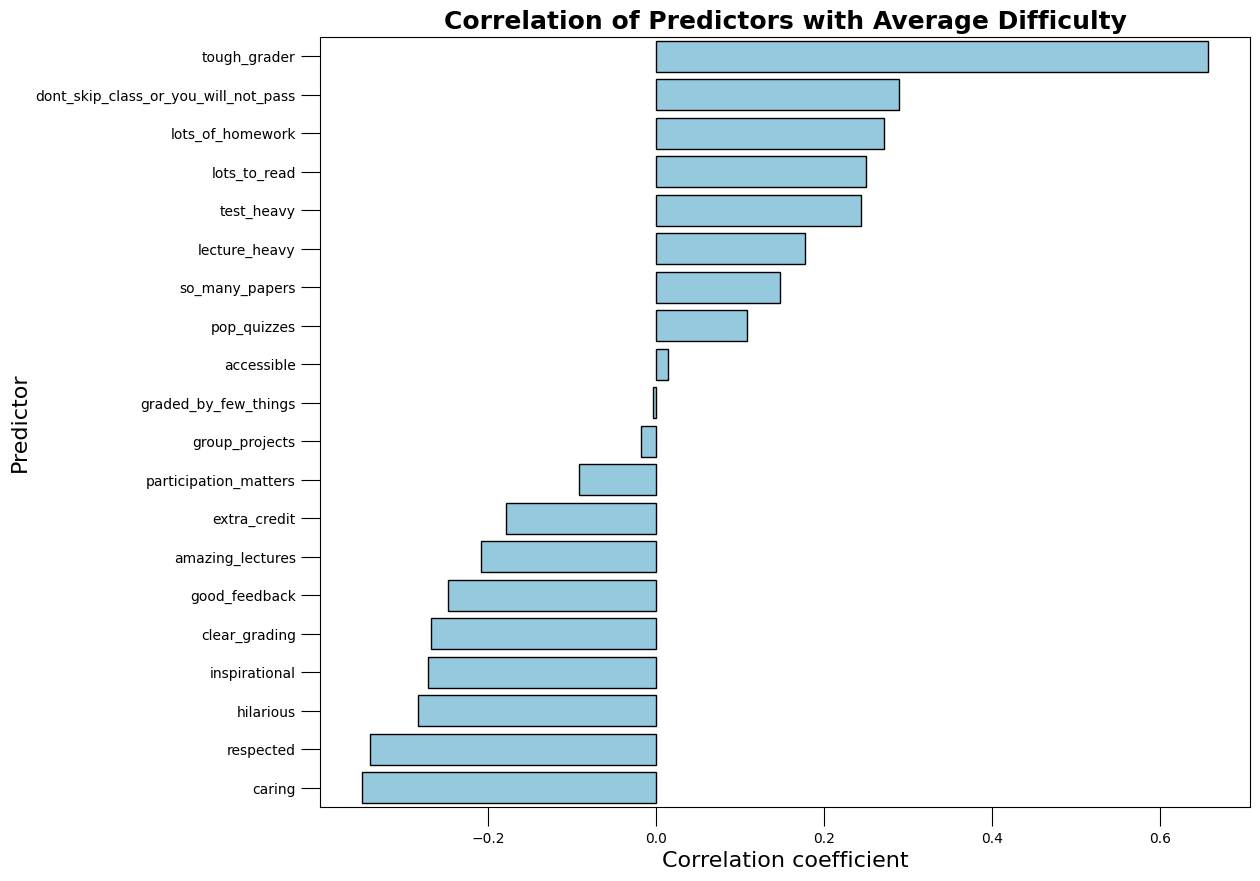

In [70]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx_q9, 
            orient= 'h', 
            color = 'skyblue', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

These correlations describe how students associate course characteristics with perceived difficulty.

Difficulty is driven primarily by grading strictness and workload.
The strongest positive correlation is tough grader (0.66). This dominates all other predictors and clearly anchors students’ notion of difficulty. Additional workload signals reinforce this perception. Don’t skip class or you will not pass (0.29), lots of homework (0.27), lots to read (0.25), test heavy (0.24), and lecture heavy (0.18) all move in the same direction. These tags describe time pressure, assessment intensity, and rigid structure, which students consistently interpret as higher difficulty.

Administrative and minor course features matter little.
Tags such as accessible (0.01), graded by few things (-0.00), and group projects (-0.02) show near-zero correlation. They do not meaningfully influence perceived difficulty.

Teaching quality works in the opposite direction.
All strong negative correlations reflect instructor quality and classroom experience. Caring (-0.35), respected (-0.34), hilarious (-0.28), inspirational (-0.27), clear grading (-0.27), good feedback (-0.25), and amazing lectures (-0.21) are associated with lower perceived difficulty. Students interpret clarity, support, and engagement as making courses feel easier, even when content may still be demanding.

In [71]:
# correlation matrix among tags
corr_xx_q9 = x_train_9.corr()

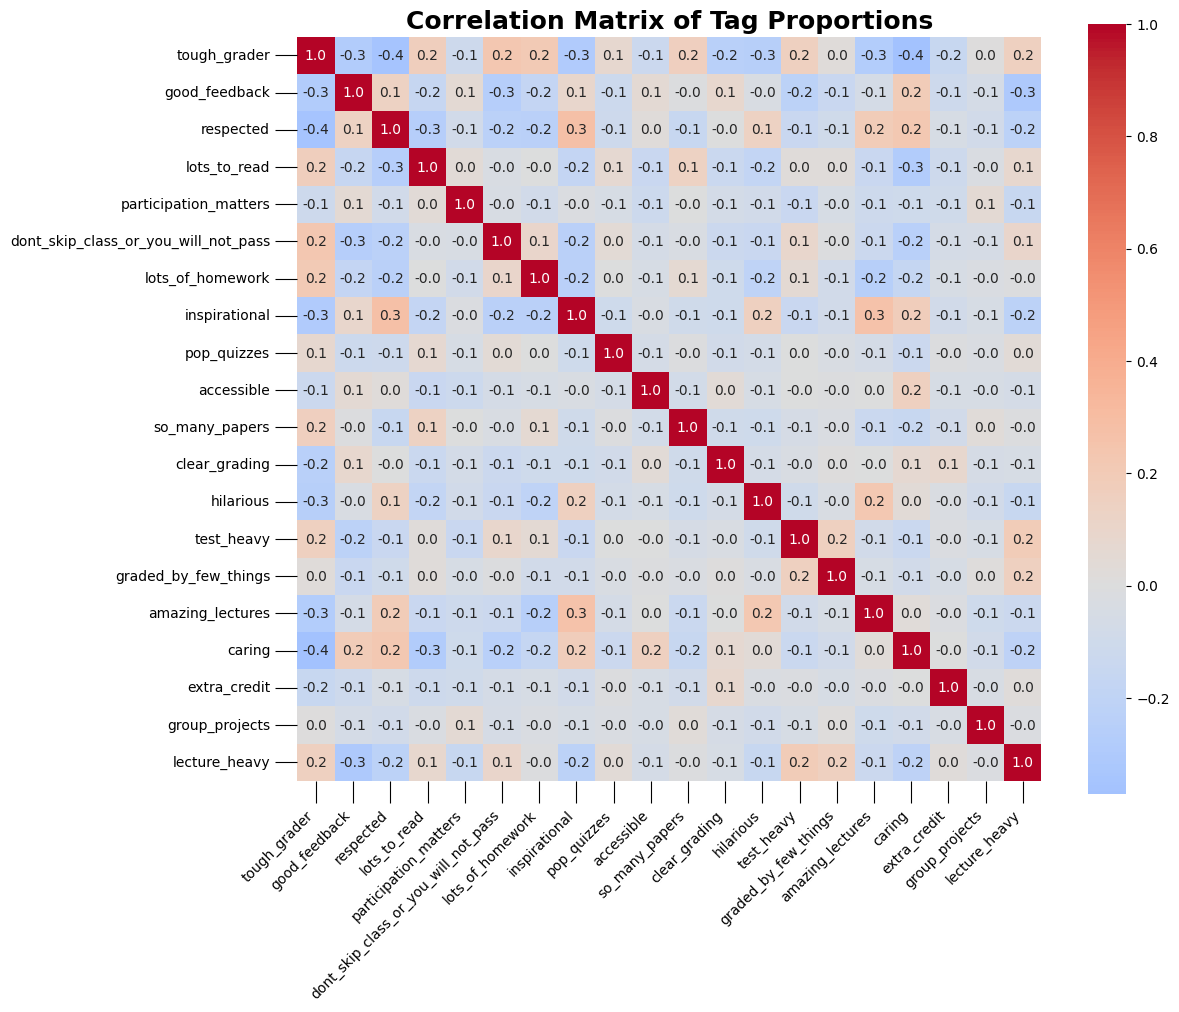

In [72]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx_q9,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Tag Proportions", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

This correlation matrix confirms the absence of multicollinearity among the tag proportions.

All pairwise correlations remain well below 0.7. Most values lie between -0.4 and 0.4, with no tightly coupled clusters. Even conceptually related tags, such as caring, respected, amazing lectures, and inspirational, show only moderate correlations. Workload-related tags also move together weakly rather than forming a single block.

This means the tags capture distinct dimensions of course experience rather than redundant information. As a result, linear models do not suffer from coefficient instability driven by multicollinearity, and regularization is not required for numerical reasons.

This supports the modeling choices in Q9. We can interpret coefficients directly and attribute effects to individual tags with confidence, without concern that strong correlations are distorting estimates.

We therefore fit and compare three linear specifications: ordinary least squares, Ridge, Lasso, and ElasticNet using the same cross-validation setup.

The purpose here is not to resolve multicollinearity, since the correlation analysis shows no problematic dependence among predictors, but to verify whether regularization improves stability or predictive performance. Ordinary least squares serves as the baseline. Ridge tests whether mild shrinkage improves generalization when predictors are moderately correlated. Lasso tests whether automatic feature selection yields a more parsimonious model without sacrificing accuracy.

Comparing these three models allows us to confirm whether regularization provides any practical benefit in this setting and to justify the final linear specification on empirical grounds rather than assumption.

In [73]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for linear model comparison (no imputation)
pipelines_linear_q9 = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "RidgeCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(
            alphas=np.logspace(-4, 4, 50),
            cv=cv
        ))
    ]),

    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ]),

    "ElasticNetCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.9],
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ])
}

# compare models
rows = []
for name, pipe in pipelines_linear_q9.items():
    results = cross_validate(
        pipe,
        x_train_9,
        y_train_9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

compare_models_q9_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check results 
compare_models_q9_df

model   R2_mean  RMSE_mean
0  LinearRegression  0.550526   0.540656
1      ElasticNetCV  0.550509   0.540673
2           LassoCV  0.550499   0.540679
3           RidgeCV  0.550294   0.540797

In [74]:
# check models on test data
for name, pipe in pipelines_linear_q9.items():
    print(f"\nModel: {name}")
    print(score_model(
        pipe,
        x_train_9,
        x_test_9,
        y_train_9,
        y_test_9
    ))


Model: LinearRegression
{'Training RMSE': 0.5393303456368387, 'Training R2': 0.5528540217842544, 'Testing RMSE': 0.5413209790590664, 'Testing R2': 0.5472489239116028}

Model: RidgeCV
{'Training RMSE': 0.5394170440708607, 'Training R2': 0.5527102510050682, 'Testing RMSE': 0.5409324647369641, 'Testing R2': 0.547898583396655}

Model: LassoCV
{'Training RMSE': 0.5394458846539484, 'Training R2': 0.5526624199542269, 'Testing RMSE': 0.5409324377512, 'Testing R2': 0.5478986285050655}

Model: ElasticNetCV
{'Training RMSE': 0.5395375221190879, 'Training R2': 0.5525104256027569, 'Testing RMSE': 0.540793927305372, 'Testing R2': 0.5481301278231343}


All four linear models perform almost identically. Cross-validated RMSE differs by less than 0.001, and test-set RMSE and R² are essentially the same across models. These differences are far below any practical significance threshold.

Given this, model choice should be driven by structure and interpretability rather than marginal performance.

Lasso is preferred for three reasons.

First, it delivers comparable predictive accuracy to OLS, Ridge, and Elastic Net. There is no meaningful loss in fit.

Second, it enforces sparsity. Coefficients for weak or redundant tags are shrunk exactly to zero, yielding a simpler model that is easier to explain and reason about.

Third, it aligns with the goal of identifying the most influential teaching attributes rather than stabilizing all coefficients. Ridge and Elastic Net improve numerical stability, but earlier analysis showed no serious multicollinearity. That benefit is therefore unnecessary here.

For these reasons, we proceed with the Lasso model as the final linear specification in Q9. The choice reflects a deliberate preference for parsimony and interpretability, not a tradeoff in predictive performance.

#### Lasso Regression

In [75]:
# fixed CV 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for Lasso Regression model 
pipeline_q9 = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,

        max_iter=10000
    ))
])

# fit 
pipeline_q9.fit(x_train_9, 
                y_train_9)

# extract feature weights from the model
model_q9 = pipeline_q9.named_steps["model"]

# feature names
feature_names_q9 = x_train_9.columns.to_list()
# coefficients
coef_q9 = model_q9.coef_

# build dataframe
weights_df_q9 = pd.DataFrame({
    "tag": feature_names_q9,
    "weight": coef_q9
})

# sort by absolute weight
weights_df_q9["abs_weight"] = weights_df_q9["weight"].abs()
weights_df_q9 = weights_df_q9.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_q9 = weights_df_q9.drop(columns="abs_weight").reset_index(drop=True)
# check 
weights_df_q9

tag    weight
0                           tough_grader  0.292539
1                          clear_grading -0.143320
2                              hilarious -0.137110
3                                 caring -0.126269
4                           extra_credit -0.116804
5                              respected -0.101465
6                  participation_matters -0.085235
7                          good_feedback -0.081337
8                          inspirational -0.067888
9                             test_heavy  0.067648
10                  graded_by_few_things -0.066107
11                        group_projects -0.061838
12                            accessible  0.051394
13                      amazing_lectures -0.036943
14                         lecture_heavy -0.034334
15                          lots_to_read  0.017363
16  dont_skip_class_or_you_will_not_pass  0.016309
17                           pop_quizzes -0.010463
18                      lots_of_homework  0.008387
19                        so_many_papers -0.005143

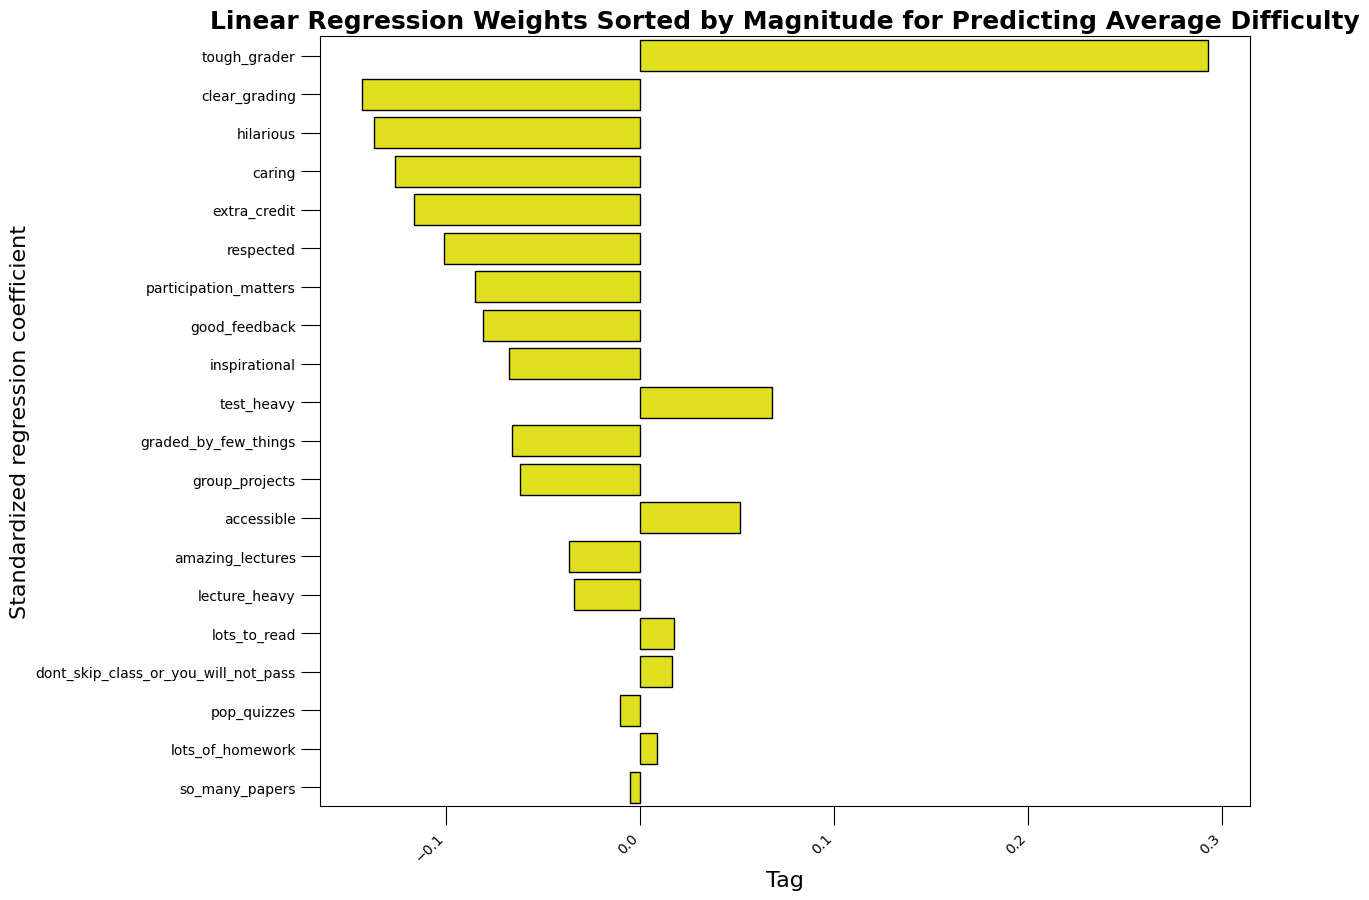

In [76]:
# Plot weights (coefficients)
# figure size 
plt.figure(figsize=(12, 10))

# plot itself 
sns.barplot(
    data=weights_df_q9,
    x="weight",
    y="tag",
    color="yellow",
    edgecolor="black", 
    orient= "h"
)

# title 
plt.title("Linear Regression Weights Sorted by Magnitude for Predicting Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel 
plt.xlabel("Tag", fontsize = 16)
# ylabel
plt.ylabel("Standardized regression coefficient", 
           fontsize = 16)

# ticks
plt.xticks(rotation=45, ha="right")
plt.tick_params(size = 14)

# show the plot 
plt.show()

We can see that the `average difficulty` of professors is primarily explained by a small subset of the 13 predictors. In particular, `tough_grader` shows by far the largest standardized weight, indicating that it is the strongest contributor to perceived difficulty. A few additional variables (such as `clear_grading`, `hilarious`, `caring`, `extra_credit`, and `test_heavy`) have moderate effects, while most of the remaining predictors have standardized coefficients that are very small or close to zero, suggesting minimal influence on the response variable.

Therefore, to make our model more parsimonious and sparse - without sacrificing predictive performance - we remove predictors whose absolute standardized weight is below 0.05. This feature selection step simplifies the model while retaining the most informative variables for predicting average professor difficulty.

In [77]:
# reduce to only significant features (|weight| >= 0.05)
selected_features_q9 = weights_df_q9[weights_df_q9["weight"].abs() >= 0.05]["tag"].tolist()

# reduce training and testing data
x_train_reduced_9 = x_train_9[selected_features_q9]
x_test_reduced_9 = x_test_9[selected_features_q9]

# cross-validation
# fixed CV
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline for Lasso regression with reduced features 
pipeline_q9_reduced = Pipeline([ 
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv = cv, 
        random_state = n_number, 
        alphas = 100, 
        max_iter = 10000))

])

# run cross_validation 
cv_results_raw_9_reduced = cross_validate(
    pipeline_q9_reduced, 
    x_train_reduced_9,
    y_train_9, 
    cv = cv,
    n_jobs = -1, 
    scoring = ("r2", 
               "neg_root_mean_squared_error")
)

# save results 
cv_results_9_reduced = {
    "R2_mean": cv_results_raw_9_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_9_reduced["test_neg_root_mean_squared_error"]).mean()
}

# append to our existing results list 
rows.append({
    "model": f"LassoCV with {len(x_train_reduced_9.columns)} variables", 
    "R2_mean": cv_results_9_reduced["R2_mean"], 
    "RMSE_mean": cv_results_9_reduced["RMSE_mean"]
})


# check results as dataframe 
compare_models_q9_df = (pd.DataFrame(rows) 
                        .sort_values(by = "RMSE_mean", 
                                     ascending = True)
                        .reset_index(drop = True))

compare_models_q9_df

model   R2_mean  RMSE_mean
0           LinearRegression  0.550526   0.540656
1               ElasticNetCV  0.550509   0.540673
2                    LassoCV  0.550499   0.540679
3                    RidgeCV  0.550294   0.540797
4  LassoCV with 13 variables  0.547207   0.542652

In [78]:
# score the model on test data
print("Model performance with the most 13 important features:\n")
score_model(pipeline_q9_reduced, 
            x_train_reduced_9, 
            x_test_reduced_9, 
            y_train_9, 
            y_test_9)

Model performance with the most 13 important features:



{'Training RMSE': 0.5421035753372501,
 'Training R2': 0.5482437614927931,
 'Testing RMSE': 0.5436101276702867,
 'Testing R2': 0.5434116224137642}

In [79]:
# score the model on test data 
print("Model performance with all features:\n")
score_model(pipeline_q9, 
            x_train_9, 
            x_test_9, 
            y_train_9, 
            y_test_9)

Model performance with all features:



{'Training RMSE': 0.5394458846539484,
 'Training R2': 0.5526624199542269,
 'Testing RMSE': 0.5409324377512,
 'Testing R2': 0.5478986285050655}

In [80]:
# check final model weights 
# extract feature weights from the model
model_q9 = pipeline_q9_reduced.named_steps["model"]

# feature names
feature_names_q9 = x_train_reduced_9.columns.to_list()
# coefficients
coef_q9 = model_q9.coef_

# build dataframe
weights_df_q9 = pd.DataFrame({
    "tag": feature_names_q9,
    "weight": coef_q9
})

# sort by absolute weight
weights_df_q9["abs_weight"] = weights_df_q9["weight"].abs()
weights_df_q9 = weights_df_q9.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_q9 = weights_df_q9.drop(columns="abs_weight").reset_index(drop=True)
# check 
weights_df_q9

tag    weight
0            tough_grader  0.306377
1           clear_grading -0.142697
2               hilarious -0.140308
3                  caring -0.122311
4            extra_credit -0.116583
5               respected -0.103706
6   participation_matters -0.075322
7           inspirational -0.073372
8           good_feedback -0.072360
9    graded_by_few_things -0.068707
10             test_heavy  0.067897
11         group_projects -0.059421
12             accessible  0.052234

Reducing the model from 20 tag features to 13 selected predictors results in only a marginal decline in performance. The reduced Lasso model achieves a testing RMSE of 0.544 and an R² of 0.543, compared to RMSE = 0.541 and R² = 0.548 for the full model. Training metrics show a similarly small gap, indicating consistent behavior across splits.

Cross-validation results further support this finding. Linear and regularized linear models (Ridge, Lasso, Elastic Net) perform nearly identically, with mean RMSE values clustered around 0.541 and mean R² around 0.55. Restricting the Lasso model to the 13 most influential predictors leads to a slight reduction in cross-validated performance, but the difference remains negligible in practical terms.

Overall, the small performance gap suggests that most of the predictive signal is concentrated in a core subset of teaching-related tags. The excluded features contribute limited incremental information once the dominant predictors - such as grading strictness and assessment structure - are accounted for. As a result, the reduced model offers substantially improved interpretability with minimal loss in predictive accuracy, making it a reasonable and defensible simplification.

At this point, the original research question has been effectively answered: average difficulty ratings are largely driven by a limited set of teaching characteristics, with diminishing marginal returns from additional tags. Having established a strong and interpretable baseline, we now shift focus beyond explanation toward optimization. In the next stage, we explore feature engineering and higher-capacity modeling approaches - such as interaction terms and nonlinear models - to evaluate whether additional structure can yield meaningful improvements in predictive performance while maintaining model parsimony.

### Extra: Feature Engineering

#### Index Features 

In [81]:
x_train_9.info()

<class 'pandas.DataFrame'>
Index: 14737 entries, 69507 to 16707
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          14737 non-null  float64
 1   good_feedback                         14737 non-null  float64
 2   respected                             14737 non-null  float64
 3   lots_to_read                          14737 non-null  float64
 4   participation_matters                 14737 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  14737 non-null  float64
 6   lots_of_homework                      14737 non-null  float64
 7   inspirational                         14737 non-null  float64
 8   pop_quizzes                           14737 non-null  float64
 9   accessible                            14737 non-null  float64
 10  so_many_papers                        14737 non-null  float64
 11  clear_grading              

In [82]:
# check correlation again 
corr_yx_q9

tough_grader                            0.656348
dont_skip_class_or_you_will_not_pass    0.288862
lots_of_homework                        0.270708
lots_to_read                            0.249985
test_heavy                              0.243723
lecture_heavy                           0.177278
so_many_papers                          0.147911
pop_quizzes                             0.107886
accessible                              0.013982
graded_by_few_things                   -0.004150
group_projects                         -0.018438
participation_matters                  -0.091428
extra_credit                           -0.178687
amazing_lectures                       -0.208105
good_feedback                          -0.247711
clear_grading                          -0.268268
inspirational                          -0.271053
hilarious                              -0.283272
respected                              -0.339784
caring                                 -0.349328
dtype: float64

In [83]:
# teaching quality group
teaching_quality = [
    "good_feedback", "respected", "inspirational",
    "amazing_lectures", "caring", "clear_grading", 
    "hilarious"
]

# workload group
workload = [
    "tough_grader", "lots_of_homework", "lots_to_read",
    "lecture_heavy", "test_heavy", "so_many_papers", 
]

# structure group
structure_positive = [
    "pop_quizzes", 
    "dont_skip_class_or_you_will_not_pass"]

structure_negative = [
    "graded_by_few_things", 
    "group_projects",
    "participation_matters",
    "extra_credit"
]


# index indicator of tough grader 
x_train_9["very_tough_grader"] = (x_train_9["tough_grader"] > 0.6).astype(int)
x_test_9["very_tough_grader"] = (x_test_9["tough_grader"] > 0.6).astype(int)

# create new index features 
# train data 
x_train_9["teaching_quality_index"] = x_train_9[teaching_quality].mean(axis=1)
x_train_9["workload_index"] = x_train_9[workload].mean(axis=1)
x_train_9["structure_index_positive"] = x_train_9[structure_positive].mean(axis=1)
x_train_9["structure_index_negative"] = x_train_9[structure_negative].mean(axis=1)

# test data 
x_test_9["teaching_quality_index"] = x_test_9[teaching_quality].mean(axis=1)
x_test_9["workload_index"] = x_test_9[workload].mean(axis=1)
x_test_9["structure_index_positive"] = x_test_9[structure_positive].mean(axis=1)
x_test_9["structure_index_negative"] = x_test_9[structure_negative].mean(axis=1)

In [84]:
# correlations of predictors and target variables 
cor_9_y_features = (
    x_train_9
    .corrwith(y_train_9)
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

cor_9_y_features

tough_grader                            0.656348
workload_index                          0.641604
teaching_quality_index                 -0.595354
caring                                 -0.349328
respected                              -0.339784
structure_index_positive                0.299812
dont_skip_class_or_you_will_not_pass    0.288862
hilarious                              -0.283272
inspirational                          -0.271053
lots_of_homework                        0.270708
clear_grading                          -0.268268
lots_to_read                            0.249985
good_feedback                          -0.247711
test_heavy                              0.243723
amazing_lectures                       -0.208105
extra_credit                           -0.178687
lecture_heavy                           0.177278
structure_index_negative               -0.176415
so_many_papers                          0.147911
pop_quizzes                             0.107886
participation_matter

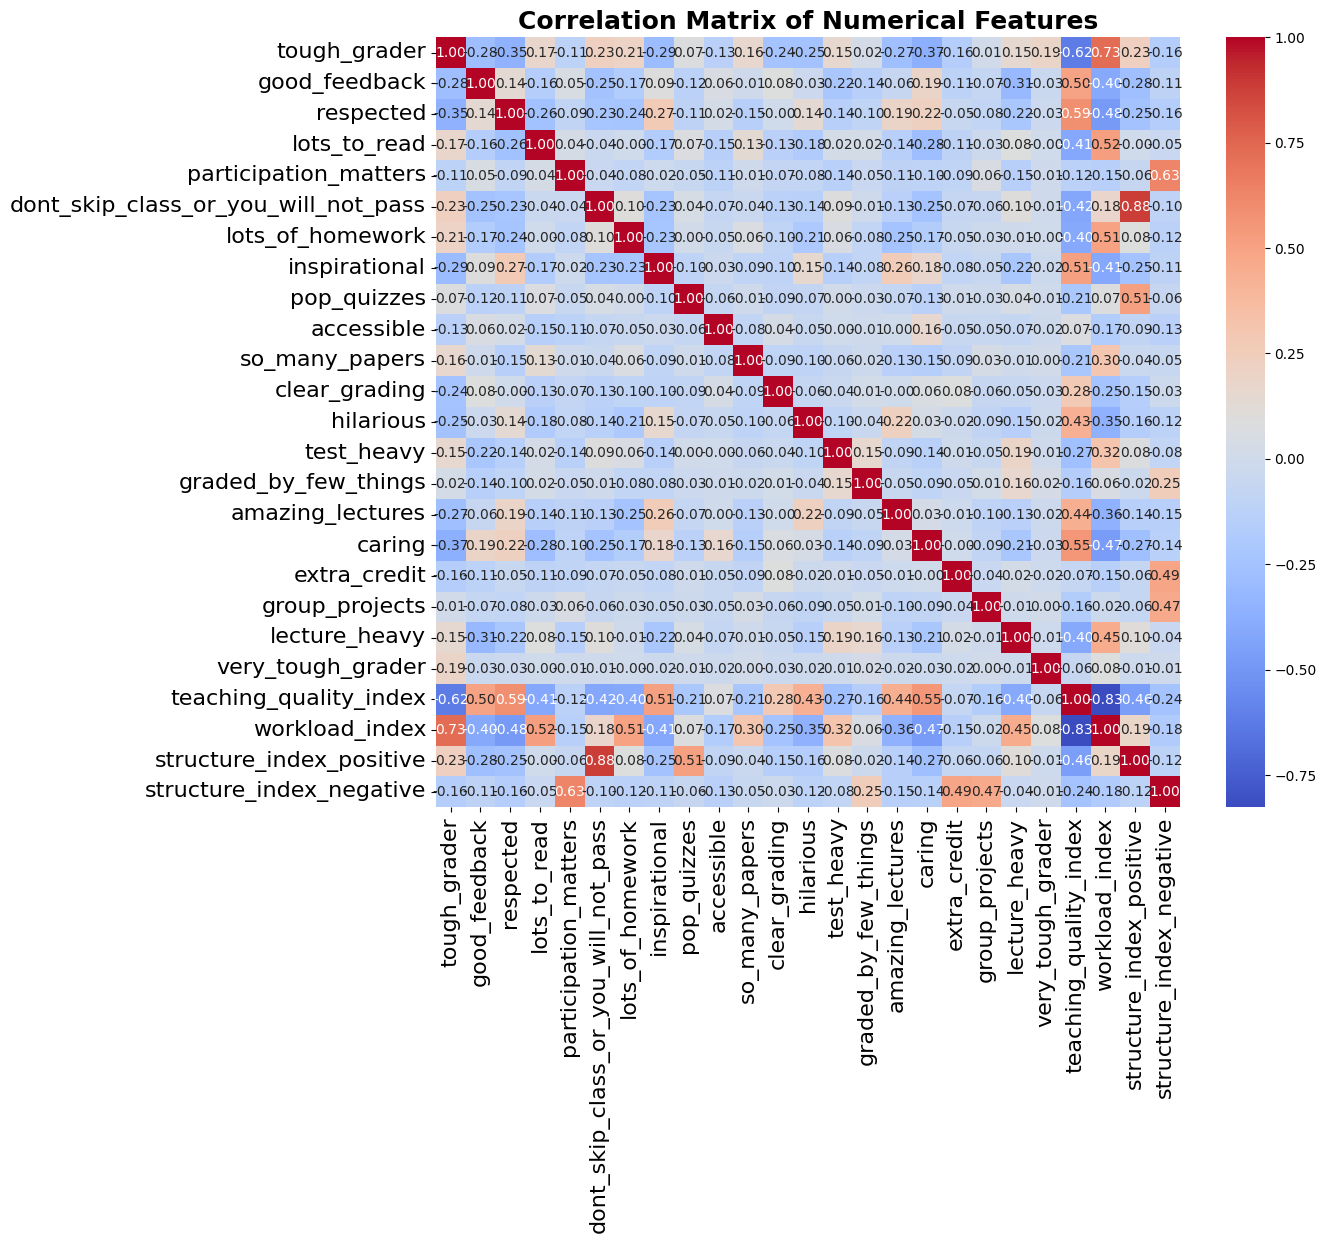

In [85]:
# correlations between predictors 
corr_9_x = x_train_9.corr()

# plot 
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_9_x, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


In [86]:
# cv 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

pipeline_q9_features = Pipeline([
        # scaler
        ("scaler", StandardScaler()),
        # model
        ("model", ElasticNetCV(
            cv=cv,
            random_state=n_number,
            n_alphas=100,
            max_iter=10000
        ))
    ])

# cross_validation
cv_q9_raw_features = cross_validate(
        pipeline_q9_features,
        x_train_9,
        y_train_9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
    "model": "ElaticNetCV, engineered features",
        "R2_mean": cv_q9_raw_features["test_r2"].mean(),
        "RMSE_mean": -cv_q9_raw_features["test_neg_root_mean_squared_error"].mean()
    })

# create and show dataframe 
compare_models_q9_df = ( 
pd.DataFrame(rows)
.reset_index(drop = True)
.sort_values(by = "RMSE_mean") )

# check the data 
compare_models_q9_df

model   R2_mean  RMSE_mean
5  ElaticNetCV, engineered features  0.551908   0.539831
0                  LinearRegression  0.550526   0.540656
3                      ElasticNetCV  0.550509   0.540673
2                           LassoCV  0.550499   0.540679
1                           RidgeCV  0.550294   0.540797
4         LassoCV with 13 variables  0.547207   0.542652

In [87]:
# LassoCV with top 13 features performance on the test data:
print("LassoCV with top 13 features:\n")
score_model(pipeline_q9_reduced,
            x_train_reduced_9, 
            x_test_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 13 features:



{'Training RMSE': 0.5421035753372501,
 'Training R2': 0.5482437614927931,
 'Testing RMSE': 0.5436101276702867,
 'Testing R2': 0.5434116224137642}

In [88]:
# ElasticNetCV with engineered features on test data:
print("ElasticNetCV with engineered variables:\n")
score_model(pipeline_q9_features,
            x_train_9, 
            x_test_9, 
            y_train_9, 
            y_test_9)

ElasticNetCV with engineered variables:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


{'Training RMSE': 0.5386621093282663,
 'Training R2': 0.5539613730487845,
 'Testing RMSE': 0.5391725087628603,
 'Testing R2': 0.5508356753517891}

In [89]:
# model
model = pipeline_q9_features.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_9.columns
coef = model.coef_


# create the dataframe
weights_df_9 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_9["abs_weight"] = weights_df_9["weight"].abs()

weights_df_9 = (
    weights_df_9
    .sort_values("abs_weight", ascending=False)
    .drop(columns="abs_weight")
    .reset_index(drop=True)
)

# check results
weights_df_9


tag    weight
0                           tough_grader  0.281023
1                 teaching_quality_index -0.262310
2               structure_index_negative -0.147003
3                          clear_grading -0.082156
4                              hilarious -0.067816
5                             test_heavy  0.060462
6                                 caring -0.052326
7                          lecture_heavy -0.047171
8                             accessible  0.043535
9                           extra_credit -0.041550
10                             respected -0.034482
11                     very_tough_grader -0.027832
12                  graded_by_few_things -0.026707
13                      amazing_lectures  0.019719
14                           pop_quizzes -0.018282
15                         inspirational -0.012826
16                        so_many_papers -0.011970
17                      lots_of_homework -0.005920
18                        group_projects -0.004594
19                          lots_to_read  0.002406
20  dont_skip_class_or_you_will_not_pass  0.001614
21                         good_feedback -0.000000
22                 participation_matters  0.000000
23                        workload_index  0.000000
24              structure_index_positive  0.000000

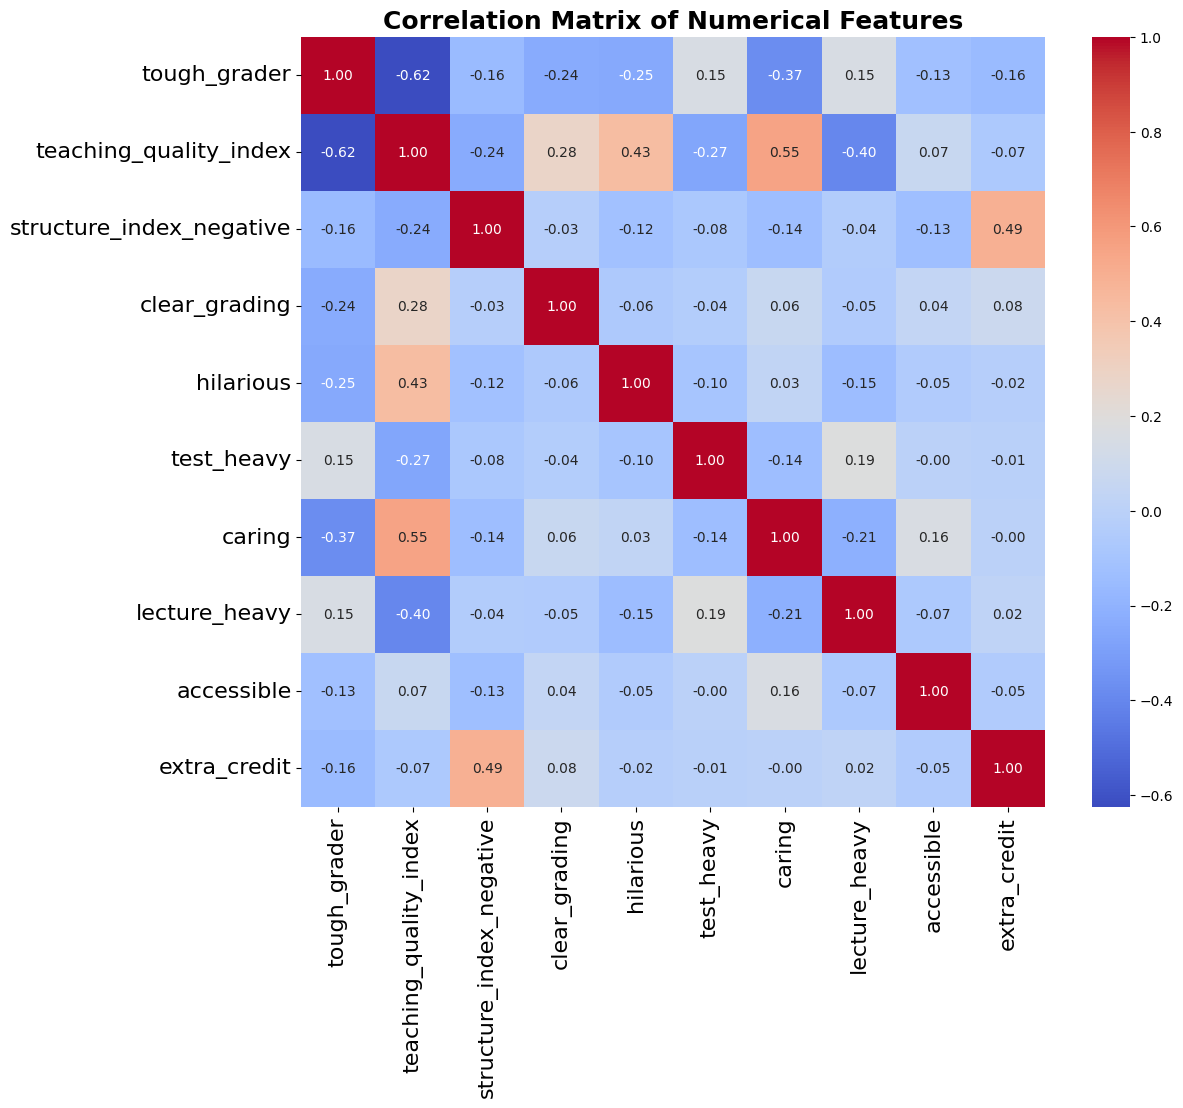

In [98]:
# reduce the data to feature with >= |0.05| weight
selected = weights_df_9.loc[weights_df_9["weight"].abs() >= 0.04, "tag"].tolist()
x_train_features_reduced_9 = x_train_9[selected]
x_test_features_reduced_9 = x_test_9[selected]

# corelations 
corr_features = x_train_features_reduced_9.corr()

# check correlation for multicollinearity 
# plot  #height, width 
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()

In [99]:
# pipeline
pipeline_q9_features_reduced = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model 
    ("model", LassoCV(
        cv=cv, 
        random_state=n_number, 
        alphas = 100, 
        max_iter=10000))
    ])

# cross_validation
cv_raw_features_9 = cross_validate(
        pipeline_q9_features_reduced,
        x_train_features_reduced_9,
        y_train_9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
        "model": f"Lasso CV, top {len(x_train_features_reduced_9.columns)} engineered features",
        "threshold": 0.05, 
        "n_features": len(x_train_features_reduced_9.columns),
        "R2_mean": cv_raw_features_9["test_r2"].mean(),
        "RMSE_mean": -cv_raw_features_9["test_neg_root_mean_squared_error"].mean()
    })

# return results as dataframe 
compare_models_q9_df = pd.DataFrame(rows).reset_index(drop = True).sort_values(by = "RMSE_mean")

# check 
compare_models_q9_df

model   R2_mean  RMSE_mean  threshold  \
5      ElaticNetCV, engineered features  0.551908   0.539831        NaN   
0                      LinearRegression  0.550526   0.540656        NaN   
3                          ElasticNetCV  0.550509   0.540673        NaN   
2                               LassoCV  0.550499   0.540679        NaN   
1                               RidgeCV  0.550294   0.540797        NaN   
8  Lasso CV, top 11 engineered features  0.549574   0.541232       0.05   
7  Lasso CV, top 10 engineered features  0.548376   0.541954       0.05   
9  Lasso CV, top 10 engineered features  0.548376   0.541954       0.05   
4             LassoCV with 13 variables  0.547207   0.542652        NaN   
6   Lasso CV, top 7 engineered features  0.540719   0.546530       0.05   

   n_features  
5         NaN  
0         NaN  
3         NaN  
2         NaN  
1         NaN  
8        11.0  
7        10.0  
9        10.0  
4         NaN  
6         7.0

In [100]:
# LassoCV with interactions on test data 
print("LassoCV with top 10 engineered features:\n")
score_model(pipeline_q9_features_reduced,
            x_train_features_reduced_9, 
            x_test_features_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 10 engineered features:



{'Training RMSE': 0.5415048679700165,
 'Training R2': 0.5492410632817086,
 'Testing RMSE': 0.5428844328284201,
 'Testing R2': 0.5446298582380449}

In [101]:
# LassoCV with 13 variables 
print("LassoCV with top 13 variables:\n")
score_model(pipeline_q9_reduced,
            x_train_reduced_9, 
            x_test_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 13 variables:



{'Training RMSE': 0.5421035753372501,
 'Training R2': 0.5482437614927931,
 'Testing RMSE': 0.5436101276702867,
 'Testing R2': 0.5434116224137642}

In [102]:
# model
model = pipeline_q9_features_reduced.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_features_reduced_9.columns
coef = model.coef_


# create the dataframe
weights_df_9 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_9["abs_weight"] = weights_df_9["weight"].abs()

weights_df_9 = (
    weights_df_9
    .sort_values("abs_weight", ascending=False)
    .drop(columns="abs_weight")
    .reset_index(drop=True)
)

# check results
weights_df_9


tag    weight
0    teaching_quality_index -0.279760
1              tough_grader  0.277121
2  structure_index_negative -0.156389
3             clear_grading -0.073998
4                test_heavy  0.059618
5                 hilarious -0.059065
6                    caring -0.048480
7             lecture_heavy -0.047471
8                accessible  0.045848
9              extra_credit -0.033432

#### Contrast Index


In [103]:
# main tradeoff: quality vs workload
x_train_9["quality_minus_workload"] = (
    x_train_9["teaching_quality_index"] - x_train_9["workload_index"]
)

# quality vs each structure dimension
x_train_9["quality_minus_structure_positive"] = (
    x_train_9["teaching_quality_index"] - x_train_9["structure_index_positive"]
)

x_train_9["quality_minus_structure_negative"] = (
    x_train_9["teaching_quality_index"] - x_train_9["structure_index_negative"]
)

# workload vs each structure dimension
x_train_9["workload_minus_structure_positive"] = (
    x_train_9["workload_index"] - x_train_9["structure_index_positive"]
)

x_train_9["workload_minus_structure_negative"] = (
    x_train_9["workload_index"] - x_train_9["structure_index_negative"]
)

# optional: a single net-structure score (strictness-ish vs leniency-ish)
x_train_9["structure_net"] = (
    x_train_9["structure_index_positive"] - x_train_9["structure_index_negative"]
)

# on test 
x_test_9["quality_minus_workload"] = (
    x_test_9["teaching_quality_index"] - x_test_9["workload_index"]
)

x_test_9["quality_minus_structure_positive"] = (
    x_test_9["teaching_quality_index"] - x_test_9["structure_index_positive"]
)

x_test_9["quality_minus_structure_negative"] = (
    x_test_9["teaching_quality_index"] - x_test_9["structure_index_negative"]
)

x_test_9["workload_minus_structure_positive"] = (
    x_test_9["workload_index"] - x_test_9["structure_index_positive"]
)

x_test_9["workload_minus_structure_negative"] = (
    x_test_9["workload_index"] - x_test_9["structure_index_negative"]
)

x_test_9["structure_net"] = (
    x_test_9["structure_index_positive"] - x_test_9["structure_index_negative"]
)

In [104]:
# correlations of predictors and target variables 
cor_9_y_features_contrast = (
    x_train_9
    .corrwith(y_train_9)
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

cor_9_y_features_contrast

tough_grader                            0.656348
quality_minus_workload                 -0.647474
workload_index                          0.641604
teaching_quality_index                 -0.595354
workload_minus_structure_negative       0.563301
quality_minus_structure_positive       -0.500641
caring                                 -0.349328
respected                              -0.339784
structure_net                           0.330776
quality_minus_structure_negative       -0.312480
structure_index_positive                0.299812
dont_skip_class_or_you_will_not_pass    0.288862
hilarious                              -0.283272
inspirational                          -0.271053
lots_of_homework                        0.270708
clear_grading                          -0.268268
lots_to_read                            0.249985
good_feedback                          -0.247711
test_heavy                              0.243723
amazing_lectures                       -0.208105
workload_minus_struc

In [105]:
# cv 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline
pipeline_q9_features_contrast = Pipeline([
        # scaler
        ("scaler", StandardScaler()),
        # model
        ("model", ElasticNetCV(
            cv=cv,
            random_state=n_number,
            alphas = 100,
            max_iter=10000
        ))
    ])

# cross_validation
cv_q9_raw_features_contrast = cross_validate(
        pipeline_q9_features_contrast,
        x_train_9,
        y_train_9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
    "model": "ElaticNetCV, contrast index",
    "n_features": len(x_train_9.columns),
        "R2_mean": cv_q9_raw_features_contrast["test_r2"].mean(),
        "RMSE_mean": -cv_q9_raw_features_contrast["test_neg_root_mean_squared_error"].mean()
    })

# create and show dataframe 
compare_models_q9_df = ( 
pd.DataFrame(rows)
.reset_index(drop = True)
.sort_values(by = "RMSE_mean") )

# check the data 
compare_models_q9_df

model   R2_mean  RMSE_mean  threshold  \
5       ElaticNetCV, engineered features  0.551908   0.539831        NaN   
10           ElaticNetCV, contrast index  0.551828   0.539879        NaN   
0                       LinearRegression  0.550526   0.540656        NaN   
3                           ElasticNetCV  0.550509   0.540673        NaN   
2                                LassoCV  0.550499   0.540679        NaN   
1                                RidgeCV  0.550294   0.540797        NaN   
8   Lasso CV, top 11 engineered features  0.549574   0.541232       0.05   
7   Lasso CV, top 10 engineered features  0.548376   0.541954       0.05   
9   Lasso CV, top 10 engineered features  0.548376   0.541954       0.05   
4              LassoCV with 13 variables  0.547207   0.542652        NaN   
6    Lasso CV, top 7 engineered features  0.540719   0.546530       0.05   

    n_features  
5          NaN  
10        31.0  
0          NaN  
3          NaN  
2          NaN  
1          NaN  
8         11.0  
7         10.0  
9         10.0  
4          NaN  
6          7.0

In [106]:
# check contrast model on test data
print("ElasticNetCV with contrast index:\n")
score_model(pipeline_q9_features_contrast, 
            x_train_9, 
            x_test_9, 
            y_train_9, 
            y_test_9)

ElasticNetCV with contrast index:



{'Training RMSE': 0.5386621179224492,
 'Training R2': 0.5539613588159751,
 'Testing RMSE': 0.5391724886148709,
 'Testing R2': 0.550835708920852}

In [107]:
# LassoCV with interactions on test data 
print("LassoCV with top 10 engineered features:\n")
score_model(pipeline_q9_features_reduced,
            x_train_features_reduced_9, 
            x_test_features_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 10 engineered features:



{'Training RMSE': 0.5415048679700165,
 'Training R2': 0.5492410632817086,
 'Testing RMSE': 0.5428844328284201,
 'Testing R2': 0.5446298582380449}

In [108]:
# model
model = pipeline_q9_features_contrast.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_9.columns
coef = model.coef_


# create the dataframe
weights_df_9 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_9["abs_weight"] = weights_df_9["weight"].abs()

weights_df_9 = (
    weights_df_9
    .sort_values("abs_weight", ascending=False)
    .drop(columns="abs_weight")
    .reset_index(drop=True)
)

# check results
weights_df_9





tag    weight
0                           tough_grader  0.281026
1                 teaching_quality_index -0.262303
2               structure_index_negative -0.147000
3                          clear_grading -0.082156
4                              hilarious -0.067816
5                             test_heavy  0.060463
6                                 caring -0.052326
7                          lecture_heavy -0.047169
8                             accessible  0.043536
9                           extra_credit -0.041550
10                             respected -0.034483
11                     very_tough_grader -0.027832
12                  graded_by_few_things -0.026707
13                      amazing_lectures  0.019719
14                           pop_quizzes -0.018281
15                         inspirational -0.012827
16                        so_many_papers -0.011969
17                      lots_of_homework -0.005918
18                        group_projects -0.004594
19                          lots_to_read  0.002408
20  dont_skip_class_or_you_will_not_pass  0.001616
21      quality_minus_structure_positive -0.000000
22     workload_minus_structure_negative  0.000000
23     workload_minus_structure_positive -0.000000
24      quality_minus_structure_negative -0.000000
25                        workload_index  0.000000
26                quality_minus_workload -0.000000
27              structure_index_positive  0.000000
28                         good_feedback -0.000000
29                 participation_matters  0.000000
30                         structure_net  0.000000

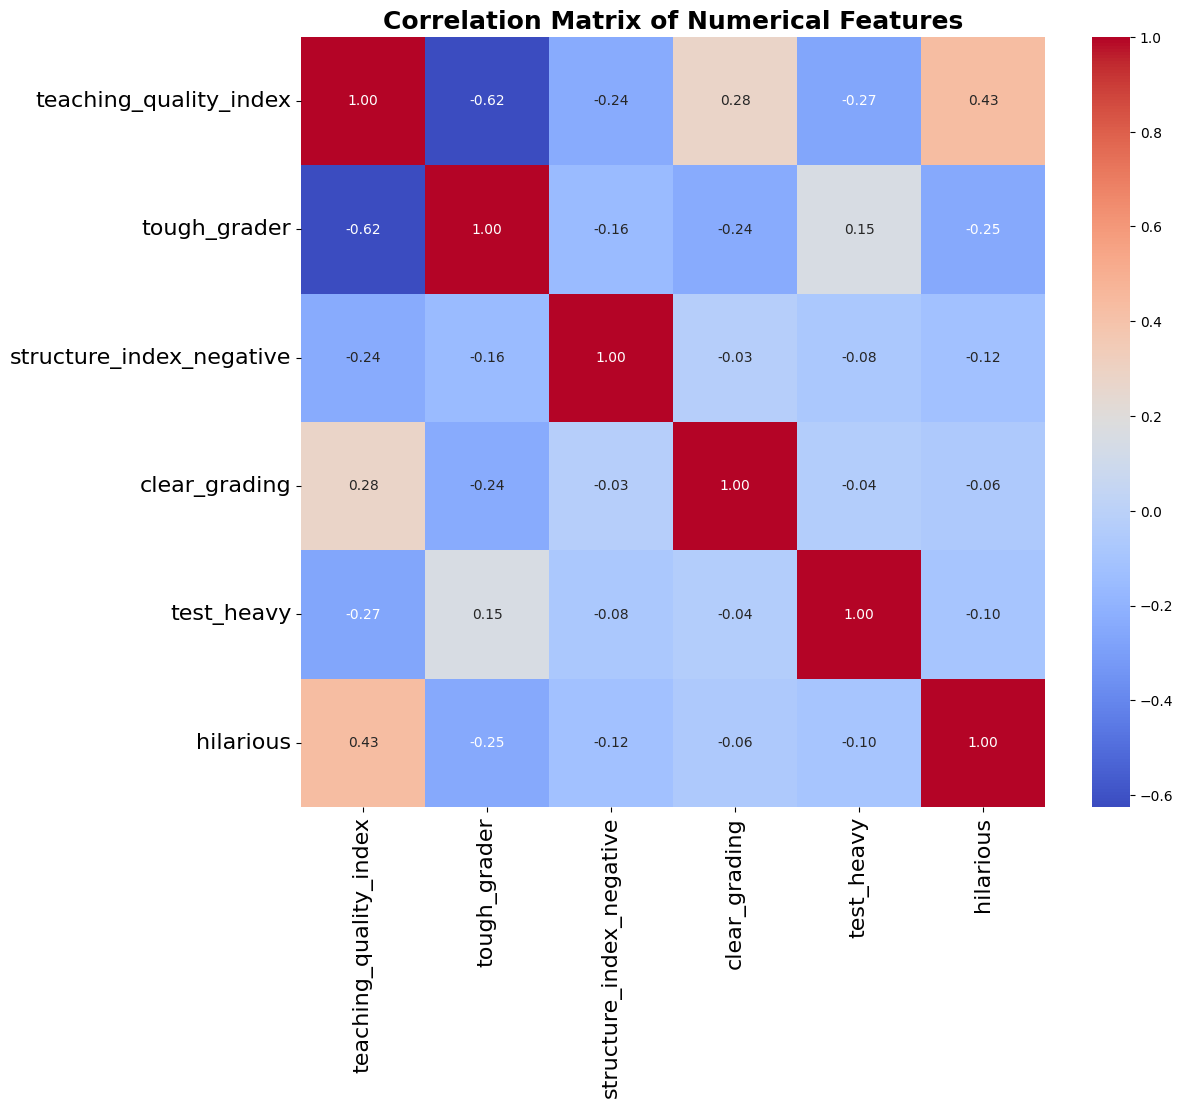

In [115]:
# reduce the data to feature with >= |0.05| weight
selected = weights_df_9.loc[weights_df_9["weight"].abs() >= 0.05, "tag"].tolist()
x_train_features_contrast_reduced_9 = x_train_9[selected]
x_test_features_contrast_reduced_9 = x_test_9[selected]

# corelations 
corr_features = x_train_features_contrast_reduced_9.corr()

# check correlation for multicollinearity 
# plot  #height, width 
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()

In [119]:
# cv 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline
pipeline_q9_features_contrast_reduced = Pipeline([
        # scaler
        ("scaler", StandardScaler()),
        # model
        ("model", LassoCV(
            cv=cv,
            random_state=n_number,
            alphas = 100,
            max_iter=10000
        ))
    ])

# cross_validation
cv_q9_raw_features_contrast_reduced = cross_validate(
        pipeline_q9_features_contrast_reduced,
        x_train_features_contrast_reduced_9,
        y_train_9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

# append to the results 
rows.append({
    "model": f"LassoCV with {len(x_train_features_contrast_reduced_9.columns)} features (with contrast index)",
    "n_features": len(x_train_features_contrast_reduced_9.columns),
        "R2_mean": cv_q9_raw_features_contrast_reduced["test_r2"].mean(),
        "RMSE_mean": -cv_q9_raw_features_contrast_reduced["test_neg_root_mean_squared_error"].mean()
    })

# create and show dataframe 
compare_models_q9_df = ( 
pd.DataFrame(rows)
.reset_index(drop = True)
.sort_values(by = "RMSE_mean") )

# check the data 
compare_models_q9_df

model   R2_mean  RMSE_mean  \
5                 ElaticNetCV, engineered features  0.551908   0.539831   
10                     ElaticNetCV, contrast index  0.551828   0.539879   
0                                 LinearRegression  0.550526   0.540656   
3                                     ElasticNetCV  0.550509   0.540673   
2                                          LassoCV  0.550499   0.540679   
1                                          RidgeCV  0.550294   0.540797   
8             Lasso CV, top 11 engineered features  0.549574   0.541232   
7             Lasso CV, top 10 engineered features  0.548376   0.541954   
9             Lasso CV, top 10 engineered features  0.548376   0.541954   
11  LassoCV with 10 features (with contrast index)  0.548376   0.541954   
4                        LassoCV with 13 variables  0.547207   0.542652   
6              Lasso CV, top 7 engineered features  0.540719   0.546530   
12   LassoCV with 6 features (with contrast index)  0.538834   0.547654   
13   LassoCV with 6 features (with contrast index)  0.538834   0.547654   

    threshold  n_features  
5         NaN         NaN  
10        NaN        31.0  
0         NaN         NaN  
3         NaN         NaN  
2         NaN         NaN  
1         NaN         NaN  
8        0.05        11.0  
7        0.05        10.0  
9        0.05        10.0  
11        NaN        10.0  
4         NaN         NaN  
6        0.05         7.0  
12        NaN         6.0  
13        NaN         6.0

In [120]:
# LassoCV with interactions on test data 
print("LassoCV with top 10 engineered feature (without contrast index):\n")
score_model(pipeline_q9_features_reduced,
            x_train_features_reduced_9, 
            x_test_features_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 10 engineered feature (without contrast index):



{'Training RMSE': 0.5415048679700165,
 'Training R2': 0.5492410632817086,
 'Testing RMSE': 0.5428844328284201,
 'Testing R2': 0.5446298582380449}

In [122]:
# LassoCV with interactions on test data 
print("LassoCV with top 8 engineered feature (with contrast index):\n")
score_model(pipeline_q9_features_contrast_reduced,
            x_train_features_contrast_reduced_9,
            x_test_features_contrast_reduced_9, 
            y_train_9, 
            y_test_9)

LassoCV with top 8 engineered feature (with contrast index):



{'Training RMSE': 0.547488800940716,
 'Training R2': 0.5392237399813895,
 'Testing RMSE': 0.5478969592552909,
 'Testing R2': 0.5361820476101787}

In [114]:
# model
model = pipeline_q9_features_contrast_reduced.named_steps["model"]

# extract feature names and coefficients
feature_names = x_train_features_contrast_reduced_9.columns
coef = model.coef_


# create the dataframe
weights_df_9 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort 
weights_df_9["abs_weight"] = weights_df_9["weight"].abs()

weights_df_9 = (
    weights_df_9
    .sort_values("abs_weight", ascending=False)
    .drop(columns="abs_weight")
    .reset_index(drop=True)
)

# check results
weights_df_9


tag    weight
0    teaching_quality_index -0.279760
1              tough_grader  0.277121
2  structure_index_negative -0.156389
3             clear_grading -0.073998
4                test_heavy  0.059618
5                 hilarious -0.059065
6                    caring -0.048480
7             lecture_heavy -0.047471
8                accessible  0.045848
9              extra_credit -0.033432

### Extra: Prediction Accuracy Optimization

#### LightGBM

In [400]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM
lgbm_pipe_q9 = Pipeline([
    # scaler
    ("scaler", StandardScaler()), 

    # model 
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__subsample_freq": trial.suggest_int("model__subsample_freq", 0, 10),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone parameters and model pipeline
    pipe = clone(lgbm_pipe_q9)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_9,
        y_train_9,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study 
study_lgbm = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)




[I 2026-01-30 03:26:36,911] A new study created in memory with name: no-name-131f3af8-25bd-4968-b9ac-c0060a8989ce
[I 2026-01-30 03:26:39,467] Trial 0 finished with value: 0.5272157017703166 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 819, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__subsample_freq': 1, 'model__colsample_bytree': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.008346099527215496, 'model__min_split_gain': 0.10123579979867697}. Best is trial 0 with value: 0.5272157017703166.
[I 2026-01-30 03:26:45,351] Trial 1 finished with value: 0.5346654829257663 and parameters: {'model__num_leaves': 168, 'model__max_depth': 16, 'model__min_child_samples': 61, 'model__n_estimators': 2642, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model__subsample_freq': 6, 'model__colsample_bytree': 0

Best Params: {'model__num_leaves': 52, 'model__max_depth': 10, 'model__min_child_samples': 56, 'model__n_estimators': 978, 'model__learning_rate': 0.008370665351089454, 'model__subsample': 0.7975065553660592, 'model__subsample_freq': 1, 'model__colsample_bytree': 0.7499719092970705, 'model__reg_alpha': 2.676603222263086, 'model__reg_lambda': 4.142361968494326e-06, 'model__min_split_gain': 0.4833502871123979}


In [401]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe_q9.set_params(**study_lgbm.best_params)

cv_results_raw_lgbm_q9 = cross_validate(
    lgbm_pipe_q9,
    x_train_9,
    y_train_9,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
rows.append({
    "model": "Tuned LightGBM",
    "R2_mean": cv_results_raw_lgbm_q9["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_lgbm_q9["test_neg_root_mean_squared_error"]).mean()
})

# show as dataframe 
cv_results_raw_lgbm_q9 = (
    pd.DataFrame(rows)
    .reset_index(drop = True)
    .sort_values(by = "RMSE_mean"))

# check 
cv_results_raw_lgbm_q9

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


model   R2_mean  RMSE_mean  threshold  \
9                       Tuned LightGBM  0.572987   0.526985        NaN   
5     ElaticNetCV, engineered features  0.552407   0.539528        NaN   
8          ElaticNetCV, contrast index  0.552298   0.539594        NaN   
0                     LinearRegression  0.550526   0.540656        NaN   
3                         ElasticNetCV  0.550509   0.540673        NaN   
2                              LassoCV  0.550499   0.540679        NaN   
1                              RidgeCV  0.550294   0.540797        NaN   
4            LassoCV with 13 variables  0.547207   0.542652        NaN   
7  Lasso CV, top 8 engineered features  0.544333   0.544373       0.05   
6  Lasso CV, top 7 engineered features  0.540719   0.546530       0.05   

   n_features  
9         NaN  
5         NaN  
8        31.0  
0         NaN  
3         NaN  
2         NaN  
1         NaN  
4         NaN  
7         8.0  
6         7.0

In [402]:
# evaluate our baseline model 
# against lgbm model 
print("LightGBM model performance:\n")
score_model(
    lgbm_pipe_q9,
    x_train_9,
    x_test_9,
    y_train_9,
    y_test_9
)

LightGBM model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.4818041266978364,
 'Training R2': 0.6431541533361866,
 'Testing RMSE': 0.5291769238690138,
 'Testing R2': 0.5673351953395291}

In [405]:
# evaluate our LassoCV with top 7 engineered features on test data 
# against lgbm model 
print("LassoCV top 8 engineered features on test data:\n")
score_model(
    pipeline_q9_features_reduced,
    x_train_features_reduced_9,
    x_test_features_reduced_9,
    y_train_9,
    y_test_9
)

LassoCV top 8 engineered features on test data:



{'Training RMSE': 0.5440703210072791,
 'Training R2': 0.5449598822428894,
 'Testing RMSE': 0.545937110212645,
 'Testing R2': 0.5394943031963303}

C:\Users\nyuss\AppData\Local\Temp\ipykernel_31296\4268088527.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_9)


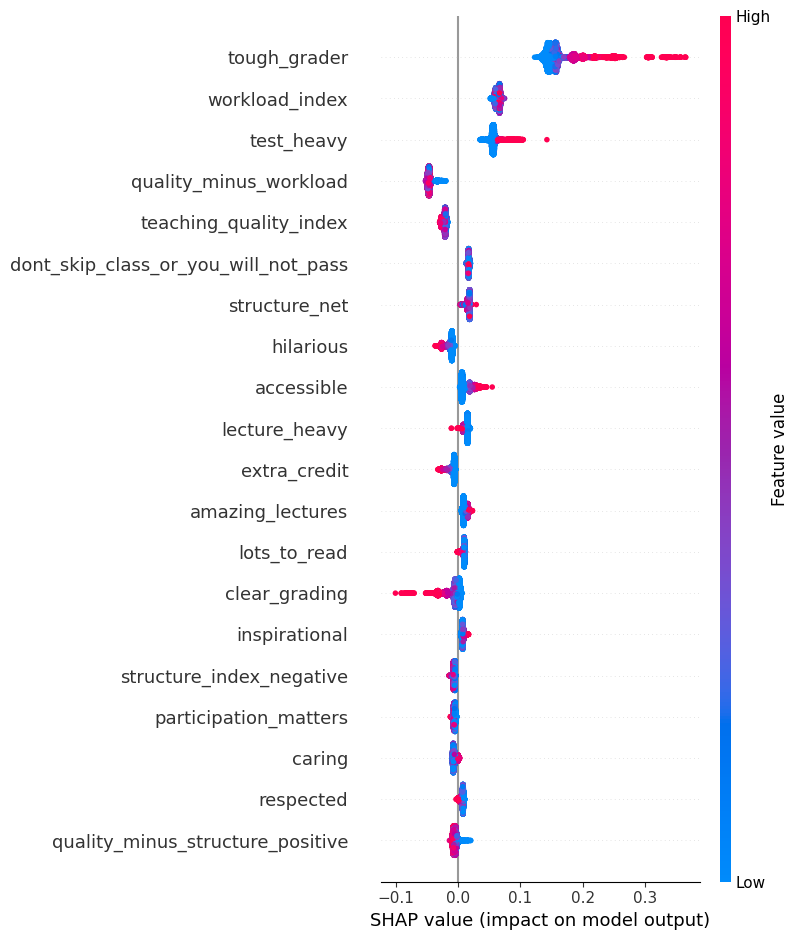

In [406]:
# shapley values
explainer = shap.TreeExplainer(lgbm_pipe_q9.named_steps["model"])
shap_values = explainer.shap_values(x_train_9)   

# plot 
shap.summary_plot(shap_values, x_train_9)

#### XGBoost 

In [408]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe_q9 = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model
    ("model", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=n_number,
        n_jobs=1,
        verbosity=0
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1e-2, 50.0, log=True),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 0.5),

        # extra capacity control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    # clone parameters and model pipeline
    pipe = clone(xgb_pipe_q8)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_9,
        y_train_9,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study
study_xgb = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)


[I 2026-01-30 03:30:51,094] A new study created in memory with name: no-name-6443c5dc-0848-4a5c-b243-1c3944c9e878
[I 2026-01-30 03:30:54,375] Trial 0 finished with value: 0.5281752307506262 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 0.17689663027883612, 'model__n_estimators': 1709, 'model__learning_rate': 0.010162654352368208, 'model__subsample': 0.7434522575663386, 'model__colsample_bytree': 0.7445336836373633, 'model__reg_alpha': 8.280449747344628e-08, 'model__reg_lambda': 5.3874727250769205e-06, 'model__gamma': 0.3776671724026525, 'model__max_delta_step': 7}. Best is trial 0 with value: 0.5281752307506262.
[I 2026-01-30 03:30:59,256] Trial 1 finished with value: 0.5339716384504881 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 2.2755784987429224, 'model__n_estimators': 2888, 'model__learning_rate': 0.014357845660171998, 'model__subsample': 0.9468649720171275, 'model__colsample_bytree': 0.6806109309369683, 'model__reg_alpha': 4.420931990594

Best Params: {'model__max_depth': 4, 'model__min_child_weight': 1.3641184465634653, 'model__n_estimators': 1179, 'model__learning_rate': 0.007903950867114682, 'model__subsample': 0.6096183226360965, 'model__colsample_bytree': 0.8845409721893605, 'model__reg_alpha': 0.0005340640505197606, 'model__reg_lambda': 1.5069017138961898e-07, 'model__gamma': 0.38709063656546183, 'model__max_delta_step': 2}


In [410]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
xgb_pipe_q9.set_params(**study_xgb.best_params)

cv_results_raw_xgb_q9 = cross_validate(
    xgb_pipe_q9,
    x_train_9,
    y_train_9,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
rows.append({
    "model": "Tuned XGBoost",
    "R2_mean": cv_results_raw_xgb_q9["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_xgb_q9["test_neg_root_mean_squared_error"]).mean()
})

# check as dataframe 
compare_models_q9_df = pd.DataFrame(rows).reset_index(drop = True).sort_values(by = "RMSE_mean")
compare_models_q9_df

model   R2_mean  RMSE_mean  threshold  \
9                        Tuned LightGBM  0.572987   0.526985        NaN   
10                        Tuned XGBoost  0.572806   0.527089        NaN   
5      ElaticNetCV, engineered features  0.552407   0.539528        NaN   
8           ElaticNetCV, contrast index  0.552298   0.539594        NaN   
0                      LinearRegression  0.550526   0.540656        NaN   
3                          ElasticNetCV  0.550509   0.540673        NaN   
2                               LassoCV  0.550499   0.540679        NaN   
1                               RidgeCV  0.550294   0.540797        NaN   
4             LassoCV with 13 variables  0.547207   0.542652        NaN   
7   Lasso CV, top 8 engineered features  0.544333   0.544373       0.05   
6   Lasso CV, top 7 engineered features  0.540719   0.546530       0.05   

    n_features  
9          NaN  
10         NaN  
5          NaN  
8         31.0  
0          NaN  
3          NaN  
2          NaN  
1          NaN  
4          NaN  
7          8.0  
6          7.0

## Q10. Build a classification model that predicts whether a professor receives a “pepper” from all available factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalance concerns.

In [22]:
# first, make a subset of all variables that are needed. 
df_10 = df_filtered_final.copy()

# check 
df_10.info()

<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  str    
 9   university                            18422 non-null  str    
 10  state                                 18422 non-null  str    
 11  tough_grader                   

In [23]:
# drop female_gender as it is redundant 
# drop major, university, and state 
df_10 = df_10.drop(columns = ['female_gender', 
                            'major', 
                            'university', 
                            'state'])
# check 
df_10.info()

<class 'pandas.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   tough_grader                          18422 non-null  float64
 8   good_feedback                         18422 non-null  float64
 9   respected                             18422 non-null  float64
 10  lots_to_read                          18422 non-null  float64
 11  participation_matters          

We drop female_gender because gender is already fully captured by the male_gender indicator. Including both would introduce perfect redundancy without adding information.

We also remove major, university, and state. These variables are high-cardinality identifiers and do not have a clear behavioral relationship with whether a professor receives a pepper. The pepper reflects student perception of teaching style and engagement, which is already directly captured by the tag variables and numerical ratings. Once these behavioral signals are included, institutional or geographic identifiers are unlikely to add meaningful, generalizable information.

From a modeling perspective, keeping major, university, or state would substantially increase dimensionality and the risk of overfitting while primarily capturing dataset-specific patterns rather than transferable structure. Since the goal is to build a behavior-driven classification model that generalizes beyond specific institutions, these identifiers are excluded.

In [25]:
# split the data to x and y 
x_10 = df_10.drop(columns = "received_a_pepper")
y_10 = df_10["received_a_pepper"]

# split between train and test data 
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_10, y_10, test_size=0.2, random_state=n_number)

# correlations between y and x predictors 
corr_yx_10 = x_train_10.corrwith(y_train_10)

# check 
corr_yx_10.sort_values(ascending=False)

average_rating                          0.454502
would_take_again                        0.428006
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things                   -0.113841
test_heavy                             -0.134382
lots_to_read        

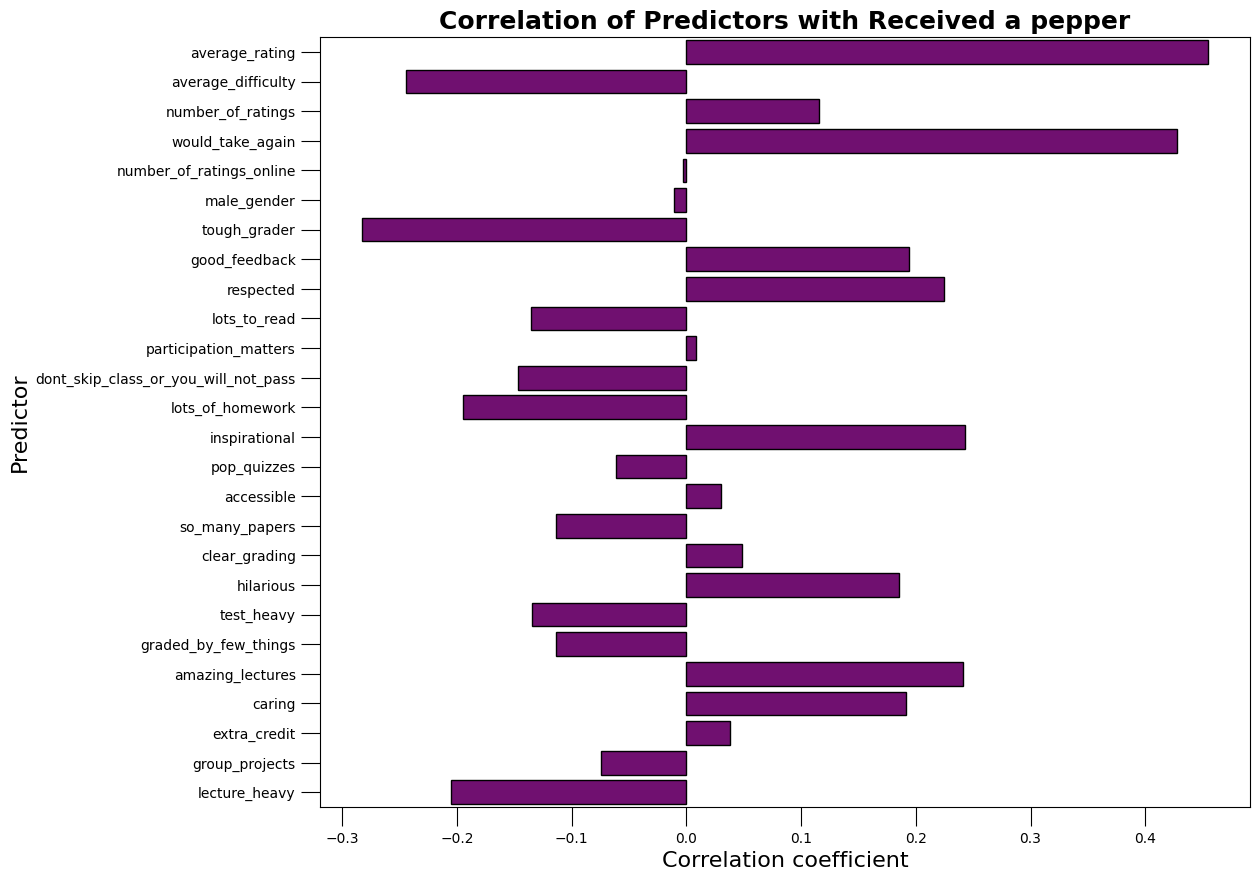

In [26]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx_10, 
            orient= 'h', 
            color = 'purple', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Received a pepper", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

The correlation analysis provides a clear first look at which factors are associated with receiving a pepper. The strongest positive relationships are driven by overall student sentiment. Average rating shows the highest correlation at about 0.45, followed closely by would take again at about 0.43. This is expected. Peppers are primarily awarded to professors students genuinely like.

Teaching quality tags also matter. Inspirational, amazing lectures, respected, good feedback, caring, and hilarious all show moderate positive correlations in the 0.18-0.25 range. These variables capture engagement, clarity, and emotional connection, which aligns well with the informal nature of the pepper signal.

Course popularity plays a smaller role. Number of ratings is positively correlated at around 0.11, suggesting that more visible professors are slightly more likely to receive a pepper, but exposure alone is not a dominant factor.

On the negative side, difficulty and workload clearly work against receiving a pepper. Tough grader shows the strongest negative correlation at about -0.28. Average difficulty, lecture heavy, lots of homework, lots to read, and test heavy all fall between roughly -0.13 and -0.24. This indicates that stricter and heavier courses reduce the likelihood of a pepper, even if teaching quality is strong.

Administrative or structural factors have little impact. Male gender, number of online ratings, participation matters, accessible, and extra credit all sit close to zero, suggesting minimal direct association with receiving a pepper.

In [27]:
# correlation matrix among tags
corr_xx = x_train_10.corr()

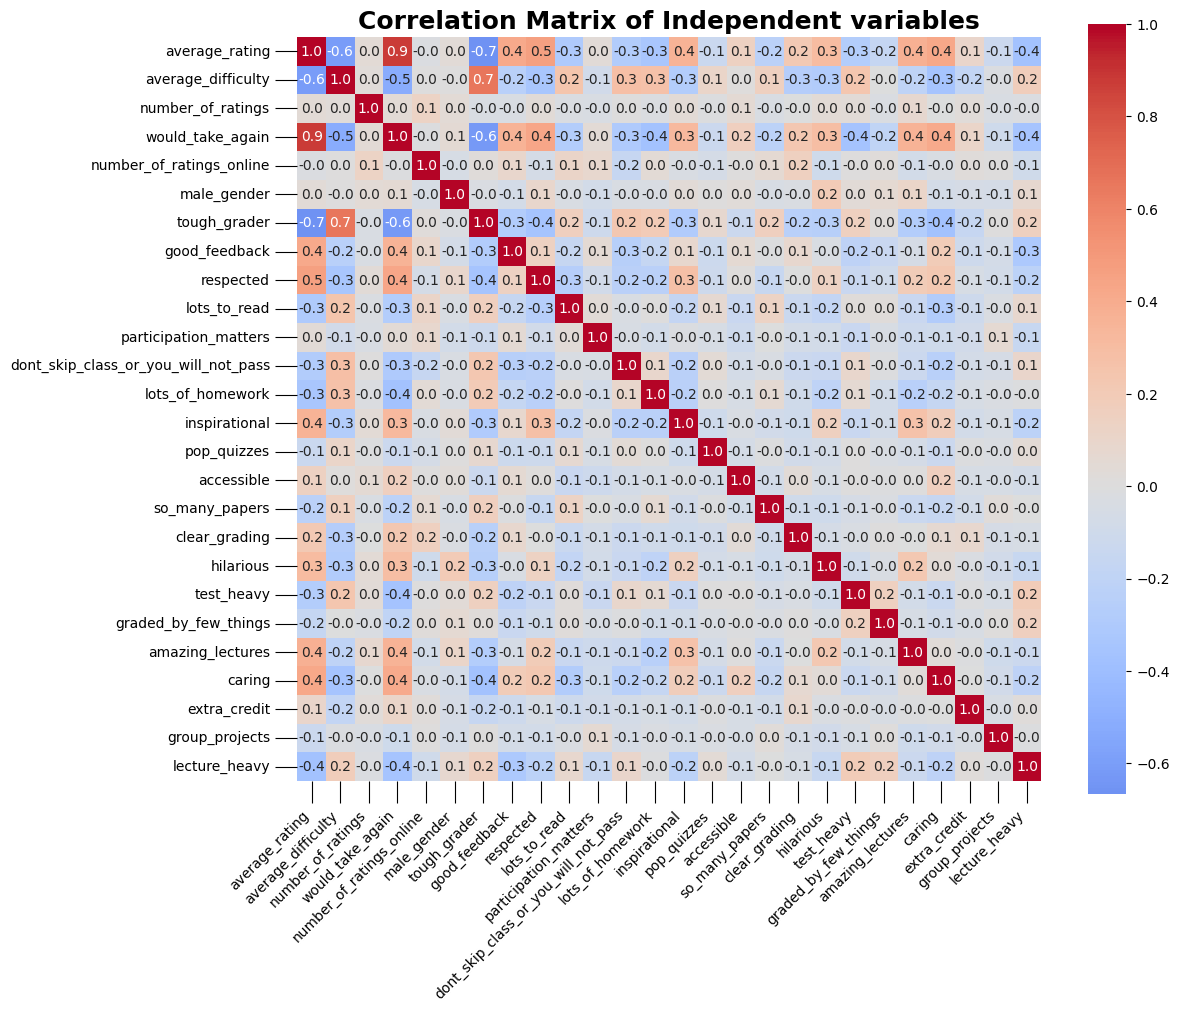

In [28]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Independent variables", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

The correlation matrix shows clear multicollinearity among several predictors, with absolute correlations reaching and exceeding 0.7.
Examples include strong relationships between `average rating`, `would take again`, and multiple teaching quality tags, as well as between difficulty-related variables.

This level of correlation violates the independence assumption required for stable coefficient estimation in standard logistic regression and makes coefficient interpretation unreliable.

Since we want to implement both feature selection and coefficient interpretability, `Elastic Net` is the appropriate choice at this stage.

Elastic Net is preferred because:
- L1 regularization promotes sparsity and feature selection
- L2 regularization stabilizes coefficient estimates under multicollinearity

Using Elastic Net during feature selection allows us to reduce redundancy while maintaining stable, interpretable coefficients, which would not be achievable with pure Lasso under strong multicollinearity.

In [29]:
# check distributions of the data 
print(f'Number of rows for train data:{y_train_10.shape[0]}\n')
print(f'Number of rows for test data:{y_test_10.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [30]:
# check classes in train data
y_train_10.value_counts()

received_a_pepper
0.0    8504
1.0    6233
Name: count, dtype: int64

Both classes are reasonably well represented. The training set contains 8,504 observations without a pepper and 6,233 with a pepper, which corresponds to roughly a 58-42 split. This is not a severe imbalance, so extreme remedies such as aggressive resampling are unnecessary. However, the classes are still not perfectly balanced, so evaluation will rely on threshold-independent metrics such as ROC-AUC rather than accuracy.

Given this setup, we proceed without class resampling and instead focus on model specification and preprocessing choices. As a first step, we tune KNN imputation within a regular logistic regression framework to fill null values in `would_take_again` feature. This allows us to assess whether a more sophisticated imputation strategy meaningfully improves predictive performance compared to simpler alternatives such as mean or median imputation. Once the best imputation approach is identified, we will carry it forward to the regularized logistic models.

### Logistic Regression

#### KNN Imputation 

In [31]:
# fixed cross-validation (classification needs stratification)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)
# pipeline for tuning 
knn_pipe_q10 = Pipeline([
    # imputer 
    ("imputer", KNNImputer()),

    # model 
    ("model", LogisticRegression(
        max_iter=10000,
        solver="lbfgs"
    ))
])

# define objective function for optuna
def objective(trial):
    # parameters to tune (numeric imputer only)
    params = {
        "imputer__n_neighbors": trial.suggest_int("imputer__n_neighbors", 2, 25),
        "imputer__weights": trial.suggest_categorical("imputer__weights", ["uniform", "distance"]),
        "imputer__add_indicator": False
    }

    # clone our model and set parameters
    pipe = clone(knn_pipe_q10)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters (classification metric)
    scores = cross_val_score(
        pipe,
        x_train_10,
        y_train_10,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    # maximize ROC-AUC
    return scores.mean()

# start the study for knn imputer tuning
study_knn_q10 = start_study_optuna(
    objective=objective,
    n_trials=15,
    sampler_seed=n_number,
    direction="maximize"
)

# set the best parameters to the pipeline
knn_pipe_q10.set_params(**study_knn_q10.best_params)

# assess 
score_classifier(
    knn_pipe_q10,
    x_train_10,
    x_test_10,
    y_train_10,
    y_test_10
)

[I 2026-01-31 19:51:39,004] A new study created in memory with name: no-name-a5280674-0b30-4bcb-b99b-9023ef2b0ce8
[I 2026-01-31 19:51:53,136] Trial 0 finished with value: 0.7906964176107395 and parameters: {'imputer__n_neighbors': 8, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7906964176107395.
[I 2026-01-31 19:52:05,433] Trial 1 finished with value: 0.7906678253058544 and parameters: {'imputer__n_neighbors': 6, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7906964176107395.
[I 2026-01-31 19:52:16,106] Trial 2 finished with value: 0.7905426231514964 and parameters: {'imputer__n_neighbors': 4, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7906964176107395.
[I 2026-01-31 19:52:24,192] Trial 3 finished with value: 0.7906737124820128 and parameters: {'imputer__n_neighbors': 17, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7906964176107395.
[I 2026-01-31 19:52:31,152] Trial 4 finished with value: 0.7907132381936137 and p

Best Params: {'imputer__n_neighbors': 22, 'imputer__weights': 'uniform'}


{'Training ROC-AUC': 0.7922284078356346,
 'Testing ROC-AUC': 0.7929053151468327,
 'Training Accuracy': 0.7173780280925561,
 'Testing Accuracy': 0.7180461329715061,
 'Training Precision': 0.6597157862218103,
 'Testing Precision': 0.6626287098728043,
 'Training Recall': 0.6852238087598267,
 'Testing Recall': 0.6941624365482234,
 'Testing Specificity': 0.7358937885253675,
 'Training F1': 0.6722279058786496,
 'Testing F1': 0.6780291292221878,
 'Confusion Matrix (test)': [[1552, 557], [482, 1094]]}

The tuned logistic regression with KNN imputation performs well and generalizes cleanly. ROC-AUC is about 0.793 on both training and test data, indicating strong discriminative ability with no signs of overfitting. The near-identical train and test AUC confirms stable generalization. The use of Stratified K-Fold cross-validation ensures that class proportions are preserved across folds, so these results are not driven by sampling artifacts.

Overall accuracy is roughly 0.72, which is reasonable given the subjective and noisy nature of pepper assignments. Test precision is about 0.66, meaning roughly two thirds of professors predicted to receive a pepper actually do. Test recall is about 0.69, so the model identifies close to 70 percent of true pepper cases. Specificity is about 0.74, indicating slightly better performance at identifying non-pepper cases. The F1 score of approximately 0.68 reflects a balanced tradeoff between precision and recall.

The confusion matrix confirms this balance. Errors are distributed across both classes, and there is no evidence that the model systematically favors one class over the other. Class imbalance is therefore not a limiting factor in this setting, and no reweighting or resampling is required at this stage.

With this strong and stable baseline in place, the next step is to compare different imputation strategies. We will evaluate whether simpler imputers, such as mean or median imputation, perform comparably to the tuned KNN imputer, or whether the added complexity of KNN imputation provides a measurable advantage in classification performance.

In [32]:
# fixed cross-validation (classification needs stratification)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for comparison
pipelines_q10 = {
    "KNNImputer (tuned)": Pipeline([
        # imputer
        ("imputer", KNNImputer(
            n_neighbors=22,
            weights="uniform",
            add_indicator=False
        )),

        # scaler
        ("scaler", StandardScaler()),

        # model
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),

    "SimpleImputer (mean)": Pipeline([
        ("imputer", SimpleImputer(
            strategy="mean",
            add_indicator=False
        )),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),

    "SimpleImputer (median)": Pipeline([
        ("imputer", SimpleImputer(
            strategy="median",
            add_indicator=False
        )),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),
}

# compare the pipelines
rows = []
for name, pipe in pipelines_q10.items():
    results = cross_validate(
        pipe,
        x_train_10,
        y_train_10,
        cv=cv,
        scoring={
            "roc_auc": "roc_auc",
            "accuracy": "accuracy",
            "precision": "precision",
            "recall": "recall",
            "f1": "f1"
        },
        return_train_score=False,
        n_jobs=-1
    )

    rows.append({
        "model": name,
        "ROC_AUC_mean": results["test_roc_auc"].mean(),
        "Accuracy_mean": results["test_accuracy"].mean(),
        "Precision_mean": results["test_precision"].mean(),
        "Recall_mean": results["test_recall"].mean(),
        "F1_mean": results["test_f1"].mean()
    })

# create a dataframe for comparison
compare_imputers_df_q10 = (
    pd.DataFrame(rows)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check the results
compare_imputers_df_q10

model  ROC_AUC_mean  Accuracy_mean  Precision_mean  \
0    SimpleImputer (mean)      0.791396       0.718259        0.663622   
1  SimpleImputer (median)      0.791193       0.716766        0.661483   
2      KNNImputer (tuned)      0.790726       0.716630        0.659716   

   Recall_mean   F1_mean  
0     0.677520  0.670429  
1     0.677039  0.669092  
2     0.682012  0.670605

All three imputers produce nearly identical performance across all metrics.
`ROC AUC` differences are below 0.001 and precision, recall, and F1 are effectively the same.

Since KNN and median imputation are more computationally expensive and do not provide any measurable performance benefit, mean imputation is the most reasonable choice.

Mean imputation is:
- Simpler
- Faster
- Deterministic
- Easier to maintain in production

Because there is no accuracy or ranking advantage from more complex imputers, using mean imputation improves operational simplicity without sacrificing model performance.

#### Logistic Regression tuning

In [ ]:
# cv 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for logistic models
pipelines_q10_logistic = Pipeline([
    # imputer 
    ("imputer", SimpleImputer(strategy="mean")),

    # scaler
    ("scaler", StandardScaler()),

    # model itself
    ("model", LogisticRegressionCV(
        cv=5,
        l1_ratios=[0.1, 0.5, 0.9],
        Cs = np.logspace(-3, 2, 6),
        penalty='elasticnet',  
        solver='saga',
        scoring='roc_auc',
        max_iter=10000,
        random_state=n_number,
        n_jobs= 1
    ))
])


# cross-validation
results_logistic = cross_validate(
    pipelines_q10_logistic,
    x_train_10,
    y_train_10,
    cv=cv,
    scoring=['roc_auc', 
             'accuracy', 
             'precision', 
             'recall', 
             'f1'],
    n_jobs=-1,  
    return_train_score=False
)

# copy rows with results 
models_comparison = rows.copy()

models_comparison.append({
        "model": "Logistic Regression with ElasticNet penalty",
        "ROC_AUC_mean": results_logistic["test_roc_auc"].mean(),
        "Accuracy_mean": results_logistic["test_accuracy"].mean(),
        "Precision_mean": results_logistic["test_precision"].mean(),
        "Recall_mean": results_logistic["test_recall"].mean(),
        "F1_mean": results_logistic["test_f1"].mean()
    })

# save to the dataset 
compare_models_q10_logistic_df = (
    pd.DataFrame(models_comparison)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check 
compare_models_q10_logistic_df

model  ROC_AUC_mean  Accuracy_mean  \
0                         SimpleImputer (mean)      0.791396       0.718259   
1  Logistic Regression with ElasticNet penalty      0.791362       0.717445   
2                       SimpleImputer (median)      0.791193       0.716766   
3                           KNNImputer (tuned)      0.790726       0.716630   

   Precision_mean  Recall_mean   F1_mean  
0        0.663622     0.677520  0.670429  
1        0.662610     0.676879  0.669584  
2        0.661483     0.677039  0.669092  
3        0.659716     0.682012  0.670605

After introducing L1 and L2 penalties through Elastic Net, we observe a marginal decrease across all evaluation metrics. This behavior is expected, as regularization deliberately introduces bias in exchange for reduced variance, improved generalization, and better handling of multicollinearity.

Despite the slight metric drop, cross-validation results remain stable, indicating that the model is not overfitting and that performance differences are within noise.

While the regularized model performs comparably to the unregularized baseline, fitting `Elastic Net` with the full set of predictors is computationally more expensive and adds unnecessary complexity. Since the goal includes interpretability and deployment robustness, retaining all variables is not justified.

As a result, after looking at test data sample performance, we proceed by pruning predictors based on standardized Elastic Net coefficients, retaining only features with meaningful contribution to the decision boundary.

In [35]:
# assess on test data
print("Elastic-Net Logistic Regression performance on test data:")
score_classifier(
    pipelines_q10_logistic,
    x_train_10,
    x_test_10,
    y_train_10,
    y_test_10)

Elastic-Net Logistic Regression performance on test data:


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7929286756874276,
 'Testing ROC-AUC': 0.7936042173618983,
 'Training Accuracy': 0.7177851665875008,
 'Testing Accuracy': 0.7142469470827679,
 'Training Precision': 0.6627432517263026,
 'Testing Precision': 0.660923076923077,
 'Training Recall': 0.6775228621851436,
 'Testing Recall': 0.6814720812182741,
 'Testing Specificity': 0.7387387387387387,
 'Training F1': 0.6700515668385562,
 'Testing F1': 0.6710402999062793,
 'Confusion Matrix (test)': [[1558, 551], [502, 1074]]}

Held-out test performance closely matches cross-validation results, indicating strong generalization and model stability.

In [39]:
# extract weights from the fitted model
logistic_model = pipelines_q10_logistic.named_steps["model"]

# feature names after preprocessing
feature_names = pipelines_q10_logistic.named_steps["imputer"].get_feature_names_out(
    x_train_10.columns
)

# coefficients (binary classification -> 1D)
coef = logistic_model.coef_.ravel()

# build dataframe of weights
weights_df_q10_elastic = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q10_elastic["abs_weight"] = weights_df_q10_elastic["weight"].abs()
weights_df_q10_elastic = (
    weights_df_q10_elastic
      .sort_values("abs_weight", ascending=False)
      .reset_index(drop=True)
)

# check
weights_df_q10_elastic

feature    weight  abs_weight
0                         average_rating  1.132680    1.132680
1                      number_of_ratings  0.294358    0.294358
2                     average_difficulty  0.155249    0.155249
3                       would_take_again  0.152930    0.152930
4                          inspirational  0.134273    0.134273
5                       lots_of_homework -0.105150    0.105150
6                            male_gender -0.104707    0.104707
7                       amazing_lectures  0.103856    0.103856
8                              hilarious  0.093016    0.093016
9                   graded_by_few_things -0.084481    0.084481
10                            accessible -0.083320    0.083320
11                         lecture_heavy -0.067950    0.067950
12                         good_feedback  0.048992    0.048992
13                        so_many_papers -0.048133    0.048133
14                         clear_grading -0.041613    0.041613
15                          tough_grader  0.037485    0.037485
16                          extra_credit  0.030289    0.030289
17  dont_skip_class_or_you_will_not_pass -0.025080    0.025080
18                        group_projects -0.023699    0.023699
19                            test_heavy -0.018613    0.018613
20                          lots_to_read  0.015175    0.015175
21                             respected -0.012723    0.012723
22                           pop_quizzes  0.009297    0.009297
23              number_of_ratings_online -0.007831    0.007831
24                                caring  0.004384    0.004384
25                 participation_matters  0.000000    0.000000

The standardized Elastic Net coefficients do not exhibit a clear elbow or sharp cutoff point. Instead, weights decay gradually, indicating that several predictors contribute weakly and may be redundant under multicollinearity.

Given the absence of a natural breakpoint, we adopt a pragmatic threshold of |weight| < 0.05 as an initial pruning criterion. Coefficients below this level are small relative to the dominant predictors and likely contribute marginal signal.

This threshold is not treated as a hard rule, but as a starting point.

In [41]:
# cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
elasticnetcv_q10_comparisons = []

# filter-out variables 
keep_features = weights_df_q10_elastic[
    weights_df_q10_elastic["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["feature"].tolist()

# create train and test samples 
x_train_reduced_10 = x_train_10[keep_features]
x_test_reduced_10 = x_test_10[keep_features]

# loop to drop each variable 1 by one 
for k in range(len(keep_features), 0, -1):
    keep_pool = keep_features[:k]

    x_train_reduced_10 = x_train_10[keep_pool]

    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            cv=5,
            l1_ratios=[0.1, 0.5, 0.9],
            Cs=np.logspace(-3, 2, 6),
            penalty="elasticnet",
            solver="saga",
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number,
            n_jobs=1
        ))
    ])


    results_reduced_10 = cross_validate(
        pipeline,
        x_train_reduced_10,
        y_train_10,
        cv=cv,
        scoring=["roc_auc", "accuracy", "precision", "recall", "f1"],
        n_jobs=-1,
        return_train_score=False
    )

    elasticnetcv_q10_comparisons.append({
        "model": f"ElasticNetCV | top-{k} by |w|",
        "ROC_AUC_mean": results_reduced_10["test_roc_auc"].mean(),
        "Accuracy_mean": results_reduced_10["test_accuracy"].mean(),
        "Precision_mean": results_reduced_10["test_precision"].mean(),
        "Recall_mean": results_reduced_10["test_recall"].mean(),
        "F1_mean": results_reduced_10["test_f1"].mean(),
        "num_features": k
    })

# dataframe 
drop1_df = (pd.DataFrame(elasticnetcv_q10_comparisons)
            .sort_values("ROC_AUC_mean", ascending=False)
            .reset_index(drop=True))
drop1_df


model  ROC_AUC_mean  Accuracy_mean  Precision_mean  \
0   ElasticNetCV | top-12 by |w|      0.791208       0.716630        0.661173   
1   ElasticNetCV | top-11 by |w|      0.790913       0.716970        0.661381   
2   ElasticNetCV | top-10 by |w|      0.790109       0.715070        0.658942   
3    ElasticNetCV | top-9 by |w|      0.789397       0.713645        0.656786   
4    ElasticNetCV | top-8 by |w|      0.788687       0.713645        0.655986   
5    ElasticNetCV | top-7 by |w|      0.787593       0.714798        0.656713   
6    ElasticNetCV | top-6 by |w|      0.787021       0.714866        0.656328   
7    ElasticNetCV | top-5 by |w|      0.786294       0.713645        0.654812   
8    ElasticNetCV | top-4 by |w|      0.783363       0.709641        0.647631   
9    ElasticNetCV | top-3 by |w|      0.782151       0.711202        0.648085   
10   ElasticNetCV | top-2 by |w|      0.780727       0.710727        0.647659   
11   ElasticNetCV | top-1 by |w|      0.770842       0.701634        0.655217   

    Recall_mean   F1_mean  num_features  
0      0.677199  0.669022            12  
1      0.678162  0.669610            11  
2      0.676879  0.667729            10  
3      0.676881  0.666613             9  
4      0.679929  0.667625             8  
5      0.683457  0.669699             7  
6      0.685061  0.670277             6  
7      0.684580  0.669200             5  
8      0.688910  0.667482             4  
9      0.695167  0.670685             3  
10     0.693884  0.669895             2  
11     0.622329  0.638233             1

As features are progressively removed based on `standardized Elastic Net weights`, model performance degrades smoothly rather than abruptly. This indicates that weaker predictors contribute marginal signal but are partially redundant.

The `6-feature model` represents the best trade-off between performance and parsimony:
- ROC AUC remains high at ~0.787
- F1 score is near its maximum
- Recall slightly improves relative to larger models
- Accuracy remains stable
- Model complexity is reduced by ~70%

Below 6 features, performance begins to degrade more noticeably, particularly in `ROC AUC` and stability. Above 6 features, additional predictors provide diminishing returns while increasing model complexity and multicollinearity risk.

We therefore select the top 6 features by absolute standardized Elastic Net weight as the final feature set.

This choice preserves predictive performance while improving interpretability, robustness, and deployment simplicity.

In [42]:
# keep features of 6-variable model 
keep_features = weights_df_q10_elastic.head(6)["feature"].tolist()

# reduce data
x_train_10_reduced_final = x_train_10[keep_features]
x_test_10_reduced_final = x_test_10[keep_features]




In [43]:
# reduced pipeline
pipelines_q10_logistic_reduced = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegressionCV(
        cv=5,
        l1_ratios=[0.1, 0.5, 0.9],
        Cs=np.logspace(-3, 2, 6),
        penalty="elasticnet",
        solver="saga",
        scoring="roc_auc",
        max_iter=10000,
        random_state=n_number,
        n_jobs=1
    ))
])

# cross-validation 
results_reduced = cross_validate(
    pipelines_q10_logistic_reduced,
    x_train_10_reduced_final,
    y_train_10,
    cv=cv,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    n_jobs=-1,
    return_train_score=False
)

# appends results to our dictionary 
models_comparison.append({
    "model": f"ElasticNetCV | top-{len(x_train_10_reduced_final.columns)} features by |w|",
    "ROC_AUC_mean": results_reduced["test_roc_auc"].mean(),
    "Accuracy_mean": results_reduced["test_accuracy"].mean(),
    "Precision_mean": results_reduced["test_precision"].mean(),
    "Recall_mean": results_reduced["test_recall"].mean(),
    "F1_mean": results_reduced["test_f1"].mean()
})

# check 
compare_models_q10_logistic_df = (
    pd.DataFrame(models_comparison)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)
compare_models_q10_logistic_df 

model  ROC_AUC_mean  Accuracy_mean  \
0                         SimpleImputer (mean)      0.791396       0.718259   
1  Logistic Regression with ElasticNet penalty      0.791362       0.717445   
2                       SimpleImputer (median)      0.791193       0.716766   
3                           KNNImputer (tuned)      0.790726       0.716630   
4         ElasticNetCV | top-6 features by |w|      0.787021       0.714866   

   Precision_mean  Recall_mean   F1_mean  
0        0.663622     0.677520  0.670429  
1        0.662610     0.676879  0.669584  
2        0.661483     0.677039  0.669092  
3        0.659716     0.682012  0.670605  
4        0.656328     0.685061  0.670277

Reducing the feature set from the full model to the top 6 Elastic Net - selected predictors resulted in only a marginal decrease in ROC AUC (~0.004), while precision, recall, and F1 remained stable, indicating that the pruned model retains most of the predictive signal.

In [46]:
# assess 6 variable model on test data
print("ElasticNet CV with 6 features:\n")
score_classifier(
    pipelines_q10_logistic_reduced,
    x_train_10_reduced_final,
    x_test_10_reduced_final,
    y_train_10,
    y_test_10)

ElasticNet CV with 6 features:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7871524752406508,
 'Testing ROC-AUC': 0.7856665776115416,
 'Training Accuracy': 0.7152744792020086,
 'Testing Accuracy': 0.7115332428765264,
 'Training Precision': 0.6566200215285253,
 'Testing Precision': 0.654425045153522,
 'Training Recall': 0.6850633723728542,
 'Testing Recall': 0.6897208121827412,
 'Testing Specificity': 0.7278330962541489,
 'Training F1': 0.6705402010050251,
 'Testing F1': 0.6716095149830089,
 'Confusion Matrix (test)': [[1535, 574], [489, 1087]]}

In [45]:
# assess all variables model on test data
print("ElasticNet CV with all features:\n")
score_classifier(
    pipelines_q10_logistic,
    x_train_10,
    x_test_10,
    y_train_10,
    y_test_10)

ElasticNet CV with all features:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7929286756874276,
 'Testing ROC-AUC': 0.7936042173618983,
 'Training Accuracy': 0.7177851665875008,
 'Testing Accuracy': 0.7142469470827679,
 'Training Precision': 0.6627432517263026,
 'Testing Precision': 0.660923076923077,
 'Training Recall': 0.6775228621851436,
 'Testing Recall': 0.6814720812182741,
 'Testing Specificity': 0.7387387387387387,
 'Training F1': 0.6700515668385562,
 'Testing F1': 0.6710402999062793,
 'Confusion Matrix (test)': [[1558, 551], [502, 1074]]}

The 6 - feature `Elastic Net` model shows only a modest reduction in ROC AUC compared to the full model (≈ 0.006 - 0.008), while maintaining nearly identical F1 score and slightly improving recall on the test set.

Key observations:
- ROC AUC drops from ~0.794 to ~0.786. This is small and expected after aggressive feature pruning.
- Recall increases from ~0.68 to ~0.69, aligning better with a recall-oriented objective.
- Precision decreases slightly, consistent with the recall gain.
- F1 score remains effectively unchanged.
- Specificity decreases modestly, reflecting the same trade-off.

Overall, predictive behavior remains stable and consistent between train and test, indicating no overfitting and good generalization.
The reduced model uses only 6 predictors and achieves significantly faster inference and lower computational overhead compared to the full feature set. This makes the pruned model more suitable for deployment, especially in settings where latency or scalability matters.


- Given the minimal performance loss, stable generalization, and substantial gains in simplicity and speed, the 6 - feature Elastic Net model represents the better deployment choice.

<Figure size 1200x1000 with 0 Axes>

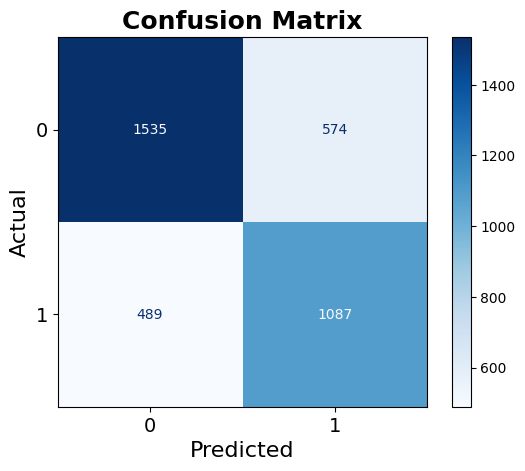

In [47]:
# confusion matrix 
# predict 
y_test_10_pred = pipelines_q10_logistic_reduced.predict(x_test_10_reduced_final)
y_test_prob_10 = pipelines_q10_logistic_reduced.predict_proba(x_test_10_reduced_final)[:, 1]

cm = confusion_matrix(y_test_10, y_test_10_pred)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

The confusion matrix shows balanced and stable behavior on the held-out test set. The model correctly identifies a large portion of positive cases, with 1,087 true positives, while missing 489 positives, resulting in recall of approximately 0.69. This confirms that the model is operating in a recall-oriented regime.

On the negative class, the model correctly classifies 1,535 instances, while producing 574 false positives, yielding a specificity of about 0.73. This level of false positives is expected given the emphasis on recall.

Overall, the distribution of errors is consistent with cross-validation results and indicates no pathological behavior or overfitting. These results are obtained using the default classification threshold, without any additional threshold tuning.

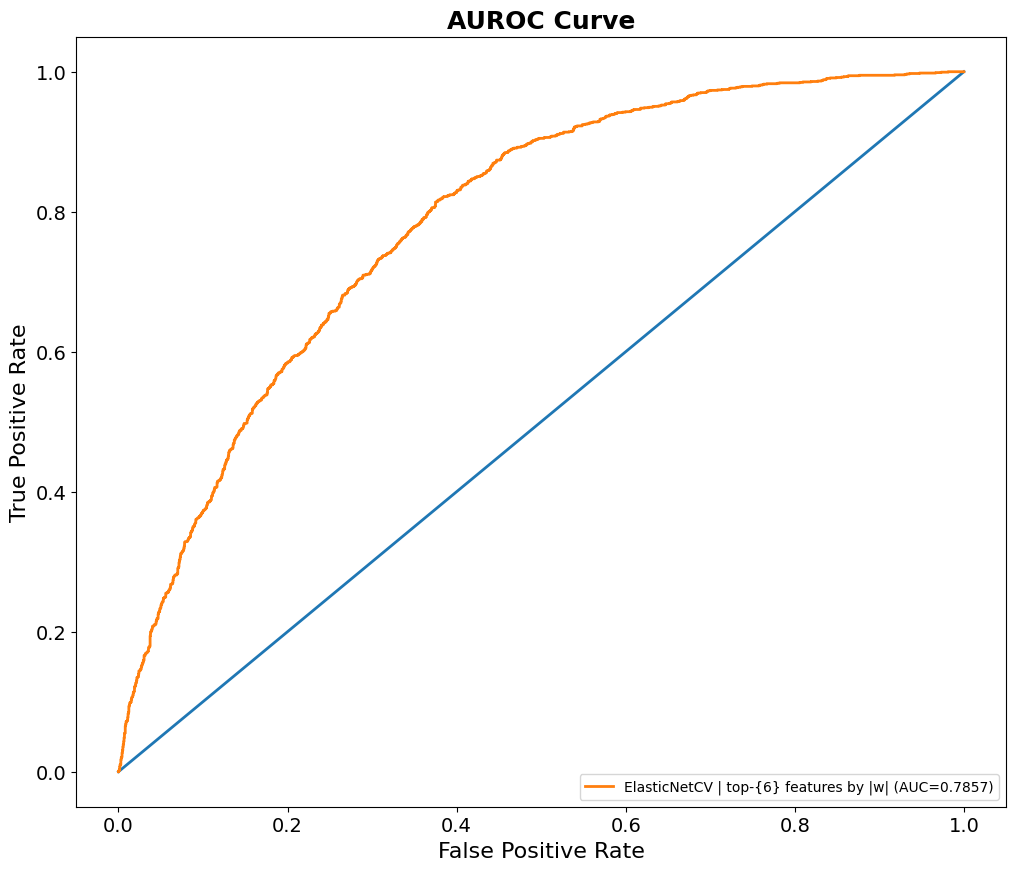

In [49]:
# create the figure once
fig, ax = plt.subplots(figsize=(12, 10))

# diagonal baseline once
ax.plot([0, 1], [0, 1], linewidth=2)

# add models using our function 
add_roc(ax, y_test_10, y_test_prob_10, "ElasticNetCV | top-{6} features by |w|")

# aesthetics 
# title
ax.set_title("AUROC Curve", fontsize=18, fontweight="bold")

# xlabel
ax.set_xlabel("False Positive Rate", fontsize=16)
# ylabel
ax.set_ylabel("True Positive Rate", fontsize=16)

# tick_params
ax.tick_params(labelsize=14)

# legend
ax.legend(frameon=True, loc="lower right")

# show the plot
plt.show()


In [51]:
# predicted probabilities on train set
y_train_prob_10 = pipelines_q10_logistic_reduced.predict_proba(x_train_10_reduced_final)[:, 1]

# thresholds
thresholds = np.linspace(0.01, 0.99, 50)
rows_thresholds = []

# loop over many thresholds
for t in thresholds:
    y_pred = (y_train_prob_10 >= t).astype(int)
    rows_thresholds.append({
        "threshold": t,
        "AUC": roc_auc_score(y_train_10, y_pred),
        "recall": recall_score(y_train_10, y_pred),
        "precision": precision_score(y_train_10, y_pred),
        "f1": f1_score(y_train_10, y_pred)
    })

# check 
probability_threshold_10_reduced = pd.DataFrame(rows_thresholds)
probability_threshold_10_reduced


threshold       AUC    recall  precision        f1
0        0.01  0.500470  1.000000   0.423179  0.594695
1        0.03  0.528232  0.999198   0.437206  0.608263
2        0.05  0.556000  0.997112   0.452263  0.622278
3        0.07  0.576395  0.993101   0.464157  0.632633
4        0.09  0.594770  0.985400   0.475755  0.641697
5        0.11  0.611285  0.979625   0.486767  0.650370
6        0.13  0.625389  0.973849   0.496767  0.657923
7        0.15  0.638209  0.965506   0.506651  0.664568
8        0.17  0.648844  0.956201   0.515571  0.669926
9        0.19  0.658099  0.948019   0.523755  0.674736
10       0.21  0.669674  0.938713   0.534436  0.681101
11       0.23  0.677994  0.929248   0.542983  0.685444
12       0.25  0.685864  0.916413   0.552204  0.689148
13       0.27  0.691061  0.901171   0.559964  0.690728
14       0.29  0.695505  0.890422   0.566500  0.692452
15       0.31  0.699371  0.875341   0.573772  0.693177
16       0.33  0.704915  0.861383   0.583017  0.695376
17       0.35  0.708279  0.845179   0.591047  0.695629
18       0.37  0.711556  0.828333   0.599721  0.695728
19       0.39  0.713385  0.811648   0.607177  0.694679
20       0.41  0.715604  0.793037   0.616334  0.693608
21       0.43  0.714993  0.768651   0.624560  0.689154
22       0.45  0.713555  0.745548   0.631815  0.683986
23       0.47  0.712988  0.723247   0.640705  0.679478
24       0.49  0.711431  0.696615   0.650975  0.673022
25       0.51  0.710147  0.671587   0.662028  0.666773
26       0.53  0.703804  0.639499   0.669016  0.653925
27       0.55  0.697012  0.604043   0.678256  0.639002
28       0.57  0.689754  0.565538   0.690229  0.621693
29       0.59  0.680512  0.521418   0.704378  0.599244
30       0.61  0.670110  0.478742   0.716963  0.574122
31       0.63  0.655049  0.426279   0.728944  0.537963
32       0.65  0.640177  0.374779   0.744186  0.498506
33       0.67  0.624620  0.325205   0.758324  0.455199
34       0.69  0.608219  0.273704   0.777930  0.404937
35       0.71  0.589134  0.222365   0.787053  0.346760
36       0.73  0.572788  0.177443   0.803195  0.290670
37       0.75  0.558688  0.138777   0.826170  0.237637
38       0.77  0.542498  0.100754   0.824147  0.179557
39       0.79  0.532357  0.074122   0.852399  0.136384
40       0.81  0.524709  0.054709   0.883420  0.103037
41       0.83  0.518248  0.039788   0.898551  0.076202
42       0.85  0.512039  0.026312   0.896175  0.051122
43       0.87  0.508584  0.018931   0.887218  0.037072
44       0.89  0.506749  0.014439   0.918367  0.028432
45       0.91  0.505022  0.010749   0.917808  0.021250
46       0.93  0.503535  0.007541   0.921569  0.014959
47       0.95  0.502348  0.004813   0.967742  0.009579
48       0.97  0.501626  0.003369   0.954545  0.006715
49       0.99  0.500583  0.001283   0.888889  0.002563

The table shows the expected precision - recall trade-off as the classification threshold increases. Lower thresholds capture nearly all positives but generate many false positives, while higher thresholds sharply reduce recall in exchange for higher precision.

Since we think that the better objective is to identify as many professors who receive a pepper as possible, recall is the primary metric. Precision is secondary, as false positives are less costly than missed positives in this setting.

At a threshold of 0.27:
- Recall is ~0.90
- Precision is ~0.56
- F1 score is near its maximum
- Performance degradation relative to neighboring thresholds is minimal

Beyond this point, recall drops more rapidly without providing a proportional gain in precision or overall model quality. Below this point, recall gains are marginal while precision deteriorates noticeably.

We therefore select 0.27 as the operating threshold. This threshold maximizes recall while maintaining reasonable precision and overall balance, and aligns with the goal of identifying as many qualifying professors as possible without introducing excessive noise.

This choice reflects an explicit, cost-aware decision rather than arbitrary thresholding.

In [52]:
# apply chosen threshold
threshold = 0.27
y_test_10_prob_threshold = pipelines_q10_logistic_reduced.predict_proba(x_test_10_reduced_final)[:, 1]
y_test_10_pred_threshold = (y_test_10_prob_threshold >= threshold).astype(int)

<Figure size 1200x1000 with 0 Axes>

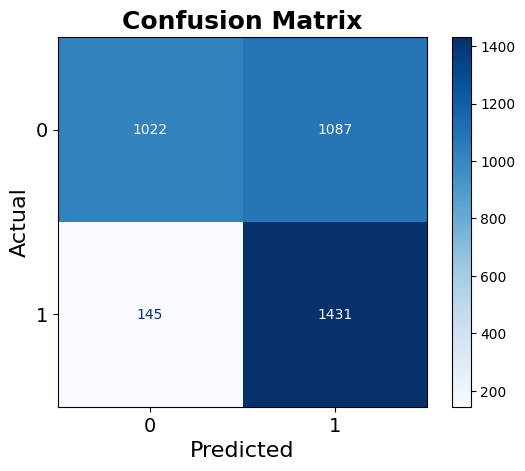

In [55]:
# confusion matrix 
cm = confusion_matrix(y_test_10, y_test_10_pred_threshold)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

At the selected threshold of 0.27, the model strongly prioritizes recall. The number of true positives increases substantially to 1,431, while false negatives drop to 145, confirming that most professors who receive a pepper are correctly identified.

This improvement in recall comes at the cost of additional false positives, with 1,087 negative cases incorrectly flagged as positive. As a result, specificity decreases, which is expected given the recall-first objective.

Overall, this behavior is consistent with the threshold analysis. The model successfully shifts toward identifying as many positive cases as possible, aligning with the stated goal, without introducing instability or unexpected error patterns.

Next step

With the operating point fixed, we now examine the six retained predictors to understand which variables drive the model’s decisions and how they contribute to identifying professors who receive a pepper.

In [56]:
# extract weights from the fitted model
logistic_model_final = pipelines_q10_logistic_reduced.named_steps["model"]

# feature names after preprocessing
feature_names = pipelines_q10_logistic_reduced.named_steps["imputer"].get_feature_names_out(
    x_train_10_reduced_final.columns
)

# coefficients (binary classification -> 1D)
coef = logistic_model_final.coef_.ravel()

# build dataframe of weights
weights_df_q10_elastic_final = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q10_elastic_final["abs_weight"] = weights_df_q10_elastic_final["weight"].abs()
weights_df_q10_elastic_final = (
    weights_df_q10_elastic_final
      .sort_values("abs_weight", ascending=False)
      .reset_index(drop=True)
)

# check
weights_df_q10_elastic_final

feature    weight  abs_weight
0      average_rating  1.228122    1.228122
1   number_of_ratings  0.291174    0.291174
2       inspirational  0.166203    0.166203
3  average_difficulty  0.159798    0.159798
4    would_take_again  0.147619    0.147619
5    lots_of_homework -0.109657    0.109657

Final model features and interpretation: 

After feature selection and threshold tuning, the final model retains six predictors. All coefficients are standardized, so magnitudes are directly comparable.

- average_rating
This is the strongest predictor by a wide margin. Higher average ratings substantially increase the likelihood of receiving a pepper, indicating that overall student satisfaction is the dominant signal.

- number_of_ratings
A positive coefficient suggests that professors with more ratings are more likely to receive a pepper. This likely reflects visibility and confidence in the estimate rather than pure quality.

- inspirational
Professors described as inspirational are more likely to receive a pepper, capturing a qualitative teaching attribute beyond raw difficulty or grading.

- average_difficulty
Higher difficulty surprisingly slightly increases the probability of receiving a pepper. This suggests that challenge, when paired with quality, is not penalized and may even be valued.

- would_take_again
A positive effect indicates that students' willingness to retake a professor strongly aligns with receiving a pepper, reinforcing this variable as a proxy for overall teaching approval.

- lots_of_homework
This is the only negative coefficient. Professors perceived as assigning excessive homework are less likely to receive a pepper, even after controlling for overall rating and difficulty.

The final model captures a coherent narrative: peppers are associated with highly rated, inspiring professors who are challenging but not overwhelming, widely reviewed, and perceived as worth retaking. The retained features are interpretable, stable, and align with intuitive expectations.

This confirms that aggressive pruning preserved the core signal while removing redundant noise.

### Extra: Feature Engineering 

In [57]:
# look at train_data
x_train_10.info()

<class 'pandas.DataFrame'>
Index: 14737 entries, 69507 to 16707
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        14737 non-null  float64
 1   average_difficulty                    14737 non-null  float64
 2   number_of_ratings                     14737 non-null  float64
 3   would_take_again                      7040 non-null   float64
 4   number_of_ratings_online              14737 non-null  float64
 5   male_gender                           14737 non-null  int64  
 6   tough_grader                          14737 non-null  float64
 7   good_feedback                         14737 non-null  float64
 8   respected                             14737 non-null  float64
 9   lots_to_read                          14737 non-null  float64
 10  participation_matters                 14737 non-null  float64
 11  dont_skip_class_or_you_will

In [58]:
# look at correlations again 
x_train_10.corrwith(y_train_10).sort_values(ascending= False)
# check

average_rating                          0.454502
would_take_again                        0.428006
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things                   -0.113841
test_heavy                             -0.134382
lots_to_read        

#### Polynomials

In [60]:
# polynomials 
# copy x_train and x_test for safety 
x_train_10_pol = x_train_10.copy()
x_test_10_pol = x_test_10.copy()

# average rating
x_train_10_pol["average_rating^2"] = np.square(x_train_10_pol["average_rating"])
x_test_10_pol["average_rating^2"] = np.square(x_test_10_pol["average_rating"])

# average difficulty 
x_train_10_pol["average_difficulty^2"] = np.square(x_train_10_pol["average_difficulty"])
x_test_10_pol["average_difficulty^2"] = np.square(x_test_10_pol["average_difficulty"])

In [61]:
# look at correlations again 
x_train_10_pol.corrwith(y_train_10).sort_values(ascending= False)
# check

average_rating^2                        0.465520
average_rating                          0.454502
would_take_again                        0.428006
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things                   -0.113841
test_heavy          

In [62]:
# let's try to drop redundant average_rating now 
# average rating 
x_train_10_pol.drop("average_rating", 
                    axis = 1, 
                    inplace = True)

x_test_10_pol.drop("average_rating", 
                    axis = 1, 
                    inplace = True)

# average difficulty 
x_train_10_pol.drop("average_difficulty", 
                    axis = 1, 
                    inplace = True)

x_test_10_pol.drop("average_difficulty", 
                    axis = 1, 
                    inplace = True)

In [98]:
# cv 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for logistic models
pipelines_q10_logistic_pol = Pipeline([
    # imputer 
    ("imputer", SimpleImputer(strategy="mean")),

    # scaler
    ("scaler", StandardScaler()),

    # model itself
    ("model", LogisticRegressionCV(
        cv=5,
        l1_ratios=[0.1, 0.5, 0.9],
        Cs = np.logspace(-3, 2, 6),
        penalty='elasticnet',  
        solver='saga',
        scoring='roc_auc',
        max_iter=10000,
        random_state=n_number,
        n_jobs= 1
    ))
])


# cross-validation
results_features_pol = cross_validate(
    pipelines_q10_logistic_pol,
    x_train_10_pol,
    y_train_10,
    cv=cv,
    scoring=['roc_auc', 
             'accuracy', 
             'precision', 
             'recall', 
             'f1'],
    n_jobs=-1,  
    return_train_score=False
)


models_comparison.append({
        "model": "Logistic Regression with ElasticNet penalty (polynomial features)",
        "ROC_AUC_mean": results_features_pol["test_roc_auc"].mean(),
        "Accuracy_mean": results_features_pol["test_accuracy"].mean(),
        "Precision_mean": results_features_pol["test_precision"].mean(),
        "Recall_mean": results_features_pol["test_recall"].mean(),
        "F1_mean": results_features_pol["test_f1"].mean()
    })

# save to the dataset 
compare_models_q10_features_polynomials = (
    pd.DataFrame(models_comparison)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check 
compare_models_q10_features_polynomials

model  ROC_AUC_mean  \
0                               SimpleImputer (mean)      0.791396   
1        Logistic Regression with ElasticNet penalty      0.791362   
2                             SimpleImputer (median)      0.791193   
3                                 KNNImputer (tuned)      0.790726   
4  Logistic Regression with ElasticNet penalty (p...      0.789777   
5               ElasticNetCV | top-6 features by |w|      0.787021   

   Accuracy_mean  Precision_mean  Recall_mean   F1_mean  
0       0.718259        0.663622     0.677520  0.670429  
1       0.717445        0.662610     0.676879  0.669584  
2       0.716766        0.661483     0.677039  0.669092  
3       0.716630        0.659716     0.682012  0.670605  
4       0.717852        0.666495     0.666932  0.666653  
5       0.714866        0.656328     0.685061  0.670277

In [64]:
# assess polynomials on test data
score_classifier(
    pipelines_q10_logistic_pol,
    x_train_10_pol,
    x_test_10_pol,
    y_train_10,
    y_test_10)

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7914455258095057,
 'Testing ROC-AUC': 0.7918709519030117,
 'Training Accuracy': 0.7175815973400285,
 'Testing Accuracy': 0.7123473541383989,
 'Training Precision': 0.6661852030171722,
 'Testing Precision': 0.6624685138539043,
 'Training Recall': 0.6659714423231189,
 'Testing Recall': 0.6675126903553299,
 'Testing Specificity': 0.7458511142721669,
 'Training F1': 0.6660783055198973,
 'Testing F1': 0.6649810366624526,
 'Confusion Matrix (test)': [[1573, 536], [524, 1052]]}

In [65]:
# extract weights from the fitted model
logistic_model_pol = pipelines_q10_logistic_pol.named_steps["model"]

# feature names after preprocessing
feature_names = pipelines_q10_logistic_pol.named_steps["imputer"].get_feature_names_out(
    x_train_10_pol.columns
)

# coefficients (binary classification -> 1D)
coef = logistic_model_pol.coef_.ravel()

# build dataframe of weights
weights_df_q10_elastic_pol = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q10_elastic_pol["abs_weight"] = weights_df_q10_elastic_pol["weight"].abs()
weights_df_q10_elastic_pol = (
    weights_df_q10_elastic_pol
      .sort_values("abs_weight", ascending=False)
      .reset_index(drop=True)
)

# check
weights_df_q10_elastic_pol

feature    weight  abs_weight
0                       average_rating^2  1.009651    1.009651
1                           tough_grader  0.390263    0.390263
2                          good_feedback  0.379263    0.379263
3                              hilarious  0.361248    0.361248
4                          inspirational  0.343790    0.343790
5                       amazing_lectures  0.333566    0.333566
6                           lots_to_read  0.317105    0.317105
7                      number_of_ratings  0.304480    0.304480
8                                 caring  0.289821    0.289821
9                  participation_matters  0.276657    0.276657
10                          extra_credit  0.272852    0.272852
11  dont_skip_class_or_you_will_not_pass  0.255111    0.255111
12                             respected  0.238201    0.238201
13                         clear_grading  0.195893    0.195893
14                      lots_of_homework  0.188858    0.188858
15                         lecture_heavy  0.173315    0.173315
16                      would_take_again  0.162915    0.162915
17                           pop_quizzes  0.161408    0.161408
18                        group_projects  0.155310    0.155310
19                  average_difficulty^2  0.126590    0.126590
20                            test_heavy  0.104556    0.104556
21                           male_gender -0.103845    0.103845
22                            accessible  0.083057    0.083057
23                        so_many_papers  0.070936    0.070936
24                  graded_by_few_things  0.033168    0.033168
25              number_of_ratings_online -0.012356    0.012356

In [67]:
# cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
elasticnetcv_q10_comparisons_pol = []

# filter-out variables 
keep_features_pol = weights_df_q10_elastic_pol[
    weights_df_q10_elastic_pol["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["feature"].tolist()

# create train and test samples 
x_train_reduced_10_pol = x_train_10_pol[keep_features_pol]
x_test_reduced_10_pol = x_test_10_pol[keep_features_pol]

# loop to drop each variable 1 by one 
for k in range(len(keep_features_pol), 0, -1):
    keep_pool_pol = keep_features_pol[:k]

    x_train_reduced_10_pol = x_train_10_pol[keep_pool_pol]

    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            cv=5,
            l1_ratios=[0.1, 0.5, 0.9],
            Cs=np.logspace(-3, 2, 6),
            penalty="elasticnet",
            solver="saga",
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number,
            n_jobs=1
        ))
    ])


    results_reduced_10_pol = cross_validate(
        pipeline,
        x_train_reduced_10_pol,
        y_train_10,
        cv=cv,
        scoring=["roc_auc", "accuracy", "precision", "recall", "f1"],
        n_jobs=-1,
        return_train_score=False
    )

    elasticnetcv_q10_comparisons_pol.append({
        "model": f"ElasticNetCV | top-{k} by |w|",
        "ROC_AUC_mean": results_reduced_10_pol["test_roc_auc"].mean(),
        "Accuracy_mean": results_reduced_10_pol["test_accuracy"].mean(),
        "Precision_mean": results_reduced_10_pol["test_precision"].mean(),
        "Recall_mean": results_reduced_10_pol["test_recall"].mean(),
        "F1_mean": results_reduced_10_pol["test_f1"].mean(),
        "num_features": k
    })

# dataframe 
drop2_df = (pd.DataFrame(elasticnetcv_q10_comparisons_pol)
            .sort_values("ROC_AUC_mean", ascending=False)
            .reset_index(drop=True))
drop2_df


model  ROC_AUC_mean  Accuracy_mean  Precision_mean  \
0   ElasticNetCV | top-22 by |w|      0.790031       0.717987        0.666508   
1   ElasticNetCV | top-23 by |w|      0.789900       0.717716        0.666308   
2   ElasticNetCV | top-24 by |w|      0.789898       0.718123        0.667023   
3   ElasticNetCV | top-21 by |w|      0.789219       0.716698        0.665278   
4   ElasticNetCV | top-20 by |w|      0.789185       0.716902        0.665282   
5   ElasticNetCV | top-19 by |w|      0.788554       0.715884        0.664157   
6   ElasticNetCV | top-18 by |w|      0.788435       0.715206        0.663482   
7   ElasticNetCV | top-17 by |w|      0.788141       0.715138        0.663278   
8   ElasticNetCV | top-13 by |w|      0.787082       0.716020        0.663420   
9   ElasticNetCV | top-12 by |w|      0.786962       0.716223        0.663387   
10  ElasticNetCV | top-14 by |w|      0.786935       0.715816        0.663138   
11  ElasticNetCV | top-15 by |w|      0.786904       0.715341        0.662534   
12  ElasticNetCV | top-16 by |w|      0.786820       0.715138        0.662312   
13  ElasticNetCV | top-11 by |w|      0.786687       0.715409        0.663163   
14  ElasticNetCV | top-10 by |w|      0.786060       0.714052        0.661932   
15   ElasticNetCV | top-9 by |w|      0.786040       0.714527        0.662341   
16   ElasticNetCV | top-8 by |w|      0.785962       0.715341        0.662992   
17   ElasticNetCV | top-7 by |w|      0.779360       0.710727        0.658091   
18   ElasticNetCV | top-6 by |w|      0.779124       0.709574        0.657171   
19   ElasticNetCV | top-5 by |w|      0.776846       0.709574        0.655619   
20   ElasticNetCV | top-4 by |w|      0.772707       0.704417        0.647678   
21   ElasticNetCV | top-2 by |w|      0.771933       0.706588        0.651089   
22   ElasticNetCV | top-3 by |w|      0.771842       0.706520        0.651001   
23   ElasticNetCV | top-1 by |w|      0.770842       0.701634        0.655217   

    Recall_mean   F1_mean  num_features  
0      0.667414  0.666907            22  
1      0.666772  0.666483            23  
2      0.666611  0.666760            24  
3      0.665006  0.665072            21  
4      0.665969  0.665551            20  
5      0.664525  0.664266            19  
6      0.663402  0.663358            18  
7      0.663884  0.663464            17  
8      0.667574  0.665401            13  
9      0.668697  0.665925            12  
10     0.667574  0.665248            14  
11     0.667093  0.664713            15  
12     0.666771  0.664430            16  
13     0.665649  0.664302            11  
14     0.662761  0.662241            10  
15     0.663724  0.662946             9  
16     0.665649  0.664237             8  
17     0.658751  0.658329             7  
18     0.655864  0.656412             6  
19     0.660997  0.658181             5  
20     0.661317  0.654323             4  
21     0.660994  0.655784             2  
22     0.660834  0.655662             3  
23     0.622329  0.638233             1

In [83]:
# check dataframe with best models 
compare_models_q10_logistic_df

model  ROC_AUC_mean  \
0                               SimpleImputer (mean)      0.791396   
1           Logistic Regression ElasticNet (indexes)      0.791368   
2        Logistic Regression with ElasticNet penalty      0.791362   
3                             SimpleImputer (median)      0.791193   
4                                 KNNImputer (tuned)      0.790726   
5  Logistic Regression with ElasticNet penalty (p...      0.789777   
6               ElasticNetCV | top-6 features by |w|      0.787021   

   Accuracy_mean  Precision_mean  Recall_mean   F1_mean  
0       0.718259        0.663622     0.677520  0.670429  
1       0.718055        0.663516     0.676879  0.670056  
2       0.717445        0.662610     0.676879  0.669584  
3       0.716766        0.661483     0.677039  0.669092  
4       0.716630        0.659716     0.682012  0.670605  
5       0.717852        0.666495     0.666932  0.666653  
6       0.714866        0.656328     0.685061  0.670277

This experiment evaluates whether polynomial-expanded features benefit from aggressive feature pruning using Elastic Net. The results show that, even after systematically reducing the polynomial feature set, no configuration achieves a better trade-off between performance and complexity than the previously selected 6-feature linear model.

While models with a large number of polynomial features (20+ variables) achieve slightly higher ROC AUC, the improvement is marginal and does not justify the substantial increase in model complexity and computational cost. As the number of retained polynomial features decreases, performance steadily degrades, indicating that polynomial terms do not introduce new, independent signal but instead redistribute existing information.

Importantly, none of the polynomial-based models match the simplicity and stability of the 6-feature linear Elastic Net model while providing comparable or superior performance. This confirms that polynomial expansion does not add meaningful predictive value in this setting.

Polynomial feature expansion fails to improve the bias-variance trade-off and does not outperform a much simpler linear model. We therefore reject polynomial features and retain the 6-feature Elastic Net model as the final specification.

#### Index Features 

In [78]:
# copy x_train_10 and x_test_10 again for safety 
x_train_10_indexes = x_train_10.copy()
x_test_10_indexes = x_test_10.copy()

# check correlation first 
x_y_index_corr = x_train_10_indexes.corrwith(y_train_10).sort_values(ascending= False)
x_y_index_corr

average_rating                          0.454502
would_take_again                        0.428006
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things                   -0.113841
test_heavy                             -0.134382
lots_to_read        

In [79]:
# indexes
# teaching quality group
teaching_quality = [
    "good_feedback", "respected", "inspirational",
    "amazing_lectures", "caring", "tough_grader",
    "hilarious", "accessible"
]

# structure group 
structure_positive = [
    "clear_grading", 
    "extra_credit"
]

structure_negative = [
    "pop_quizzes", 
    "group_projects", 
    "graded_by_few_things"
]
# workload group
workload = [
    "lots_of_homework", 
    "dont_skip_class_or_you_will_not_pass",
    "lots_to_read", "test_heavy", "so_many_papers", 
    "lecture_heavy"
]

# train data 
x_train_10_indexes["teaching_quality_index"] = x_train_10_indexes[teaching_quality].mean(axis=1)
x_train_10_indexes["workload_index"] = x_train_10_indexes[workload].mean(axis=1)
x_train_10_indexes["structure_index_positive"] = x_train_10_indexes[structure_positive].mean(axis=1)
x_train_10_indexes["structure_index_negative"] = x_train_10_indexes[structure_negative].mean(axis=1)

# test data 
x_test_10_indexes["teaching_quality_index"] = x_test_10_indexes[teaching_quality].mean(axis=1)
x_test_10_indexes["workload_index"] = x_test_10_indexes[workload].mean(axis=1)
x_test_10_indexes["structure_index_positive"] = x_test_10_indexes[structure_positive].mean(axis=1)
x_test_10_indexes["structure_index_negative"] = x_test_10_indexes[structure_negative].mean(axis=1)

In [70]:
# check correlation first 
x_y_index_corr = x_train_10_indexes.corrwith(y_train_10).sort_values(ascending= False)
x_y_index_corr

average_rating                          0.454502
would_take_again                        0.428006
teaching_quality_index                  0.332775
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
structure_index_positive                0.058702
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things

In [71]:
# cv 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for logistic models
pipelines_q10_logistic_index = Pipeline([
    # imputer 
    ("imputer", SimpleImputer(strategy="mean")),

    # scaler
    ("scaler", StandardScaler()),

    # model itself
    ("model", LogisticRegressionCV(
        cv=5,
        l1_ratios=[0.1, 0.5, 0.9],
        Cs = np.logspace(-3, 2, 6),
        penalty='elasticnet',  
        solver='saga',
        scoring='roc_auc',
        max_iter=10000,
        random_state=n_number,
        n_jobs= 1
    ))
])


# cross-validation
results_index = cross_validate(
    pipelines_q10_logistic_index,
    x_train_10_indexes,
    y_train_10,
    cv=cv,
    scoring=['roc_auc', 
             'accuracy', 
             'precision', 
             'recall', 
             'f1'],
    n_jobs=-1,  
    return_train_score=False
)

models_comparison.append({
        "model": "Logistic Regression ElasticNet (indexes)",
        "ROC_AUC_mean": results_index["test_roc_auc"].mean(),
        "Accuracy_mean": results_index["test_accuracy"].mean(),
        "Precision_mean": results_index["test_precision"].mean(),
        "Recall_mean": results_index["test_recall"].mean(),
        "F1_mean": results_index["test_f1"].mean()
    })

# save to the dataset 
compare_models_q10_logistic_df = (
    pd.DataFrame(models_comparison)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check 
compare_models_q10_logistic_df

model  ROC_AUC_mean  \
0                               SimpleImputer (mean)      0.791396   
1           Logistic Regression ElasticNet (indexes)      0.791368   
2        Logistic Regression with ElasticNet penalty      0.791362   
3                             SimpleImputer (median)      0.791193   
4                                 KNNImputer (tuned)      0.790726   
5  Logistic Regression with ElasticNet penalty (p...      0.789777   
6               ElasticNetCV | top-6 features by |w|      0.787021   

   Accuracy_mean  Precision_mean  Recall_mean   F1_mean  
0       0.718259        0.663622     0.677520  0.670429  
1       0.718055        0.663516     0.676879  0.670056  
2       0.717445        0.662610     0.676879  0.669584  
3       0.716766        0.661483     0.677039  0.669092  
4       0.716630        0.659716     0.682012  0.670605  
5       0.717852        0.666495     0.666932  0.666653  
6       0.714866        0.656328     0.685061  0.670277

In [72]:
# assess model with indexes on test data
print("ElasticNetCV with indexes:")
score_classifier(
    pipelines_q10_logistic_index,
    x_train_10_indexes,
    x_test_10_indexes,
    y_train_10,
    y_test_10)

ElasticNetCV with indexes:


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7929663133393574,
 'Testing ROC-AUC': 0.7936120397715375,
 'Training Accuracy': 0.717853023003325,
 'Testing Accuracy': 0.7134328358208956,
 'Training Precision': 0.663052019487663,
 'Testing Precision': 0.6599015990159902,
 'Training Recall': 0.6768811166372534,
 'Testing Recall': 0.6808375634517766,
 'Testing Specificity': 0.7377904220009484,
 'Training F1': 0.6698952048269292,
 'Testing F1': 0.670206121174266,
 'Confusion Matrix (test)': [[1556, 553], [503, 1073]]}

In [73]:
# assess model with 6 features on test data
print("ElasticNetCV with 6 features:")
score_classifier(
    pipelines_q10_logistic_reduced,
    x_train_10_reduced_final,
    x_test_10_reduced_final,
    y_train_10,
    y_test_10)

ElasticNetCV with 6 features:


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7871524752406508,
 'Testing ROC-AUC': 0.7856665776115416,
 'Training Accuracy': 0.7152744792020086,
 'Testing Accuracy': 0.7115332428765264,
 'Training Precision': 0.6566200215285253,
 'Testing Precision': 0.654425045153522,
 'Training Recall': 0.6850633723728542,
 'Testing Recall': 0.6897208121827412,
 'Testing Specificity': 0.7278330962541489,
 'Training F1': 0.6705402010050251,
 'Testing F1': 0.6716095149830089,
 'Confusion Matrix (test)': [[1535, 574], [489, 1087]]}

In [74]:
# extract weights from the fitted model
logistic_model_indexes = pipelines_q10_logistic_index.named_steps["model"]

# feature names after preprocessing
feature_names = pipelines_q10_logistic_index.named_steps["imputer"].get_feature_names_out(
    x_train_10_indexes.columns
)

# coefficients (binary classification -> 1D)
coef = logistic_model_indexes.coef_.ravel()

# build dataframe of weights
weights_df_q10_elastic_indexes = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q10_elastic_indexes["abs_weight"] = weights_df_q10_elastic_indexes["weight"].abs()
weights_df_q10_elastic_indexes = (
    weights_df_q10_elastic_indexes
      .sort_values("abs_weight", ascending=False)
      .reset_index(drop=True)
)

# check
weights_df_q10_elastic_indexes

feature    weight  abs_weight
0                         average_rating  1.128329    1.128329
1                      number_of_ratings  0.296592    0.296592
2                     average_difficulty  0.157694    0.157694
3                       would_take_again  0.155337    0.155337
4                          inspirational  0.129287    0.129287
5                 teaching_quality_index  0.120415    0.120415
6                            male_gender -0.105985    0.105985
7                       amazing_lectures  0.099393    0.099393
8                             accessible -0.089319    0.089319
9                              hilarious  0.087323    0.087323
10                  graded_by_few_things -0.068001    0.068001
11                          extra_credit  0.066708    0.066708
12                      lots_of_homework -0.064507    0.064507
13                          lots_to_read  0.058990    0.058990
14                         good_feedback  0.042262    0.042262
15                 participation_matters  0.040356    0.040356
16                         lecture_heavy -0.034747    0.034747
17                        so_many_papers -0.033292    0.033292
18                           pop_quizzes  0.032202    0.032202
19                          tough_grader  0.030011    0.030011
20                             respected -0.021645    0.021645
21  dont_skip_class_or_you_will_not_pass  0.011130    0.011130
22              number_of_ratings_online -0.010112    0.010112
23                         clear_grading -0.007832    0.007832
24                            test_heavy -0.003039    0.003039
25                                caring -0.000441    0.000441
26                        group_projects  0.000000    0.000000
27                        workload_index  0.000000    0.000000
28              structure_index_positive  0.000000    0.000000
29              structure_index_negative  0.000000    0.000000

In [82]:
# cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=n_number)

# define threshold
initial_threshold = [0.05]
elasticnetcv_q10_comparisons_indexes = []

# filter-out variables 
keep_features_indexes = weights_df_q10_elastic_indexes[
    weights_df_q10_elastic_indexes["abs_weight"] >= 0.05
].sort_values("abs_weight", ascending=False)["feature"].tolist()

# create train and test samples 
x_train_reduced_10_indexes = x_train_10_indexes[keep_features_indexes]
x_test_reduced_10_indexes = x_test_10_indexes[keep_features_indexes]

# loop to drop each variable 1 by one 
for k in range(len(keep_features_indexes), 0, -1):
    keep_pool_indexes = keep_features_indexes[:k]

    x_train_reduced_10_indexes= x_train_10_indexes[keep_pool_indexes]

    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            cv=5,
            l1_ratios=[0.1, 0.5, 0.9],
            Cs=np.logspace(-3, 2, 6),
            penalty="elasticnet",
            solver="saga",
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number,
            n_jobs=1
        ))
    ])


    results_reduced_10_indexes = cross_validate(
        pipeline,
        x_train_reduced_10_indexes,
        y_train_10,
        cv=cv,
        scoring=["roc_auc", "accuracy", "precision", "recall", "f1"],
        n_jobs=-1,
        return_train_score=False
    )

    elasticnetcv_q10_comparisons_indexes.append({
        "model": f"ElasticNetCV | top-{k} by |w|",
        "ROC_AUC_mean": results_reduced_10_indexes["test_roc_auc"].mean(),
        "Accuracy_mean": results_reduced_10_indexes["test_accuracy"].mean(),
        "Precision_mean": results_reduced_10_indexes["test_precision"].mean(),
        "Recall_mean": results_reduced_10_indexes["test_recall"].mean(),
        "F1_mean": results_reduced_10_indexes["test_f1"].mean(),
        "num_features": k
    })

# dataframe 
drop3_df = (pd.DataFrame(elasticnetcv_q10_comparisons_indexes)
            .sort_values("ROC_AUC_mean", ascending=False)
            .reset_index(drop=True))
drop3_df


model  ROC_AUC_mean  Accuracy_mean  Precision_mean  \
0   ElasticNetCV | top-14 by |w|      0.791285       0.717241        0.661993   
1   ElasticNetCV | top-13 by |w|      0.791225       0.717241        0.662632   
2   ElasticNetCV | top-12 by |w|      0.790872       0.716495        0.661011   
3   ElasticNetCV | top-11 by |w|      0.790715       0.715681        0.659924   
4   ElasticNetCV | top-10 by |w|      0.790325       0.716020        0.659964   
5    ElasticNetCV | top-9 by |w|      0.790062       0.714798        0.658301   
6    ElasticNetCV | top-8 by |w|      0.788544       0.713645        0.656666   
7    ElasticNetCV | top-7 by |w|      0.787667       0.712627        0.654347   
8    ElasticNetCV | top-6 by |w|      0.786894       0.713645        0.655921   
9    ElasticNetCV | top-5 by |w|      0.786294       0.713645        0.654812   
10   ElasticNetCV | top-4 by |w|      0.783363       0.709641        0.647631   
11   ElasticNetCV | top-3 by |w|      0.782151       0.711202        0.648085   
12   ElasticNetCV | top-2 by |w|      0.780727       0.710727        0.647659   
13   ElasticNetCV | top-1 by |w|      0.770842       0.701634        0.655217   

    Recall_mean   F1_mean  num_features  
0      0.677521  0.669618            14  
1      0.675435  0.668926            13  
2      0.677040  0.668884            12  
3      0.676558  0.668096            11  
4      0.678163  0.668888            10  
5      0.677521  0.667707             9  
6      0.677683  0.666909             8  
7      0.680409  0.667039             7  
8      0.680730  0.667951             6  
9      0.684580  0.669200             5  
10     0.688910  0.667482             4  
11     0.695167  0.670685             3  
12     0.693884  0.669895             2  
13     0.622329  0.638233             1

In [107]:
# check dataframe with best models 
compare_models_q10_logistic_df

model  ROC_AUC_mean  \
7                                   LightGBM (tuned)      0.792007   
1                               SimpleImputer (mean)      0.791396   
6           Logistic Regression ElasticNet (indexes)      0.791368   
3        Logistic Regression with ElasticNet penalty      0.791362   
2                             SimpleImputer (median)      0.791193   
0                                 KNNImputer (tuned)      0.790726   
5  Logistic Regression with ElasticNet penalty (p...      0.789777   
4               ElasticNetCV | top-6 features by |w|      0.787021   

   Accuracy_mean  Precision_mean  Recall_mean   F1_mean  
7       0.649656        0.551857     0.914326  0.688271  
1       0.718259        0.663622     0.677520  0.670429  
6       0.718055        0.663516     0.676879  0.670056  
3       0.717445        0.662610     0.676879  0.669584  
2       0.716766        0.661483     0.677039  0.669092  
0       0.716630        0.659716     0.682012  0.670605  
5       0.717852        0.666495     0.666932  0.666653  
4       0.714866        0.656328     0.685061  0.670277

This experiment evaluates whether replacing raw features with index-based representations improves model performance. The results show that index-based features do not provide a meaningful advantage over the original feature formulation.

Performance across all index-based Elastic Net variants remains nearly identical to the baseline model, with ROC AUC around 0.79 and no consistent improvement in accuracy, precision, recall, or F1. Any observed differences are small and fall within cross-validation noise.

Importantly, index-based models introduce additional abstraction without increasing predictive power. They neither improve separation nor enable a simpler model with better performance.

Index-based feature representations do not add new signal in this setting. Since they increase complexity without improving performance or interpretability, they are rejected. The original feature formulation with Elastic Net regularization remains the preferred approach.

Up to this point, model selection prioritized balance, interpretability, and deployment stability. In the final experiment, we change the objective from balanced performance to pure predictive performance maximization.

Under this setting, interpretability and coefficient stability are no longer primary constraints. Instead, the goal is to assess whether more flexible, non-linear models can extract additional signal beyond what linear Elastic Net models can capture.

To evaluate this upper bound on performance, we employ LightGBM and XGBoost, which are well-suited for handling non-linear interactions, feature hierarchies, and complex decision boundaries. These models are optimized directly for predictive performance and serve as a benchmark for the maximum achievable performance given the available features.

This comparison allows us to determine whether the observed performance plateau is a limitation of linear modeling or a fundamental constraint imposed by the data itself.

#### Extra: Prediction Accuracy Optimization

#### LightGBM

In [93]:
# cv 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for logistic models
# pipeline for LightGBM
lgbm_pipe_q10 = Pipeline([
    # scaler
    ("scaler", StandardScaler()), 

    # model 
    ("model", LGBMClassifier(
        objective = "binary",

        random_state = n_number, 
        n_jobs = 1, 
        verbosity = -1
    ))
])

# objective for tuning 
def objective_lgbm_q10(trial):
    params = {
    "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
    "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.15, log=True),

    "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
    "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),

    "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),
    "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1e-3, 10.0, log=True),
    "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 1.0),

    "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
    "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

    "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
    "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

    "model__max_bin": trial.suggest_int("model__max_bin", 63, 511),

    "model__scale_pos_weight": trial.suggest_float("model__scale_pos_weight", 0.5, 5.0),
}

    # copy the pipeline
    pipe = lgbm_pipe_q10.set_params(**params)

    # tune the score
    scores_lgbm_q10 = cross_val_score(
        pipe,
        x_train_10,
        y_train_10,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    return scores_lgbm_q10.mean()

# start optuna study 
study_lgbm_q10 = start_study_optuna(
    objective=objective_lgbm_q10,
    n_trials=50,
    sampler_seed=n_number,
    direction="maximize"
)

# set the best parameters to the pipeline
lgbm_pipe_q10.set_params(**study_lgbm_q10.best_params)

cv_results_raw_lgbm_q10 = cross_validate(
    lgbm_pipe_q10,
    x_train_10,
    y_train_10,
    cv=cv,  # StratifiedKFold
    scoring=("roc_auc", "accuracy", "precision", "recall", "f1"),
    return_train_score=False,
    return_estimator=True
)


# results
models_comparison.append({
        "model": "LightGBM (tuned)",
        "ROC_AUC_mean": cv_results_raw_lgbm_q10["test_roc_auc"].mean(),
        "Accuracy_mean": cv_results_raw_lgbm_q10["test_accuracy"].mean(),
        "Precision_mean": cv_results_raw_lgbm_q10["test_precision"].mean(),
        "Recall_mean": cv_results_raw_lgbm_q10["test_recall"].mean(),
        "F1_mean": cv_results_raw_lgbm_q10["test_f1"].mean()
    })

# show as dataframe 
compare_models_q10_logistic_df = (
    pd.DataFrame(models_comparison)
    .reset_index(drop = True)
    .sort_values(by = "ROC_AUC_mean", ascending = False))

# check 
compare_models_q10_logistic_df


[I 2026-01-31 21:56:16,258] A new study created in memory with name: no-name-a241bf91-c8ca-4421-8309-8535f9912b28
[I 2026-01-31 21:56:17,220] Trial 0 finished with value: 0.791886968495359 and parameters: {'model__n_estimators': 997, 'model__learning_rate': 0.015748012708838705, 'model__num_leaves': 140, 'model__max_depth': 2, 'model__min_child_samples': 75, 'model__min_child_weight': 0.02788282906848959, 'model__min_split_gain': 0.10200599176146441, 'model__subsample': 0.7213948926440281, 'model__colsample_bytree': 0.902133737922122, 'model__reg_alpha': 0.008346099527215496, 'model__reg_lambda': 6.641166925858353e-07, 'model__max_bin': 349, 'model__scale_pos_weight': 4.81301637948546}. Best is trial 0 with value: 0.791886968495359.
[I 2026-01-31 21:56:25,622] Trial 1 finished with value: 0.7490284446002344 and parameters: {'model__n_estimators': 1072, 'model__learning_rate': 0.09547156924961936, 'model__num_leaves': 63, 'model__max_depth': 0, 'model__min_child_samples': 121, 'model__m

Best Params: {'model__n_estimators': 1001, 'model__learning_rate': 0.016094644331531315, 'model__num_leaves': 241, 'model__max_depth': 2, 'model__min_child_samples': 76, 'model__min_child_weight': 0.0201249031613888, 'model__min_split_gain': 0.21929410033218877, 'model__subsample': 0.6392395215188527, 'model__colsample_bytree': 0.8999011230400529, 'model__reg_alpha': 6.441126892327126e-05, 'model__reg_lambda': 2.258861266868692, 'model__max_bin': 280, 'model__scale_pos_weight': 3.0890917933058946}


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-p

model  ROC_AUC_mean  \
7                                   LightGBM (tuned)      0.792007   
1                               SimpleImputer (mean)      0.791396   
6           Logistic Regression ElasticNet (indexes)      0.791368   
3        Logistic Regression with ElasticNet penalty      0.791362   
2                             SimpleImputer (median)      0.791193   
0                                 KNNImputer (tuned)      0.790726   
5  Logistic Regression with ElasticNet penalty (p...      0.789777   
4               ElasticNetCV | top-6 features by |w|      0.787021   

   Accuracy_mean  Precision_mean  Recall_mean   F1_mean  
7       0.649656        0.551857     0.914326  0.688271  
1       0.718259        0.663622     0.677520  0.670429  
6       0.718055        0.663516     0.676879  0.670056  
3       0.717445        0.662610     0.676879  0.669584  
2       0.716766        0.661483     0.677039  0.669092  
0       0.716630        0.659716     0.682012  0.670605  
5       0.717852        0.666495     0.666932  0.666653  
4       0.714866        0.656328     0.685061  0.670277

In [95]:
# assess lightgbm on test data
print("LightGBM (tuned) model performance on test data:")
score_classifier(lgbm_pipe_q10, 
                 x_train_10, 
                 x_test_10, 
                 y_train_10, 
                y_test_10)

LightGBM (tuned) model performance on test data:


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'Training ROC-AUC': 0.8055259694893158,
 'Testing ROC-AUC': 0.7957048352119152,
 'Training Accuracy': 0.6566465359299721,
 'Testing Accuracy': 0.6591587516960651,
 'Training Precision': 0.5567269561853178,
 'Testing Precision': 0.5617760617760618,
 'Training Recall': 0.9234718434140863,
 'Testing Recall': 0.9232233502538071,
 'Testing Specificity': 0.4618302513039355,
 'Training F1': 0.6946657011827179,
 'Testing F1': 0.6985117618819011,
 'Confusion Matrix (test)': [[974, 1135], [121, 1455]]}

In [97]:
# assess 6 feature model on test data
print("ElasticNetCV with 6 features model performance on test data:")
score_classifier(pipelines_q10_logistic_reduced, 
                 x_train_10_reduced_final, 
                 x_test_10_reduced_final, 
                 y_train_10, 
                y_test_10, 
                threshold = 0.27)

ElasticNetCV with 6 features model performance on test data:


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(


{'Training ROC-AUC': 0.7871524752406508,
 'Testing ROC-AUC': 0.7856665776115416,
 'Training Accuracy': 0.6586822284046957,
 'Testing Accuracy': 0.6656716417910448,
 'Training Precision': 0.5599641112551091,
 'Testing Precision': 0.568308181096108,
 'Training Recall': 0.9011711856248997,
 'Testing Recall': 0.9079949238578681,
 'Testing Specificity': 0.4845898530109056,
 'Training F1': 0.690727988194786,
 'Testing F1': 0.6990718124084025,
 'Confusion Matrix (test)': [[1022, 1087], [145, 1431]]}

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


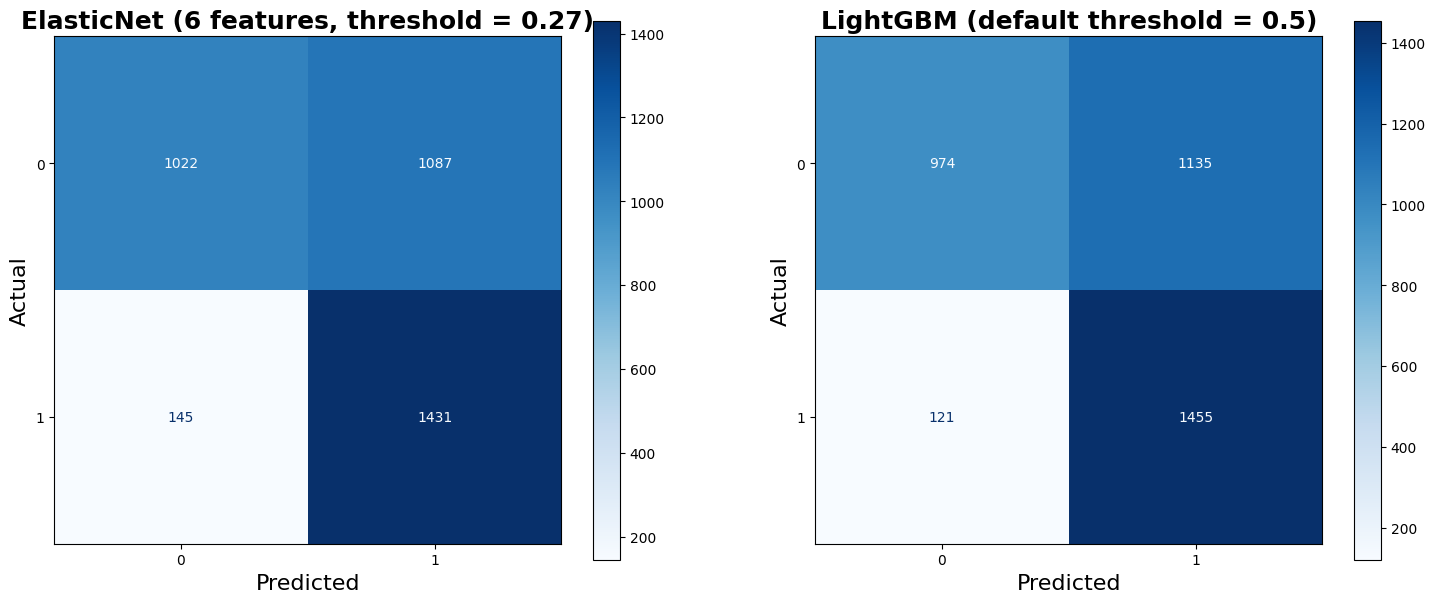

In [104]:
# confusion matrix 
# predict 
y_test_10_pred_lgbm = lgbm_pipe_q10.predict(x_test_10)
y_test_prob_10 = lgbm_pipe_q10.predict_proba(x_test_10)[:, 1]

cm_lgbm = confusion_matrix(y_test_10, y_test_10_pred_lgbm)

# confusion matrixes or both models 
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ElasticNet CM
ConfusionMatrixDisplay(cm).plot(
    ax=axes[0],
    cmap="Blues",
    values_format="d"
)
# aesthetics 
axes[0].set_title("ElasticNet (6 features, threshold = 0.27)", 
                  fontweight = "bold",
                  fontsize = 18)
axes[0].set_xlabel("Predicted", 
                   fontsize = 16)
axes[0].set_ylabel("Actual", 
                   fontsize = 16)

# LightGBM CM
ConfusionMatrixDisplay(cm_lgbm).plot(
    ax=axes[1],
    cmap="Blues",
    values_format="d"
)
# aesthetics 
axes[1].set_title("LightGBM (default threshold = 0.5)", 
                  fontweight = "bold", 
                  fontsize = 18)
axes[1].set_xlabel("Predicted", 
                   fontsize = 16)
axes[1].set_ylabel("Actual", 
                   fontsize = 16)

# show the plot
plt.show()


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


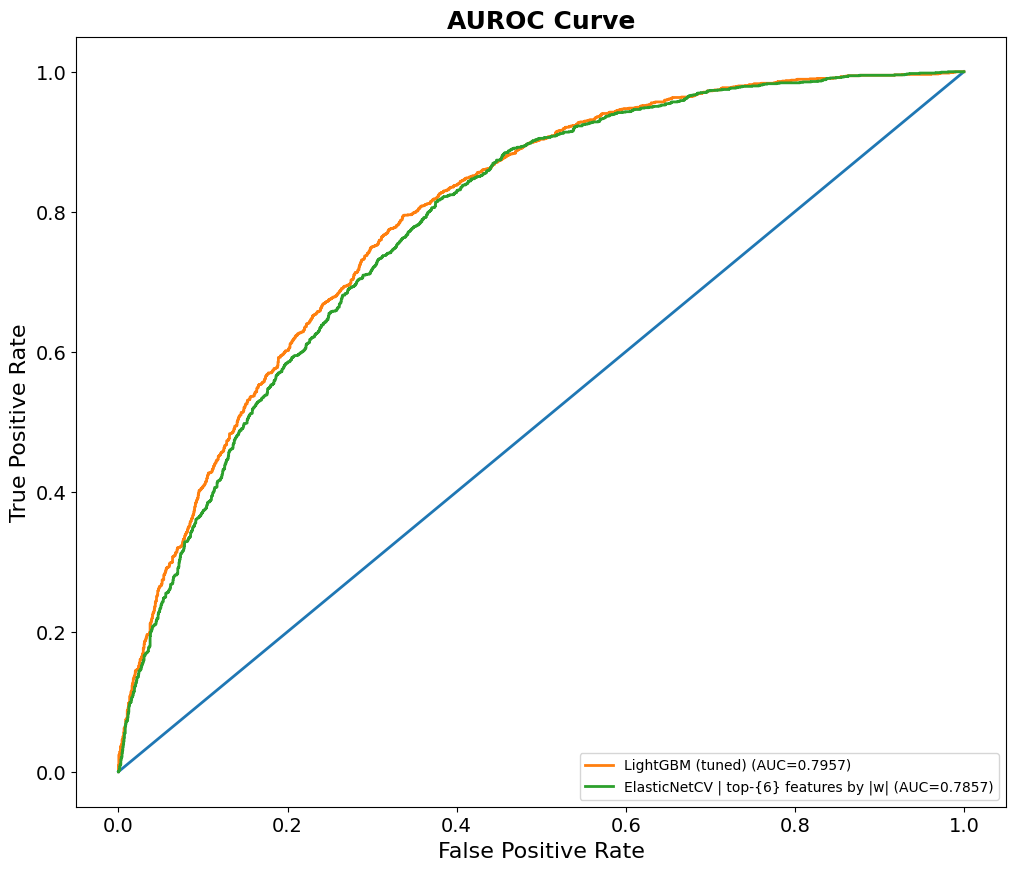

In [106]:
# create the figure once
fig, ax = plt.subplots(figsize=(12, 10))

# diagonal baseline once
ax.plot([0, 1], [0, 1], linewidth=2)

# predictions on probability 
y_test_prob_10_lgbm = lgbm_pipe_q10.predict_proba(x_test_10)[:, 1]
y_test_prob_10_elastic = pipelines_q10_logistic_reduced.predict_proba(x_test_10_reduced_final)[:, 1]

# add models using our function 
add_roc(ax, y_test_10, y_test_prob_10_lgbm, "LightGBM (tuned)")
add_roc(ax, y_test_10, y_test_prob_10_elastic, "ElasticNetCV | top-{6} features by |w|")
# aesthetics 
# title
ax.set_title("AUROC Curve", fontsize=18, fontweight="bold")

# xlabel
ax.set_xlabel("False Positive Rate", fontsize=16)
# ylabel
ax.set_ylabel("True Positive Rate", fontsize=16)

# tick_params
ax.tick_params(labelsize=14)

# legend
ax.legend(frameon=True, loc="lower right")

# show the plot
plt.show()


We evaluated whether switching from a parsimonious, interpretable Elastic Net model to a fully tuned LightGBM model yields a meaningful performance improvement.

LightGBM achieves a slightly higher ROC AUC (≈ 0.796 vs ≈ 0.786). However, the improvement is modest and does not translate into a qualitatively different error profile. The ROC curves largely overlap, indicating that both models rank observations similarly across most operating points.

From the confusion matrices, LightGBM identifies slightly more true positives and slightly fewer false negatives at its default threshold, but this comes with a comparable increase in false positives. When thresholds are adjusted to match recall levels, the practical difference between the two models further narrows.

While LightGBM marginally improves ranking performance, it introduces:
- Substantially higher model complexity
- Reduced interpretability
- Additional tuning and maintenance overhead

Given that the performance gain is small and does not change downstream decisions, the added complexity is not justified for this task.

The data appears to be signal-limited rather than model-limited. Even a highly flexible, tuned LightGBM model cannot extract substantially more information than the 6-feature Elastic Net model.

As a result, we do not proceed to XGBoost. The expected gains would be similarly marginal while further increasing complexity. The 6-feature Elastic Net model remains the preferred final model due to its strong performance, interpretability, and operational simplicity.